## Configuration & Parameters

Default parameters for manual execution. When run via papermill/batch mode, these will be overridden.

In [ ]:
# Parameters Cell (papermill injects values here in batch mode)
# For manual execution, these defaults are used

FOLDER_PATH = r"matchup_001_all_in_vs_anti_allin_v3"  # Update this path for manual runs
#FOLDER_PATH = r"results_20260127_143906"  # Update this path for manual runs

CSV_FILE_PATH = rf"{FOLDER_PATH}\all_games_minimal.csv"
CSV_INFO_FILE_PATH = rf"{FOLDER_PATH}\simulation_summary.json"

CSV_TYPE = "minimal"  # Options: "full" or "minimal"

INCLUDE_OT_GAMES = True  # Set to False to exclude overtime games

# Toggle for Statistical Analysis section (Paper Methodology)
# Set to False to skip the statistical analysis section during batch processing
ENABLE_FIRST_ROUND_ANALYSIS = False
#The first round analysis is not polished. Only included for educational purposes. It is not used in the paper.


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats

import os
import base64
from io import BytesIO
from datetime import datetime

colors = "pastel"
# Set seaborn color palette for all plots
sns.set_palette(colors)
sns.color_palette(colors)
COLOR_PALETTE = sns.color_palette(colors)

sns.set_style("whitegrid")

start_time = datetime.now()
print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Starting analysis for: {FOLDER_PATH}")

2026-02-13 10:01:18 - Starting analysis for: matchup_001_all_in_vs_anti_allin_v3


## HTML Export Utility

This function allows continuous export of analysis results to a single HTML file.

In [45]:


class HTMLExporter:
    """
    Continuously export analysis results to a single HTML file.
    Supports: text/strings, matplotlib figures, and plotly graphs.
    """
    
    def __init__(self, output_file='analysis_export.html'):
        self.output_file = output_file
        self.is_new_file = not os.path.exists(output_file)
        
        if self.is_new_file:
            self._initialize_html()
    
    def _initialize_html(self):
        """Create a new HTML file with proper structure"""
        html_header = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analysis Export</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            max-width: 1500px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f5f5f5;
        }
        .export-item {
            background: white;
            margin: 20px 0;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .timestamp {
            color: #666;
            font-size: 0.9em;
            margin-bottom: 10px;
        }
        .text-content {
            white-space: pre-wrap;
            font-family: 'Courier New', monospace;
            background: #f8f8f8;
            padding: 15px;
            border-radius: 4px;
            border-left: 4px solid #007acc;
        }
        .plot-container {
            margin: 15px 0;
        }
        h1 {
            color: #333;
            border-bottom: 3px solid #007acc;
            padding-bottom: 10px;
        }
        img {
            max-width: 100%;
            height: auto;
        }
    </style>
</head>
<body>
    <h1>Analysis Export Results</h1>
    <div id="content">
"""
        html_footer = """
    </div>
</body>
</html>"""
        
        with open(self.output_file, 'w', encoding='utf-8') as f:
            f.write(html_header)
            f.write(html_footer)
    
    def _get_timestamp(self):
        """Get current timestamp"""
        return datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    def _fig_to_base64(self, fig):
        """Convert matplotlib figure to base64 string"""
        buffer = BytesIO()
        fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
        buffer.seek(0)
        img_str = base64.b64encode(buffer.read()).decode()
        buffer.close()
        return img_str
    
    def export(self, content, title=None):
        """
        Export content to HTML file.
        
        Parameters:
        -----------
        content : str, matplotlib.figure.Figure, or plotly.graph_objs.Figure
            The content to export
        title : str, optional
            A title for this export item
        """
        # Read existing content
        with open(self.output_file, 'r', encoding='utf-8') as f:
            html_content = f.read()
        
        # Find the insertion point (before closing div and body tags)
        insert_pos = html_content.rfind('    </div>')
        
        # Build the new content block
        timestamp = self._get_timestamp()
        new_block = f'\n        <div class="export-item">\n'
        new_block += f'            <div class="timestamp">{timestamp}</div>\n'
        
        if title:
            new_block += f'            <h3>{title}</h3>\n'
        
        # Handle different content types
        if isinstance(content, str):
            # String/text content
            new_block += f'            <div class="text-content">{content}</div>\n'
        
        elif hasattr(content, 'savefig'):
            # Matplotlib figure
            img_data = self._fig_to_base64(content)
            new_block += f'            <div class="plot-container">\n'
            new_block += f'                <img src="data:image/png;base64,{img_data}" alt="Plot"/>\n'
            new_block += f'            </div>\n'
        
        elif hasattr(content, 'to_html'):
            # Plotly figure
            plotly_html = content.to_html(include_plotlyjs=False, div_id=f'plot_{timestamp.replace(" ", "_").replace(":", "-")}')
            new_block += f'            <div class="plot-container">\n'
            new_block += f'                {plotly_html}\n'
            new_block += f'            </div>\n'
        
        else:
            # Fallback: convert to string
            new_block += f'            <div class="text-content">{str(content)}</div>\n'
        
        new_block += '        </div>\n'
        
        # Insert the new block
        new_html = html_content[:insert_pos] + new_block + html_content[insert_pos:]
        
        # Write back to file
        with open(self.output_file, 'w', encoding='utf-8') as f:
            f.write(new_html)
        
        print(f"✓ Exported to {self.output_file}")

# Note: Exporter will be initialized after loading team names and folder path
print("HTMLExporter class loaded!")
print("\nUsage examples:")
print("  exporter.export('Your text here', title='My Analysis')")
print("  exporter.export(fig, title='Matplotlib Plot')")
print("  exporter.export(plotly_fig, title='Interactive Plot')")

HTMLExporter class loaded!

Usage examples:
  exporter.export('Your text here', title='My Analysis')
  exporter.export(fig, title='Matplotlib Plot')
  exporter.export(plotly_fig, title='Interactive Plot')


## Load and Prepare Data

In [46]:
# Load CSV data
df = pd.read_csv(CSV_FILE_PATH, sep=';')

print(f"Loaded {len(df)} rows from {CSV_FILE_PATH}")
print(f"Number of unique games: {df['game_id'].nunique()}")

print("\nColumns in the dataset:")
for col in df.columns:
     print(f" - {col}")

# Load simulation summary information
with open(CSV_INFO_FILE_PATH, 'r') as f:
    sim_summary = json.load(f)

# Labels for teams
t1_label = sim_summary['simulation_config'].get('team1_strategy', 'Team 1')
t2_label = sim_summary['simulation_config'].get('team2_strategy', 'Team 2')

# Initialize exporter with proper naming convention
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
t1_strat = t1_label.replace(' ', '_').replace('-', '_')
t2_strat = t2_label.replace(' ', '_').replace('-', '_')
output_filename = f"{FOLDER_PATH}\\analysis_report_{timestamp}_{t1_strat}_vs_{t2_strat}.html"

exporter = HTMLExporter(output_filename)

print("\nHTMLExporter initialized!")
print(f"Export file: {exporter.output_file}")

# Export data load info
exporter.export(f"""Data Loaded Successfully
{'='*60}
File: {CSV_FILE_PATH}
Total Rows: {len(df)}
Unique Games: {df['game_id'].nunique()}
Team 1: {t1_label}
Team 2: {t2_label}
{'='*60}""", title="Data Loading Summary")


Loaded 5443934 rows from matchup_001_all_in_vs_anti_allin_v3\all_games_minimal.csv
Number of unique games: 200000

Columns in the dataset:
 - round_number
 - is_t1_winner
 - is_t1_ct
 - is_ot
 - outcome_reason_code
 - outcome_bomb_planted
 - t1_score_start
 - t1_score_end
 - t1_spent
 - t1_earned
 - t1_funds_start
 - t1_rs_eq
 - t1_fte_eq
 - t1_re_eq
 - t1_survivors
 - t1_consecutive_losses
 - t1_consecutive_losses_start
 - t1_consecutive_wins
 - t1_consecutive_wins_start
 - t1_loss_bonus_level
 - t2_score_start
 - t2_score_end
 - t2_spent
 - t2_earned
 - t2_funds_start
 - t2_rs_eq
 - t2_fte_eq
 - t2_re_eq
 - t2_survivors
 - t2_consecutive_losses
 - t2_consecutive_losses_start
 - t2_consecutive_wins
 - t2_consecutive_wins_start
 - t2_loss_bonus_level
 - game_id

HTMLExporter initialized!
Export file: matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs

## Filter Data

In [47]:

# Apply OT filter

if not INCLUDE_OT_GAMES:
    df_filtered = df[df['is_ot'] == False].copy()
else:
    df_filtered = df.copy()


filter_text = f"""Data Filtering Results
 Games after filter: {df_filtered['game_id'].nunique()} / {df['game_id'].nunique()}
 Percentage of remaining games: {df_filtered['game_id'].nunique() / df['game_id'].nunique() * 100:.2f}%
 
 Total Rows after filter: {len(df_filtered)}
 Rounds with OT: {df_filtered['is_ot'].sum()}
 Rounds without OT: {(~df_filtered['is_ot']).sum()}
"""

print(filter_text)

exporter.export(filter_text, title="Data Filter Summary")

Data Filtering Results
 Games after filter: 200000 / 200000
 Percentage of remaining games: 100.00%

 Total Rows after filter: 5443934
 Rounds with OT: 155518
 Rounds without OT: 5288416

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


## Data Summary Statistics

In [48]:



# Team 1 statistics
economic_summary = f"""
{t1_label}: 
  Starting Funds:
{df_filtered['t1_funds_start'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  FTE Equipment:
{df_filtered['t1_fte_eq'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Spent per Round:
{df_filtered['t1_spent'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Earned per Round:
{df_filtered['t1_earned'].describe().apply(lambda x: f"{x:,.2f}").to_string()}

{"=" * 60}

{t2_label}: 
  Starting Funds:
{df_filtered['t2_funds_start'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  FTE Equipment:
{df_filtered['t2_fte_eq'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Spent per Round:
{df_filtered['t2_spent'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Earned per Round:
{df_filtered['t2_earned'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
"""
print(economic_summary)


exporter.export(economic_summary, title="Economic Metrics Summary")


all_in: 
  Starting Funds:
count    5,443,934.00
mean        15,147.59
std          5,833.93
min          4,000.00
25%         12,000.00
50%         17,750.00
75%         18,050.00
max         50,000.00
  FTE Equipment:
count    5,443,934.00
mean        24,191.81
std         13,931.65
min          5,000.00
25%         13,300.00
50%         21,000.00
75%         33,158.00
max        134,218.00
  Spent per Round:
count    5,443,934.00
mean        15,147.59
std          5,833.93
min          4,000.00
25%         12,000.00
50%         17,750.00
75%         18,050.00
max         50,000.00
  Earned per Round:
count    5,443,934.00
mean        15,717.36
std          3,712.99
min          5,600.00
25%         12,600.00
50%         17,750.00
75%         18,050.00
max         22,800.00


anti_allin_v3: 
  Starting Funds:
count    5,443,934.00
mean        16,788.17
std          6,939.27
min          4,000.00
25%         12,300.00
50%         17,750.00
75%         19,300.00
max         50,315.00


## Economic Analysis: Expenditure and Resource Allocation

Analyze spending patterns and resource allocation relative to available funds

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


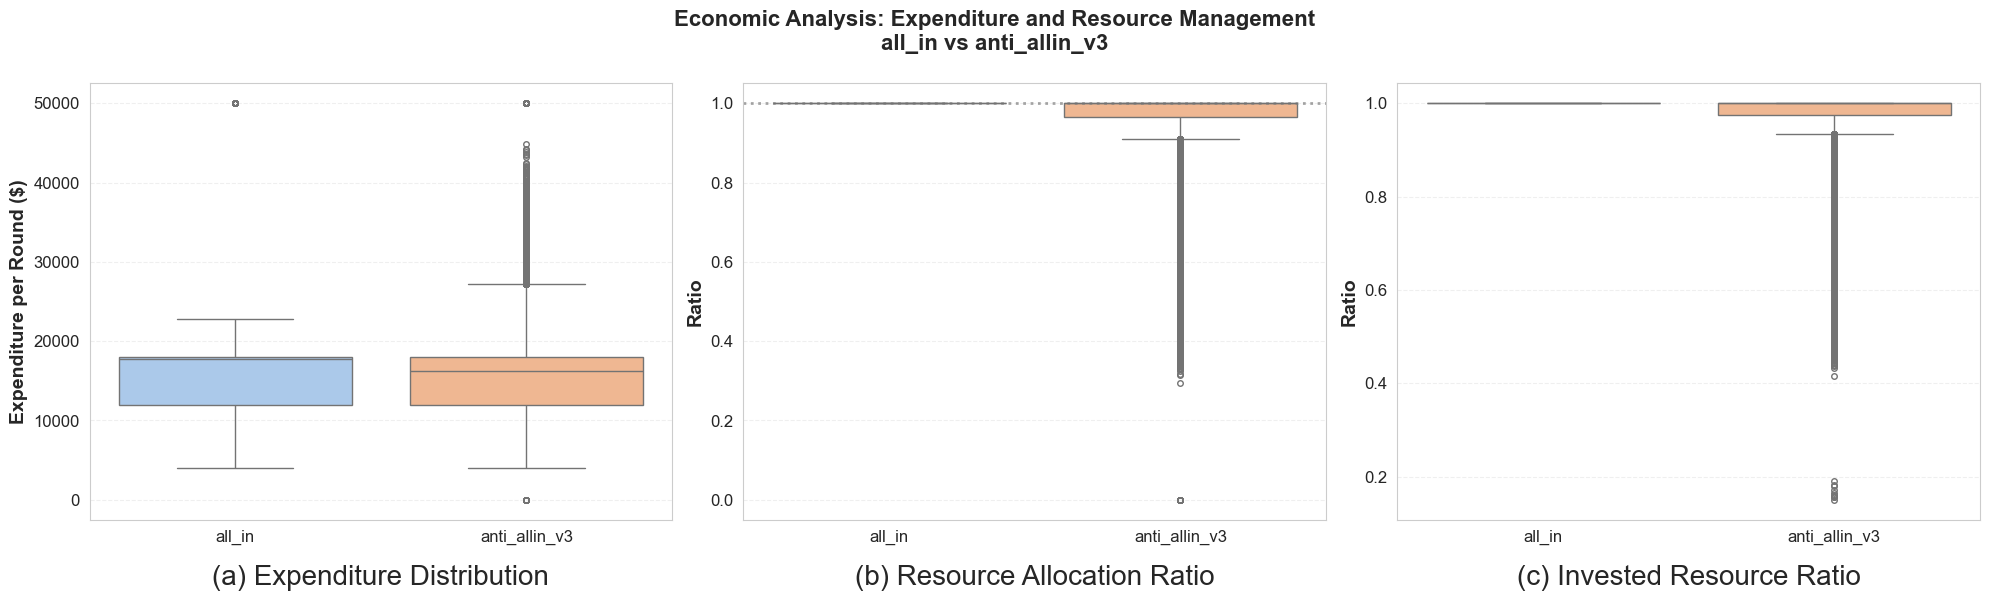


ECONOMIC ANALYSIS: EXPENDITURE AND RESOURCE ALLOCATION

Expenditure (Absolute Spending per Round):
----------------------------------------
all_in:
  Mean:   $15147.59
  Median: $17750.00
  Std:    $5833.93
  Min:    $4000.00
  Max:    $50000.00
  Q1:     $12000.00
  Q3:     $18050.00
  N:      5443934

anti_allin_v3:
  Mean:   $15169.61
  Median: $16275.00
  Std:    $5981.85
  Min:    $0.00
  Max:    $50000.00
  Q1:     $11970.00
  Q3:     $18050.00
  N:      5443934

Resource Allocation Ratio (Spent / Available Funds):
----------------------------------------
all_in:
  Mean:   1.0000
  Median: 1.0000
  Std:    0.0000
  Min:    1.0000
  Max:    1.0000
  N:      5443934

anti_allin_v3:
  Mean:   0.9300
  Median: 1.0000
  Std:    0.1354
  Min:    0.0000
  Max:    1.0000
  N:      5443934

Invested Resource Ratio (Equipment / Total Resources):
----------------------------------------
all_in:
  Mean:   1.0000
  Median: 1.0000
  Std:    0.0000
  Min:    1.0000
  Max:    1.0000
  N:      5

In [49]:
# Expenditure Analysis: Boxplot and Resource Allocation Ratios
# Calculate spending metrics for rounds won by each team

# Expenditure (absolute spending)
t1_spent_on_win = df_filtered['t1_spent']
t2_spent_on_win = df_filtered['t2_spent']

# Resource allocation ratio: spent / funds_start (what % of available funds was spent)
t1_resource_allocation_ratio = df_filtered['t1_spent'] / df_filtered['t1_funds_start']
t2_resource_allocation_ratio = df_filtered['t2_spent'] / df_filtered['t2_funds_start']

# Invested resource ratio: fte_eq / (funds_start + rs_eq) (what % of total resources was invested)
t1_invested_resource_ratio = df_filtered['t1_fte_eq'] / (df_filtered['t1_funds_start'] + df_filtered['t1_rs_eq'])
t2_invested_resource_ratio = df_filtered['t2_fte_eq'] / (df_filtered['t2_funds_start'] + df_filtered['t2_rs_eq'])

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# ===== Left Plot: Expenditure Boxplot =====
spent_data = pd.DataFrame({
    'Expenditure ($)': pd.concat([t1_spent_on_win, t2_spent_on_win]),
    'Team': [t1_label]*len(t1_spent_on_win) + [t2_label]*len(t2_spent_on_win)
})

sns.boxplot(data=spent_data, x='Team', y='Expenditure ($)', ax=ax1,
            palette=COLOR_PALETTE[:2], hue='Team', fliersize=4)

ax1.set_ylabel('Expenditure per Round ($)', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_title('')
ax1.tick_params(labelsize=12)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add subplot label
ax1.text(0.5, -0.15, '(a) Expenditure Distribution',
            transform=ax1.transAxes,
            horizontalalignment='center',
            fontsize=20)



# ===== Middle Plot: Resource Allocation Ratio (Spent/Funds_Start) =====
allocation_data = pd.DataFrame({
    'Allocation Ratio': pd.concat([t1_resource_allocation_ratio, t2_resource_allocation_ratio]),
    'Team': [t1_label]*len(t1_resource_allocation_ratio) + [t2_label]*len(t2_resource_allocation_ratio)
})

sns.boxplot(data=allocation_data, x='Team', y='Allocation Ratio', ax=ax2,
            palette=COLOR_PALETTE[:2], hue='Team', fliersize=4)

ax2.set_ylabel('Ratio', fontsize=14, fontweight='bold')
ax2.set_xlabel('')
ax2.set_title('')
ax2.tick_params(labelsize=12)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(1.0, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Full Budget (1.0)')

# Add subplot label
ax2.text(0.5, -0.15, '(b) Resource Allocation Ratio',
             transform=ax2.transAxes,
             horizontalalignment='center',
             fontsize=20)

# ===== Right Plot: Invested Resource Ratio (FTE_EQ / Total Resources) =====
invested_data = pd.DataFrame({
    'Invested Resource Ratio': pd.concat([t1_invested_resource_ratio, t2_invested_resource_ratio]),
    'Team': [t1_label]*len(t1_invested_resource_ratio) + [t2_label]*len(t2_invested_resource_ratio)
})

sns.boxplot(data=invested_data, x='Team', y='Invested Resource Ratio', ax=ax3,
            palette=COLOR_PALETTE[:2], hue='Team', fliersize=4)

ax3.set_ylabel('Ratio', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_title('')
ax3.tick_params(labelsize=12)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add subplot label
ax3.text(0.5, -0.15, '(c) Invested Resource Ratio',
             transform=ax3.transAxes,
             horizontalalignment='center',
             fontsize=20)

plt.suptitle(f'Economic Analysis: Expenditure and Resource Management\n{t1_label} vs {t2_label}',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Export
exporter.export(fig, title="Economic Analysis - Expenditure and Resource Allocation")
plt.show()

# Print summary statistics
economic_summary = f"""
{'='*80}
ECONOMIC ANALYSIS: EXPENDITURE AND RESOURCE ALLOCATION
{'='*80}

Expenditure (Absolute Spending per Round):
{'-'*40}
{t1_label}:
  Mean:   ${t1_spent_on_win.mean():.2f}
  Median: ${t1_spent_on_win.median():.2f}
  Std:    ${t1_spent_on_win.std():.2f}
  Min:    ${t1_spent_on_win.min():.2f}
  Max:    ${t1_spent_on_win.max():.2f}
  Q1:     ${t1_spent_on_win.quantile(0.25):.2f}
  Q3:     ${t1_spent_on_win.quantile(0.75):.2f}
  N:      {len(t1_spent_on_win)}

{t2_label}:
  Mean:   ${t2_spent_on_win.mean():.2f}
  Median: ${t2_spent_on_win.median():.2f}
  Std:    ${t2_spent_on_win.std():.2f}
  Min:    ${t2_spent_on_win.min():.2f}
  Max:    ${t2_spent_on_win.max():.2f}
  Q1:     ${t2_spent_on_win.quantile(0.25):.2f}
  Q3:     ${t2_spent_on_win.quantile(0.75):.2f}
  N:      {len(t2_spent_on_win)}

Resource Allocation Ratio (Spent / Available Funds):
{'-'*40}
{t1_label}:
  Mean:   {t1_resource_allocation_ratio.mean():.4f}
  Median: {t1_resource_allocation_ratio.median():.4f}
  Std:    {t1_resource_allocation_ratio.std():.4f}
  Min:    {t1_resource_allocation_ratio.min():.4f}
  Max:    {t1_resource_allocation_ratio.max():.4f}
  N:      {len(t1_resource_allocation_ratio)}

{t2_label}:
  Mean:   {t2_resource_allocation_ratio.mean():.4f}
  Median: {t2_resource_allocation_ratio.median():.4f}
  Std:    {t2_resource_allocation_ratio.std():.4f}
  Min:    {t2_resource_allocation_ratio.min():.4f}
  Max:    {t2_resource_allocation_ratio.max():.4f}
  N:      {len(t2_resource_allocation_ratio)}

Invested Resource Ratio (Equipment / Total Resources):
{'-'*40}
{t1_label}:
  Mean:   {t1_invested_resource_ratio.mean():.4f}
  Median: {t1_invested_resource_ratio.median():.4f}
  Std:    {t1_invested_resource_ratio.std():.4f}
  Min:    {t1_invested_resource_ratio.min():.4f}
  Max:    {t1_invested_resource_ratio.max():.4f}
  N:      {len(t1_invested_resource_ratio)}

{t2_label}:
  Mean:   {t2_invested_resource_ratio.mean():.4f}
  Median: {t2_invested_resource_ratio.median():.4f}
  Std:    {t2_invested_resource_ratio.std():.4f}
  Min:    {t2_invested_resource_ratio.min():.4f}
  Max:    {t2_invested_resource_ratio.max():.4f}
  N:      {len(t2_invested_resource_ratio)}

Notes:
------
- Expenditure: Total dollars spent during buy phase
- Resource Allocation Ratio: % of available funds spent (values >1 indicate overspending from reserves)
- Investment Efficiency: Equipment value relative to total available resources (funds + saved equipment)
"""
print(economic_summary)
exporter.export(economic_summary, title="Economic Analysis Summary")

### Invested Resource ratios & Resource Allocation Ratio for both teams Ratio Analysis

Analyzing the ratio of Invested resources to available funds for both teams.

Resource Allocation and Invested Resource Ratio Analysis by Team


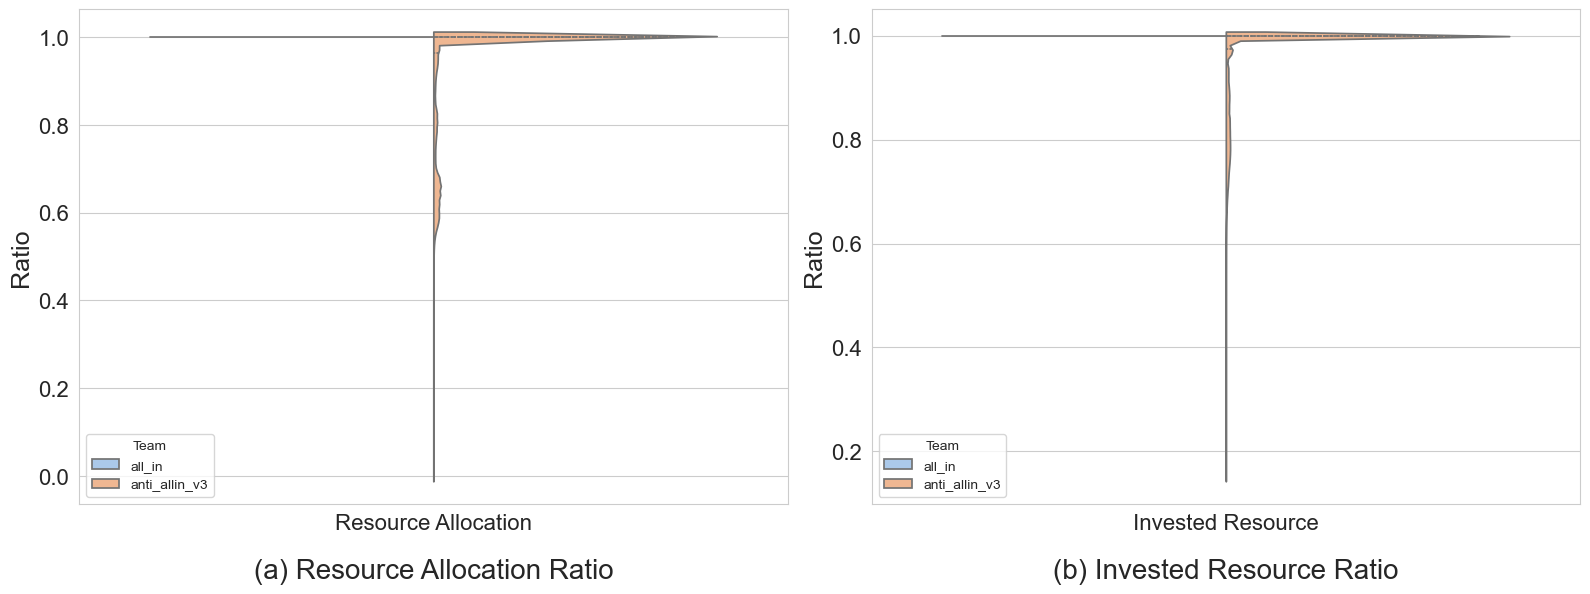

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [50]:

# Calculate ratios for both teams

# Team 1 ratios
t1_resource_allocation_ratio = df_filtered['t1_spent'] / df_filtered['t1_funds_start'] #resource allocation ratio
t1_invested_resource_ratio = df_filtered['t1_fte_eq'] / (df_filtered['t1_funds_start'] + df_filtered['t1_rs_eq']) #invested resource ratio

# Team 2 ratios
t2_resource_allocation_ratio = df_filtered['t2_spent'] / df_filtered['t2_funds_start'] #resource allocation ratio
t2_invested_resource_ratio = df_filtered['t2_fte_eq'] / (df_filtered['t2_funds_start'] + df_filtered['t2_rs_eq']) #invested resource ratio

# ============================================================================
# FIGURE: Resource allocation RATIO VIOLIN PLOTS (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for split violin plots combining both teams
data_funds = pd.DataFrame({
    'Category': ['Resource Allocation'] * (len(t1_resource_allocation_ratio.dropna()) + len(t2_resource_allocation_ratio.dropna())),
    'Team': [t1_label] * len(t1_resource_allocation_ratio.dropna()) + [t2_label] * len(t2_resource_allocation_ratio.dropna()),
    'Ratio': list(t1_resource_allocation_ratio.dropna()) + list(t2_resource_allocation_ratio.dropna())
})

data_total = pd.DataFrame({
    'Category': ['Invested Resource'] * (len(t1_invested_resource_ratio.dropna()) + len(t2_invested_resource_ratio.dropna())),
    'Team': [t1_label] * len(t1_invested_resource_ratio.dropna()) + [t2_label] * len(t2_invested_resource_ratio.dropna()),
    'Ratio': list(t1_invested_resource_ratio.dropna()) + list(t2_invested_resource_ratio.dropna())
})

# Plot 1: Resource Allocation Ratio (both teams)
sns.violinplot(data=data_funds, x='Category', y='Ratio', ax=axes[0],
               palette=COLOR_PALETTE[:2], hue='Team', legend=True, inner='quartile', split=True)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ratio', fontsize=18)
axes[0].tick_params(labelsize=16)

# Add subplot label
axes[0].text(0.5, -0.15, '(a) Resource Allocation Ratio',
             transform=axes[0].transAxes,
             horizontalalignment='center',
             fontsize=20)
sns.violinplot(data=data_total, x='Category', y='Ratio', ax=axes[1],
               palette=COLOR_PALETTE[:2], hue='Team', legend=True, inner='quartile', split=True)
axes[1].set_xlabel('')
axes[1].set_ylabel('Ratio', fontsize=18)
axes[1].tick_params(labelsize=16)

# Add subplot label
axes[1].text(0.5, -0.15, '(b) Invested Resource Ratio',
             transform=axes[1].transAxes,
             horizontalalignment='center',
             fontsize=20)

# Print title before showing figure
print("Resource Allocation and Invested Resource Ratio Analysis by Team")

plt.tight_layout()
plt.show()

exporter.export("Resource Allocation and Invested Resource Ratio Analysis by Team", title="Figure Title")
exporter.export(fig, title="Resource Allocation and Invested Resource Ratio Analysis - Violin Plots")



fte_stats_text = f""" 
 FTE EQUIPMENT RATIO STATISTICS
 {t1_label}:
   FTE/Starting Funds:
     Mean={t1_resource_allocation_ratio.mean():.3f}, Median={t1_resource_allocation_ratio.median():.3f}
     Q1 (25%)={t1_resource_allocation_ratio.quantile(0.25):.3f}, Q3 (75%)={t1_resource_allocation_ratio.quantile(0.75):.3f}
     Min={t1_resource_allocation_ratio.min():.3f}, Max={t1_resource_allocation_ratio.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t1_invested_resource_ratio.mean():.3f}, Median={t1_invested_resource_ratio.median():.3f}
     Q1 (25%)={t1_invested_resource_ratio.quantile(0.25):.3f}, Q3 (75%)={t1_invested_resource_ratio.quantile(0.75):.3f}
     Min={t1_invested_resource_ratio.min():.3f}, Max={t1_invested_resource_ratio.max():.3f}
 {t2_label}:
   FTE/Starting Funds:
     Mean={t2_resource_allocation_ratio.mean():.3f}, Median={t2_resource_allocation_ratio.median():.3f}
     Q1 (25%)={t2_resource_allocation_ratio.quantile(0.25):.3f}, Q3 (75%)={t2_resource_allocation_ratio.quantile(0.75):.3f}
     Min={t2_resource_allocation_ratio.min():.3f}, Max={t2_resource_allocation_ratio.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t2_invested_resource_ratio.mean():.3f}, Median={t2_invested_resource_ratio.median():.3f}
     Q1 (25%)={t2_invested_resource_ratio.quantile(0.25):.3f}, Q3 (75%)={t2_invested_resource_ratio.quantile(0.75):.3f}
     Min={t2_invested_resource_ratio.min():.3f}, Max={t2_invested_resource_ratio.max():.3f}
"""






exporter.export(fte_stats_text, title="FTE Ratio Statistics")

Distribution of Ratios T1


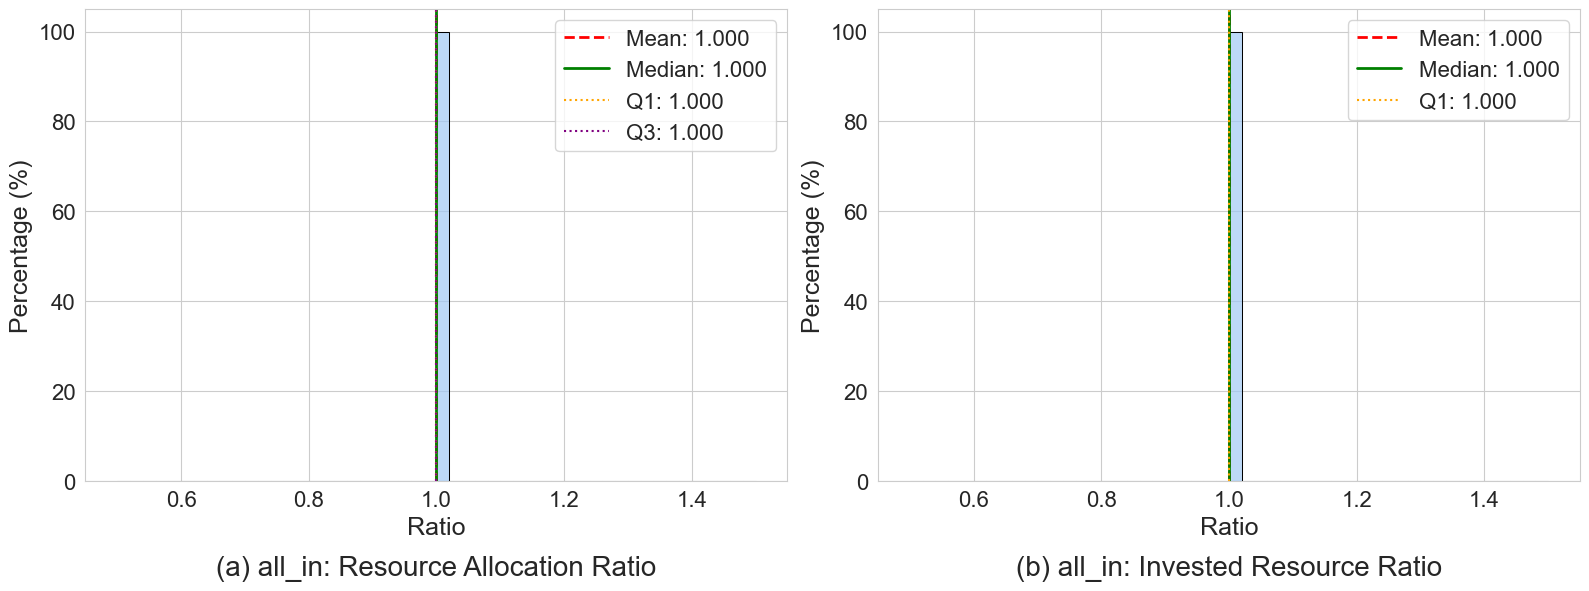

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
Distribution of Invested Resource Ratios T2


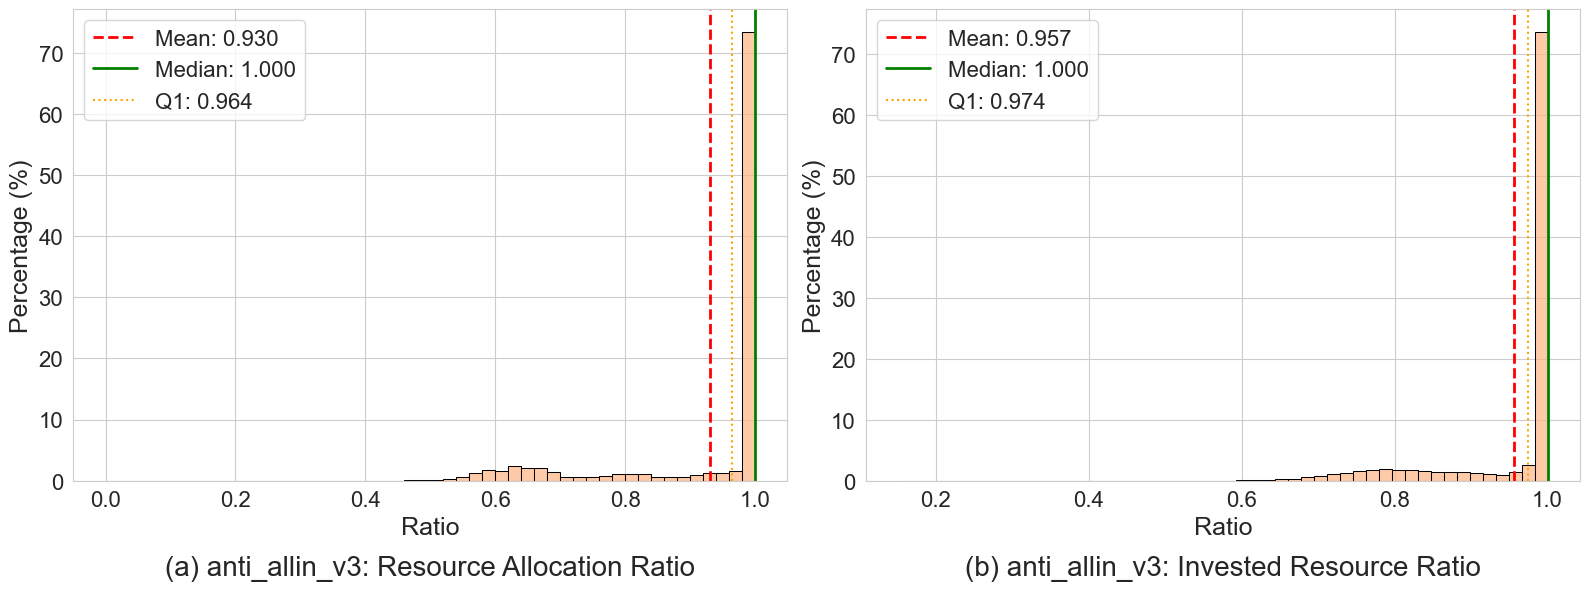

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [51]:
# ============================================================================
# DISTRIBUTION PLOTS FOR FTE EQUIPMENT RATIOS (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team 1 - Resource Allocation Ratio Distribution
sns.histplot(data=t1_resource_allocation_ratio.dropna(), bins=50, stat='percent', 
             color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black', ax=axes[0])
axes[0].axvline(t1_resource_allocation_ratio.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_resource_allocation_ratio.mean():.3f}')
axes[0].axvline(t1_resource_allocation_ratio.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_resource_allocation_ratio.median():.3f}')
axes[0].axvline(t1_resource_allocation_ratio.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_resource_allocation_ratio.quantile(0.25):.3f}')
axes[0].axvline(t1_resource_allocation_ratio.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t1_resource_allocation_ratio.quantile(0.75):.3f}')
axes[0].set_xlabel('Ratio', fontsize=18)
axes[0].set_ylabel('Percentage (%)', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].legend(fontsize=16)
axes[0].text(0.5, -0.20, f'(a) {t1_label}: Resource Allocation Ratio',
                transform=axes[0].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Team 1 - Invested Resource Ratio Distribution
sns.histplot(data=t1_invested_resource_ratio.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black', ax=axes[1])
axes[1].axvline(t1_invested_resource_ratio.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_invested_resource_ratio.mean():.3f}')
axes[1].axvline(t1_invested_resource_ratio.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_invested_resource_ratio.median():.3f}')
axes[1].axvline(t1_invested_resource_ratio.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_invested_resource_ratio.quantile(0.25):.3f}')
axes[1].set_xlabel('Ratio', fontsize=18)
axes[1].set_ylabel('Percentage (%)', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].legend(fontsize=16)
axes[1].text(0.5, -0.20, f'(b) {t1_label}: Invested Resource Ratio',
                transform=axes[1].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Print title before showing figure
print("Distribution of Ratios T1")

plt.tight_layout()
plt.show()

exporter.export("Distribution of Ratios T1", title="Figure Title")
exporter.export(fig, title="T1 Ratio Distributions")

#Team 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team 2 - Resource Allocation Ratio Distribution
sns.histplot(data=t2_resource_allocation_ratio.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black', ax=axes[0])
axes[0].axvline(t2_resource_allocation_ratio.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_resource_allocation_ratio.mean():.3f}')
axes[0].axvline(t2_resource_allocation_ratio.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_resource_allocation_ratio.median():.3f}')
axes[0].axvline(t2_resource_allocation_ratio.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_resource_allocation_ratio.quantile(0.25):.3f}')
axes[0].set_xlabel('Ratio', fontsize=18)
axes[0].set_ylabel('Percentage (%)', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].legend(fontsize=16)
axes[0].text(0.5, -0.20, f'(a) {t2_label}: Resource Allocation Ratio',
                transform=axes[0].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Team 2 - Invested Resource Ratio Distribution
sns.histplot(data=t2_invested_resource_ratio.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black', ax=axes[1])
axes[1].axvline(t2_invested_resource_ratio.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_invested_resource_ratio.mean():.3f}')
axes[1].axvline(t2_invested_resource_ratio.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_invested_resource_ratio.median():.3f}')
axes[1].axvline(t2_invested_resource_ratio.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_invested_resource_ratio.quantile(0.25):.3f}')
axes[1].set_xlabel('Ratio', fontsize=18)
axes[1].set_ylabel('Percentage (%)', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].legend(fontsize=16)
axes[1].text(0.5, -0.20, f'(b) {t2_label}: Invested Resource Ratio',
                transform=axes[1].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Print title before showing figure
print("Distribution of Invested Resource Ratios T2")

plt.tight_layout()
plt.show()

exporter.export("Distribution of Invested Resource Ratios T2", title="Figure Title")
exporter.export(fig, title="Invested Resource Ratio Distributions T2")





✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


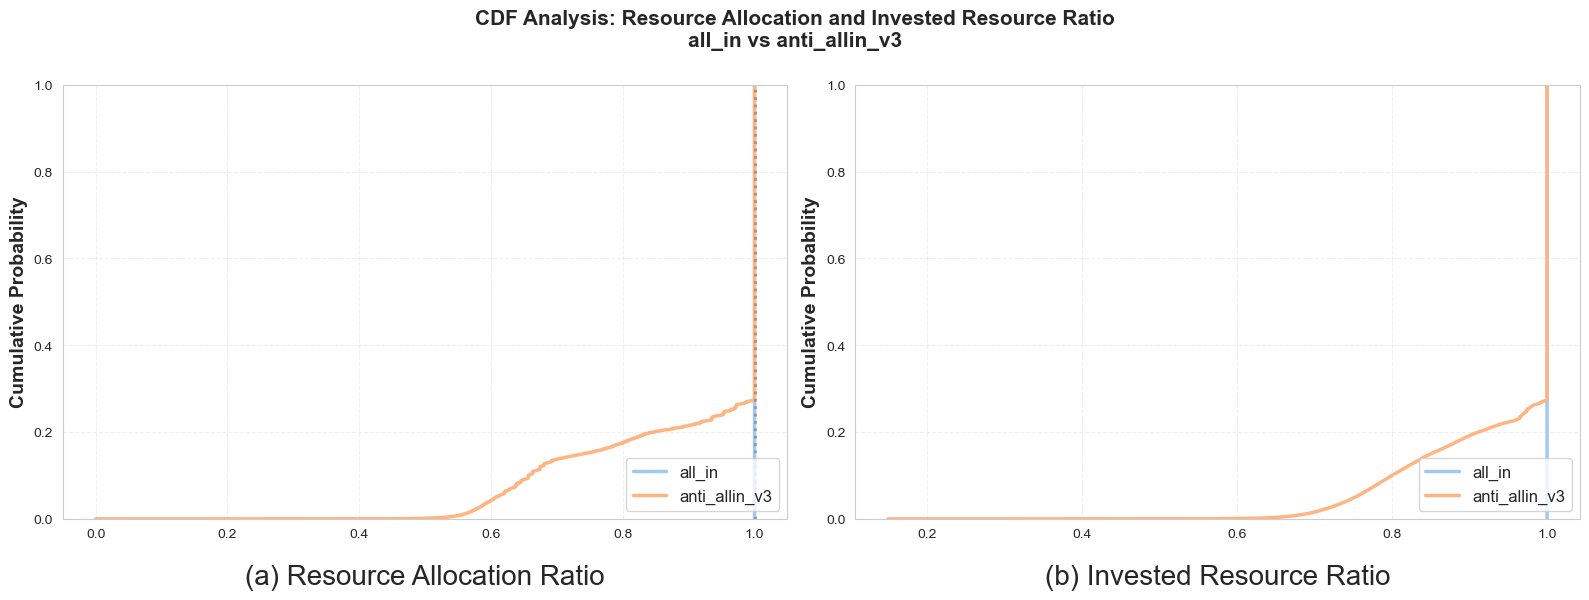

In [52]:
# CDF Analysis: Resource Allocation and Investment Efficiency
# Create CDF plots for the two ratio metrics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ===== Left Plot: Resource Allocation Ratio CDF =====
# Sort data for CDF
t1_alloc_sorted = np.sort(t1_resource_allocation_ratio)
t2_alloc_sorted = np.sort(t2_resource_allocation_ratio)

# Calculate CDF values
t1_alloc_cdf = np.arange(1, len(t1_alloc_sorted) + 1) / len(t1_alloc_sorted)
t2_alloc_cdf = np.arange(1, len(t2_alloc_sorted) + 1) / len(t2_alloc_sorted)

# Plot Resource Allocation Ratio CDF
ax1.plot(t1_alloc_sorted, t1_alloc_cdf, label=t1_label, color=COLOR_PALETTE[0], linewidth=2.5)
ax1.plot(t2_alloc_sorted, t2_alloc_cdf, label=t2_label, color=COLOR_PALETTE[1], linewidth=2.5)

ax1.set_xlabel('')
ax1.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax1.set_title('')
ax1.legend(fontsize=12, loc='lower right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1])

ax1.text(0.5, -0.15, '(a) Resource Allocation Ratio',
             transform=ax1.transAxes,
             horizontalalignment='center',
             fontsize=20)

# Add reference line at 1.0 (full budget)
ax1.axvline(1.0, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Full Budget (1.0)')


# ===== Right Plot: Invested Resource Ratio CDF =====
# Sort data for CDF
t1_invest_sorted = np.sort(t1_invested_resource_ratio)
t2_invest_sorted = np.sort(t2_invested_resource_ratio)

# Calculate CDF values
t1_invest_cdf = np.arange(1, len(t1_invest_sorted) + 1) / len(t1_invest_sorted)
t2_invest_cdf = np.arange(1, len(t2_invest_sorted) + 1) / len(t2_invest_sorted)

# Plot Invested Resource Ratio CDF
ax2.plot(t1_invest_sorted, t1_invest_cdf, label=t1_label, color=COLOR_PALETTE[0], linewidth=2.5)
ax2.plot(t2_invest_sorted, t2_invest_cdf, label=t2_label, color=COLOR_PALETTE[1], linewidth=2.5)

ax2.set_xlabel('')
ax2.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax2.set_title('')
ax2.legend(fontsize=12, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])

ax2.text(0.5, -0.15, '(b) Invested Resource Ratio',
             transform=ax2.transAxes,
             horizontalalignment='center',
             fontsize=20)


plt.suptitle(f'CDF Analysis: Resource Allocation and Invested Resource Ratio\n{t1_label} vs {t2_label}',
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()

# Export
exporter.export(fig, title="CDF - Resource Allocation and Invested Resource Ratio")
plt.show()


Invested Resource Absolute Value Analysis


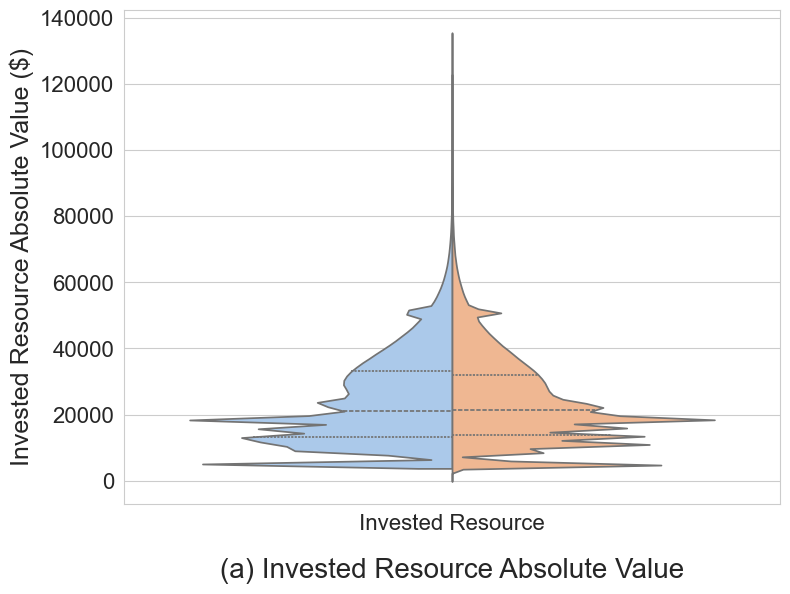

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html

 INVESTED RESOURCE ABSOLUTE VALUE STATISTICS")
 all_in:
   Mean: $24191.81
   Median: $21000.00
   Q1 (25%): $13300.00
   Q3 (75%): $33158.00
   Min: $5000.00
   Max: $134218.00
   Std Dev: $13931.65
 anti_allin_v3:
   Mean: $24115.79
   Median: $21343.00
   Q1 (25%): $13900.00
   Q3 (75%): $32084.00
   Min: $990.00
   Max: $121670.00
   Std Dev: $13465.75

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [53]:
# ============================================================================
# Invested Resource Absolute VALUES - SPLIT VIOLIN PLOT AND DISTRIBUTION (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Extract Invested Resource Absolute values
t1_invested_resource = df_filtered['t1_fte_eq']
t2_invested_resource = df_filtered['t2_fte_eq']

# Prepare combined data for split violin plot
data_invested_resource_combined = pd.DataFrame({
    'Category': ['Invested Resource'] * (len(t1_invested_resource.dropna()) + len(t2_invested_resource.dropna())),
    'Team': [t1_label] * len(t1_invested_resource.dropna()) + [t2_label] * len(t2_invested_resource.dropna()),
    'Invested Resource': list(t1_invested_resource.dropna()) + list(t2_invested_resource.dropna())
})

# Left plot: Split Violin Plot
sns.violinplot(data=data_invested_resource_combined, x='Category', y='Invested Resource', ax=axes,
               palette=COLOR_PALETTE[:2], hue='Team', legend=False, inner='quartile', split=True, gap=0)
axes.set_xlabel('')
axes.set_ylabel('Invested Resource Absolute Value ($)', fontsize=18)
axes.tick_params(labelsize=16)

# Add subplot label
axes.text(0.5, -0.15, '(a) Invested Resource Absolute Value',
          transform=axes.transAxes,
          horizontalalignment='center',
          fontsize=20)


# Print title before showing figure
print("Invested Resource Absolute Value Analysis")

plt.tight_layout()
plt.show()

exporter.export("Invested Resource Absolute Value Analysis", title="Figure Title")
exporter.export(fig, title="Invested Resource Absolute Value Analysis")


invested_resource_stats = f"""
 INVESTED RESOURCE ABSOLUTE VALUE STATISTICS")
 {t1_label}:
   Mean: ${t1_invested_resource.mean():.2f}
   Median: ${t1_invested_resource.median():.2f}
   Q1 (25%): ${t1_invested_resource.quantile(0.25):.2f}
   Q3 (75%): ${t1_invested_resource.quantile(0.75):.2f}
   Min: ${t1_invested_resource.min():.2f}
   Max: ${t1_invested_resource.max():.2f}
   Std Dev: ${t1_invested_resource.std():.2f}
 {t2_label}:
   Mean: ${t2_invested_resource.mean():.2f}
   Median: ${t2_invested_resource.median():.2f}
   Q1 (25%): ${t2_invested_resource.quantile(0.25):.2f}
   Q3 (75%): ${t2_invested_resource.quantile(0.75):.2f}
   Min: ${t2_invested_resource.min():.2f}
   Max: ${t2_invested_resource.max():.2f}
   Std Dev: ${t2_invested_resource.std():.2f}
"""
print(invested_resource_stats)

exporter.export(invested_resource_stats, title="Invested Resource Absolute Value Statistics")

Text(0.5, -0.15, '(b) CSF Ratio')

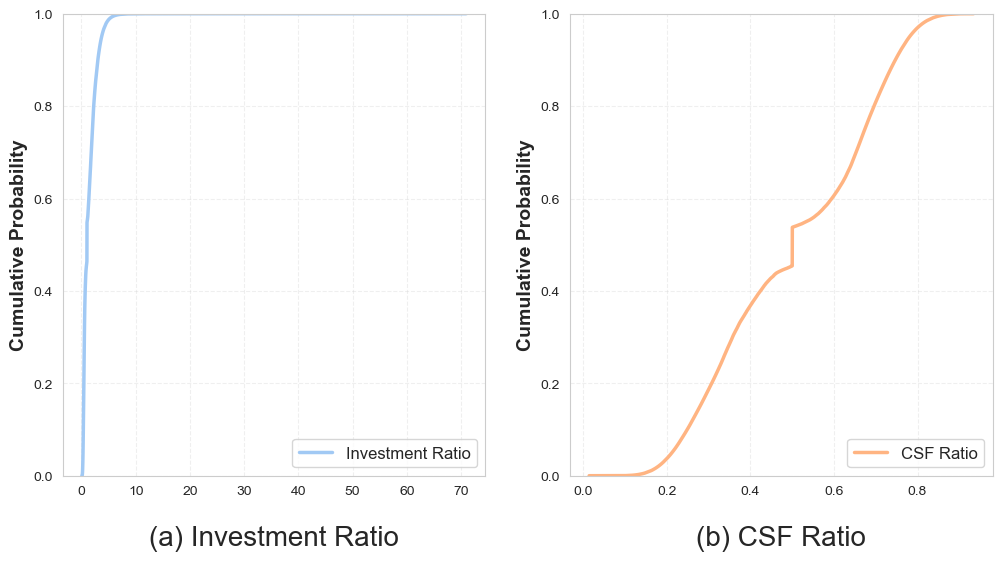

In [54]:
# ============================================================================
# Investment Ratio - CDF
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Extract Invested Resource Absolute values
t1_t2_investment_ratio = df_filtered['t1_fte_eq'] / df_filtered['t2_fte_eq']
csf_ratio_t1 = df_filtered['t1_fte_eq'] / (df_filtered['t1_fte_eq'] + df_filtered['t2_fte_eq'])

# Sort data for CDF
t1_t2_investment_ratio = np.sort(t1_t2_investment_ratio.dropna())
cdf_1 = np.arange(1, len(t1_t2_investment_ratio) + 1) / len(t1_t2_investment_ratio)
csf_ratio_t1 = np.sort(1 - csf_ratio_t1.dropna())
cdf_2 = np.arange(1, len(csf_ratio_t1) + 1) / len(csf_ratio_t1)

# Plot CDF
#first graph for investment ratio
ax1.plot(t1_t2_investment_ratio, cdf_1, label=f'Investment Ratio', color=COLOR_PALETTE[0], linewidth=2.5)

ax1.set_xlabel('')
ax1.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax1.set_title('')
ax1.legend(fontsize=12, loc='lower right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1])

ax1.text(0.5, -0.15, '(a) Investment Ratio',
             transform=ax1.transAxes,
             horizontalalignment='center',
             fontsize=20)

# second graph for csf ratio 
ax2.plot(csf_ratio_t1, cdf_2, label=f'CSF Ratio', color=COLOR_PALETTE[1], linewidth=2.5)

ax2.set_xlabel('')
ax2.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax2.set_title('')
ax2.legend(fontsize=12, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])
ax2.text(0.5, -0.15, '(b) CSF Ratio',
             transform=ax2.transAxes,
             horizontalalignment='center',
             fontsize=20)

### Length of game

In [55]:
# Score lengths and scoreline percentages (non-OT, using df_filtered/last_scores)

# Use existing per-game final scores if available, otherwise compute from df_filtered


scores = (
    df_filtered.sort_values(['game_id', 'round_number'])
    .groupby('game_id')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
)



# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)
canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]

# 3) Score lengths by team (winner-only), side by side
_length_t1 = scores.loc[t1_won_mask, 'total_rounds'].value_counts()
_length_t2 = scores.loc[t2_won_mask, 'total_rounds'].value_counts()
length_by_team = pd.DataFrame({
    f'{t1_label}_count': _length_t1,
    f'{t2_label}_count': _length_t2
}).fillna(0).astype(int).sort_index()
length_by_team[f'{t1_label}_pct'] = (length_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(5)
length_by_team[f'{t1_label}_cumulative_pct'] = length_by_team[f'{t1_label}_pct'].cumsum()
length_by_team[f'{t2_label}_pct'] = (length_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(5)
length_by_team[f'{t2_label}_cumulative_pct'] = length_by_team[f'{t2_label}_pct'].cumsum()

# 4) Canonical scorelines by team (winner-only), side by side
_canon_t1 = scores.loc[t1_won_mask, 'canon'].value_counts()
_canon_t2 = scores.loc[t2_won_mask, 'canon'].value_counts()
canon_by_team = pd.DataFrame({
    f'{t1_label}_count': _canon_t1,
    f'{t2_label}_count': _canon_t2
}).fillna(0).astype(int)

# Add percentages per team (normalize within each team's wins)
canon_by_team[f'{t1_label}_pct'] = (canon_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(5)
canon_by_team[f'{t2_label}_pct'] = (canon_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(5)
canon_by_team[f'{t1_label}_cumulative_pct'] = canon_by_team[f'{t1_label}_pct'].cumsum()
canon_by_team[f'{t2_label}_cumulative_pct'] = canon_by_team[f'{t2_label}_pct'].cumsum()

canon_overall['cumulative_pct'] = canon_overall['pct'].cumsum()


# Display
game_length_text = f"""Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):")
{canon_overall[['total_rounds','count', 'pct', 'cumulative_pct']].to_string()}

 Overall score lengths by team (winner-only): [{t1_label} vs {t2_label}]")
{length_by_team.to_string()}
"""
print(game_length_text)
exporter.export(game_length_text, title="Game Length and Scoreline Analysis")

Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):")
       total_rounds  count    pct  cumulative_pct
canon                                            
16:0             16    323   0.16            0.16
16:1             17    834   0.42            0.58
16:2             18   1776   0.89            1.47
16:3             19   2953   1.48            2.95
16:4             20   4819   2.41            5.36
16:5             21   6972   3.49            8.85
16:6             22   9425   4.71           13.56
16:7             23  11833   5.92           19.48
16:8             24  14330   7.17           26.65
16:9             25  16750   8.38           35.03
16:10            26  18798   9.40           44.43
16:11            27  20589  10.29           54.72
16:12            28  21805  10.90           65.62
16:13            29  22957  11.48           77.10
16:14            30  22983  11.49           88.59
19:15            34   6697   3.35           91.94
19:16            3

Cumulative Distribution Function - Score Margins
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


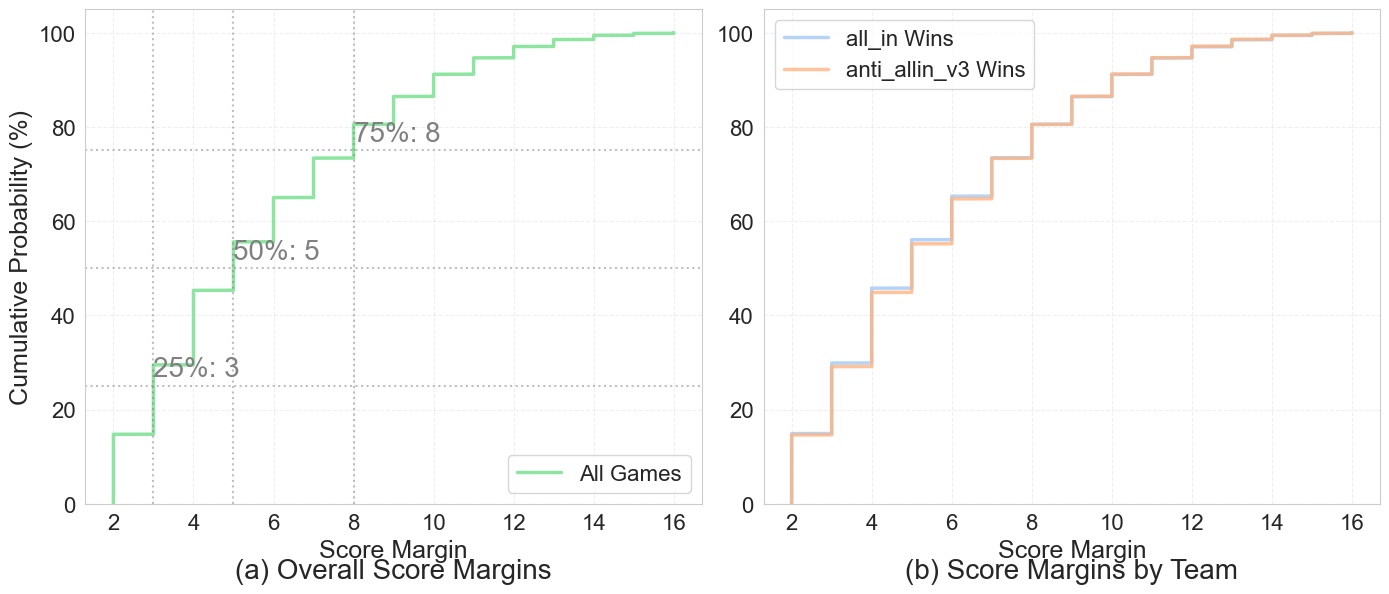


Score Margin CDF Statistics:
Overall Statistics:
  Median margin: 5.0
  25th percentile: 3.0
  75th percentile: 8.0
  Mean margin: 5.69
  Max margin: 16

all_in Wins:
  Median margin: 5.0
  25th percentile: 3.0
  75th percentile: 8.0
  Mean margin: 5.67

anti_allin_v3 Wins:
  Median margin: 5.0
  25th percentile: 3.0
  75th percentile: 8.0
  Mean margin: 5.70
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [56]:
# ============================================================================
# CUMULATIVE DISTRIBUTION FUNCTION (CDF) OF SCORE MARGINS
# ============================================================================


# Get final scores for each game
final_scores = df_filtered.groupby('game_id').agg(
    t1_final=('t1_score_end', 'last'),
    t2_final=('t2_score_end', 'last')
).reset_index()

# Create scoreline string for each game (higher score first for canonical)
final_scores['scoreline'] = final_scores.apply(
    lambda row: f"{int(row['t1_final'])}:{int(row['t2_final'])}", 
    axis=1
)

# Determine winner for each scoreline
final_scores['winner'] = final_scores.apply(
    lambda row: t1_label if row['t1_final'] > row['t2_final'] else t2_label, 
    axis=1
)

# Canonical scoreline (winner:loser)
final_scores['canonical_scoreline'] = final_scores.apply(
    lambda row: f"{int(max(row['t1_final'], row['t2_final']))}:{int(min(row['t1_final'], row['t2_final']))}", 
    axis=1
)

# Count occurrences
scoreline_counts = final_scores['scoreline'].value_counts().reset_index()
scoreline_counts.columns = ['scoreline', 'count']
scoreline_counts['percentage'] = (scoreline_counts['count'] / len(final_scores)) * 100

# Team-specific scorelines
t1_scorelines = final_scores[final_scores['winner'] == t1_label]['canonical_scoreline'].value_counts().reset_index()
t1_scorelines.columns = ['scoreline', 'count']
t1_scorelines['percentage'] = (t1_scorelines['count'] / len(final_scores[final_scores['winner'] == t1_label])) * 100

t2_scorelines = final_scores[final_scores['winner'] == t2_label]['canonical_scoreline'].value_counts().reset_index()
t2_scorelines.columns = ['scoreline', 'count']
t2_scorelines['percentage'] = (t2_scorelines['count'] / len(final_scores[final_scores['winner'] == t2_label])) * 100

# Canonical scoreline distribution (overall)
canonical_counts = final_scores['canonical_scoreline'].value_counts().reset_index()
canonical_counts.columns = ['scoreline', 'count']
canonical_counts['percentage'] = (canonical_counts['count'] / len(final_scores)) * 100


# Calculate score margins (winner - loser)
final_scores['score_margin'] = final_scores.apply(
    lambda row: abs(row['t1_final'] - row['t2_final']), 
    axis=1
)

# Calculate score margins for each team (maintaining sign: positive = team wins)
final_scores['t1_margin'] = final_scores['t1_final'] - final_scores['t2_final']
final_scores['t2_margin'] = final_scores['t2_final'] - final_scores['t1_final']

# Overall score margin distribution
overall_margins = final_scores['score_margin'].sort_values()
overall_cdf = np.arange(1, len(overall_margins) + 1) / len(overall_margins) * 100

# Team 1 wins - score margins
t1_wins = final_scores[final_scores['winner'] == t1_label]
t1_margins = t1_wins['score_margin'].sort_values()
t1_cdf = np.arange(1, len(t1_margins) + 1) / len(t1_margins) * 100

# Team 2 wins - score margins
t2_wins = final_scores[final_scores['winner'] == t2_label]
t2_margins = t2_wins['score_margin'].sort_values()
t2_cdf = np.arange(1, len(t2_margins) + 1) / len(t2_margins) * 100

# Create CDF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Overall CDF of Score Margins
axes[0].plot(overall_margins, overall_cdf, linewidth=2.5, color=COLOR_PALETTE[2], label='All Games')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlabel('Score Margin', fontsize=18)
axes[0].set_ylabel('Cumulative Probability (%)', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].legend(fontsize=16)
axes[0].set_ylim(0, 105)

# Add reference lines for common percentiles
for pct in [25, 50, 75]:
    idx = int(len(overall_margins) * pct / 100)
    if idx < len(overall_margins):
        margin_val = overall_margins.iloc[idx]
        axes[0].axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
        axes[0].axvline(x=margin_val, color='gray', linestyle=':', alpha=0.5)
        axes[0].text(margin_val, pct + 2, f'{pct}%: {margin_val:.0f}', fontsize=20, color='gray')

# Add subplot label
axes[0].text(0.5, -0.15, '(a) Overall Score Margins',
                transform=axes[0].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Plot 2: Team-specific CDFs (overlaid)
axes[1].plot(t1_margins, t1_cdf, linewidth=2.5, color=COLOR_PALETTE[0], label=f'{t1_label} Wins', alpha=0.8)
axes[1].plot(t2_margins, t2_cdf, linewidth=2.5, color=COLOR_PALETTE[1], label=f'{t2_label} Wins', alpha=0.8)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlabel('Score Margin', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].legend(fontsize=16)
axes[1].set_ylim(0, 105)

# Add subplot label
axes[1].text(0.5, -0.15, '(b) Score Margins by Team',
                transform=axes[1].transAxes,
                horizontalalignment='center',
                fontsize=20)


# Print title before showing figure
print("Cumulative Distribution Function - Score Margins")

plt.tight_layout()

# Export and display
exporter.export("Cumulative Distribution Function - Score Margins", title="Figure Title")
exporter.export(fig, title="Cumulative Distribution Function - Score Margins")
plt.show()

# Print statistics
print(f"\nScore Margin CDF Statistics:")
print(f"{'='*70}")
print(f"Overall Statistics:")
print(f"  Median margin: {overall_margins.median():.1f}")
print(f"  25th percentile: {overall_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {overall_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {overall_margins.mean():.2f}")
print(f"  Max margin: {overall_margins.max():.0f}")
print(f"\n{t1_label} Wins:")
print(f"  Median margin: {t1_margins.median():.1f}")
print(f"  25th percentile: {t1_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {t1_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {t1_margins.mean():.2f}")
print(f"\n{t2_label} Wins:")
print(f"  Median margin: {t2_margins.median():.1f}")
print(f"  25th percentile: {t2_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {t2_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {t2_margins.mean():.2f}")
print(f"{'='*70}")

# Export text summary
cdf_summary = f"""Score Margin CDF Statistics
{'='*70}
Overall Statistics:
  Median margin: {overall_margins.median():.1f}
  25th percentile: {overall_margins.quantile(0.25):.1f}
  75th percentile: {overall_margins.quantile(0.75):.1f}
  Mean margin: {overall_margins.mean():.2f}
  Max margin: {overall_margins.max():.0f}

{t1_label} Wins:
  Median margin: {t1_margins.median():.1f}
  25th percentile: {t1_margins.quantile(0.25):.1f}
  75th percentile: {t1_margins.quantile(0.75):.1f}
  Mean margin: {t1_margins.mean():.2f}

{t2_label} Wins:
  Median margin: {t2_margins.median():.1f}
  25th percentile: {t2_margins.quantile(0.25):.1f}
  75th percentile: {t2_margins.quantile(0.75):.1f}
  Mean margin: {t2_margins.mean():.2f}
{'='*70}
"""

exporter.export(cdf_summary, title="CDF Summary Statistics")

## Way to win - Calculation & Visualization

Refactored calculation with helper functions for better readability, plus Sankey and Graphviz visualizations.

In [57]:
# ============================================================================
# IMPROVED CALCULATION - Cleaner, more modular code
# ============================================================================

def extract_game_ids(df, team_col, round_num, condition=None):
    """Extract game IDs for specific round outcomes"""
    if condition is None:
        mask = (df[team_col] == True) & (df['round_number'] == round_num)
    else:
        mask = condition & (df['round_number'] == round_num)
    return set(df[mask]['game_id'])

def calculate_branch_counts(parent_games, *filters):
    """Calculate counts for multiple branches from a parent set"""
    results = []
    for filter_games in filters:
        count = len(parent_games & filter_games)
        results.append(count)
    return results

# Extract base round outcomes
print("Extracting game outcomes...")
total_games = df_filtered['game_id'].nunique()

# R1 outcomes
t1_r1_win = extract_game_ids(df_filtered, 'is_t1_winner', 1)
t2_r1_win = set(df_filtered[df_filtered['round_number'] == 1]['game_id']) - t1_r1_win

# R2 outcomes
t1_r2_win = extract_game_ids(df_filtered, 'is_t1_winner', 2)
t2_r2_win = set(df_filtered[df_filtered['round_number'] == 2]['game_id']) - t1_r2_win

# R15 lead/behind (at end of first half)
t1_r15_lead = extract_game_ids(df_filtered, None, 15, 
                               df_filtered['t1_score_end'] > df_filtered['t2_score_end'])
t2_r15_lead = extract_game_ids(df_filtered, None, 15,
                               df_filtered['t2_score_end'] > df_filtered['t1_score_end'])

# R16 outcomes
t1_r16_win = extract_game_ids(df_filtered, 'is_t1_winner', 16)
t2_r16_win = set(df_filtered[df_filtered['round_number'] == 16]['game_id']) - t1_r16_win

# R17 outcomes
t1_r17_win = extract_game_ids(df_filtered, 'is_t1_winner', 17)
t2_r17_win = set(df_filtered[df_filtered['round_number'] == 17]['game_id']) - t1_r17_win

# Final game outcomes
game_scores = df_filtered.groupby('game_id')[['t1_score_end','t2_score_end', 'is_t1_winner', 'round_number']].max()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)

# ============================================================================
# Calculate all branch counts using helper functions
# ============================================================================

 

# Level 1: R1 split
r1_counts = {
    't1_wins': len(t1_r1_win),
    't2_wins': len(t2_r1_win)
}

# Level 2: R2 outcomes for each R1 branch
t1_r2_branches = calculate_branch_counts(t1_r1_win, t1_r2_win, t2_r2_win)
t2_r2_branches = calculate_branch_counts(t2_r1_win, t2_r2_win, t1_r2_win)

# Level 3: R15 outcomes for each R2 branch
# T1 R1 win -> T1 R2 win
t1r1w_t1r2w = t1_r1_win & t1_r2_win
t1r1w_t1r2w_r15 = calculate_branch_counts(t1r1w_t1r2w, t1_r15_lead, t2_r15_lead)

# T1 R1 win -> T1 R2 loss
t1r1w_t1r2l = t1_r1_win & t2_r2_win
t1r1w_t1r2l_r15 = calculate_branch_counts(t1r1w_t1r2l, t1_r15_lead, t2_r15_lead)

# T2 R1 win -> T2 R2 win
t2r1w_t2r2w = t2_r1_win & t2_r2_win
t2r1w_t2r2w_r15 = calculate_branch_counts(t2r1w_t2r2w, t2_r15_lead, t1_r15_lead)

# T2 R1 win -> T2 R2 loss
t2r1w_t2r2l = t2_r1_win & t1_r2_win
t2r1w_t2r2l_r15 = calculate_branch_counts(t2r1w_t2r2l, t2_r15_lead, t1_r15_lead)

# Level 4: R16 outcomes for each R15 branch
# T1 paths
t1_r16_branches = calculate_branch_counts(t1_r15_lead, t1_r16_win, t2_r16_win)
# T2 paths
t2_r16_branches = calculate_branch_counts(t2_r15_lead, t2_r16_win, t1_r16_win)

#Level 5: R17 outcomes for each R16 Branch
#T1 Path
t1h1l_r16w = t1_r15_lead & t1_r16_win
t1h1l_t1r16w_r17 = calculate_branch_counts(t1h1l_r16w, t1_r17_win, t2_r17_win)

t1h1l_r16l = t1_r15_lead & t2_r16_win
t1h1l_t1r16l_r17 = calculate_branch_counts(t1h1l_r16l, t1_r17_win, t2_r17_win)

#T2 Path
t2h1l_r16w = t2_r15_lead & t2_r16_win
t2h1l_t2r16w_r17 = calculate_branch_counts(t2h1l_r16w, t2_r17_win, t1_r17_win)

t2h1l_r16l = t2_r15_lead & t1_r16_win
t2h1l_t2r16l_r17 = calculate_branch_counts(t2h1l_r16l, t2_r17_win, t1_r17_win)

# Level 5: Final outcomes for each R17 branch
# T1 R2 win paths
t1_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t1h1l_r16w & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t1h1l_r16w & t2_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t1h1l_r16l & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t1h1l_r16l & t2_r17_win, t1_overall_win, t2_overall_win),
}

# T2 final paths
t2_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t2h1l_r16w & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t2h1l_r16w & t1_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t2h1l_r16l & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t2h1l_r16l & t1_r17_win, t2_overall_win, t1_overall_win),
}






Extracting game outcomes...


Not used for now

In [58]:
# ============================================================================
# SANKEY DIAGRAM - Interactive flow visualization
# ============================================================================


# import plotly.graph_objects as go

# def create_sankey_data():
#     """Build Sankey diagram source/target/value arrays"""
    
#     # Node labels (indexed)
#     labels = [
#         "All Games",  # 0
        
#         # R1 level
#         "T1 WIN R1", "T2 WIN R1",  # 1, 2
        
#         # R2 level - T1 path
#         "T1 WIN R2", "T1 LOSE R2",  # 3, 4
#         # R2 level - T2 path
#         "T2 WIN R2", "T2 LOSE R2",  # 5, 6
        
#         # R15 level - T1 win
#         "T1 AHEAD First Half",   # 7, 
#         # R15 level - T2 loss
#         "T2 AHEAD First Half",   # 8, 
        
#         # R16 level - T1 paths (2 nodes)
#         "T1 WIN R16", "T1 LOSE R16",  # 9, 10
        
#         # R16 level - T2 paths (2 nodes)
#         "T2 WIN R16", "T2 LOSE R16",  # 11, 12

        
#         # R17 level - T1 paths (4 nodes)
#         "T1 WIN R17 (Lead,R16W)", "T1 LOSE R17 (Lead,R16W)",  # 13, 14
#         "T1 WIN R17 (Lead,R16L)", "T1 LOSE R17 (Lead,R16L)",  # 15, 16
        
#         # R17 level - T2 paths (4 nodes)
#         "T2 WIN R17 (Lead,R16W)", "T2 LOSE R17 (Lead,R16W)",  # 17, 18
#         "T2 WIN R17 (Lead,R16L)", "T2 LOSE R17 (Lead,R16L)",  # 19, 20

#         # Final outcomes - T1 (4 nodes)
#         "T1 WIN (R15Lead,R16W,R17W)", #21
#         "T1 WIN (R15Lead,R16W,R17L)", #22
#         "T1 WIN (R15Lead,R16L,R17W)", #23
#         "T1 WIN (R15Lead,R16L,R17L)", #24

#         # Final outcomes - T2 (8 nodes)
#         "T2 WIN (R15Lead,R16W,R17W)", #25
#         "T2 WIN (R15Lead,R16W,R17L)", #26
#         "T2 WIN (R15Lead,R16L,R17W)", #27
#         "T2 WIN (R15Lead,R16L,R17L)", #28
#     ]
    
#     sources = []
#     targets = []
#     values = []
    
#     # Root to R1
#     sources.extend([0, 0])
#     targets.extend([1, 2])
#     values.extend([r1_counts['t1_wins'], r1_counts['t2_wins']])
    
#     # R1 to R2
#     sources.extend([1, 1, 2, 2])
#     targets.extend([3, 4, 5, 6])
#     values.extend(t1_r2_branches + t2_r2_branches)
    
#     # R2 to R15 - Merge paths - Lead
#     sources.extend([3, 3, 4, 4, 5, 5, 6, 6])
#     targets.extend([7, 8, 7, 8, 8, 7, 8, 7])
#     values.extend(t1r1w_t1r2w_r15 + t1r1w_t1r2l_r15 + t2r1w_t2r2w_r15 + t2r1w_t2r2l_r15)
    
#     # R15 to R16 
#     sources.extend([7, 7, 8, 8])
#     targets.extend([9, 10, 11, 12])
#     values.extend(t1_r16_branches + t2_r16_branches)
    
#     # R16 to R17 - T1 paths
#     sources.extend([9, 9, 10, 10])
#     targets.extend([13, 14, 15, 16])
#     values.extend(t1h1l_t1r16w_r17 + t1h1l_t1r16l_r17)

#     # R16 to R17 - T2 paths
#     sources.extend([11, 11, 12, 12])
#     targets.extend([17, 18, 19, 20])
#     values.extend(t2h1l_t2r16w_r17 + t2h1l_t2r16l_r17)
    
#     # R17 to Final - T1 paths
#     t1_r17_indices = [13, 13, 14, 14, 15, 15, 16, 16]
#     t1_final_indices = [21, 25, 22, 26, 23, 27, 24, 28]
#     sources.extend(t1_r17_indices)
#     targets.extend(t1_final_indices)
#     t1_final_values = [v for path_counts in t1_final_counts.values() for v in path_counts]
#     values.extend(t1_final_values)
    
#     # R16 to Final - T2 paths
#     t2_r17_indices = [17, 17, 18, 18, 19, 19, 20, 20]
#     t2_final_indices = [25, 21, 26, 22, 27, 23, 28, 24]
#     sources.extend(t2_r17_indices)
#     targets.extend(t2_final_indices)
#     t2_final_values = [v for path_counts in t2_final_counts.values() for v in path_counts]
#     values.extend(t2_final_values)
    
#     return labels, sources, targets, values

# # Create Sankey diagram
# print("Building Sankey diagram...")
# labels, sources, targets, values = create_sankey_data()

# # Color scheme
# node_colors = []
# for label in labels:
#     if "T1 WIN" in label or "T1 AHEAD" in label:
#         node_colors.append("rgba(73, 245, 39, 0.8)")  # Green
#     elif "T1 LOSE" in label or "T1 BEHIND" in label:
#         node_colors.append("rgba(245, 155, 39, 0.8)")  # Orange
#     elif "T2 WIN" in label or "T2 AHEAD" in label:
#         node_colors.append("rgba(39, 52, 245, 0.8)")  # Blue
#     elif "T2 LOSE" in label or "T2 BEHIND" in label:
#         node_colors.append("rgba(245, 39, 228, 0.8)")  # Purple
#     elif "All Games" in label or "T1" in label or "T2" in label:
#         node_colors.append("rgba(39, 245, 232, 0.8)")  # Turquoise
#     else:
#         node_colors.append("rgba(223, 230, 233, 0.8)")  # Gray

# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=15,
#         thickness=20,
#         line=dict(color="black", width=0.5),
#         label=labels,
#         color=node_colors
#     ),
#     link=dict(
#         source=sources,
#         target=targets,
#         value=values,
#         color="rgba(200, 200, 200, 0.4)"
#     )
# )])

# fig.update_layout(
#     title=dict(
#         text="Game Progression Flow - Sankey Diagram<br><sub>Width represents number of games flowing through each path</sub>",
#         font=dict(size=20, family="Arial Black")
#     ),
#     font=dict(size=10),
#     height=1200,
#     width=1600,
# )

# fig.show()
# exporter.export(fig, title="Game Progression Flow - Sankey Diagram")

# TODO: This graph can be improved. noteably, the last part is very chaotic. 
# Also potentially do not include category lose, instead only use t1 win/t2 win 
# and improve ordering of the bars (t1 top, t2 bottom)

### Heatmap of score progression

In [59]:
# Step 1: Create temporary dataframe - count occurrences per unique round number
round_counts_temp = df_filtered.groupby('round_number').size().reset_index(name='total_occurrences')

# Step 2: Create permanent dataframe - for each round number and scoreline, count occurrences
# Create scoreline column (e.g., "10-5" format)
df_filtered['scoreline'] = df_filtered['t1_score_end'].astype(str) + '-' + df_filtered['t2_score_end'].astype(str)

# Group by round_number and scoreline to get occurrence counts
scoreline_by_round_df = df_filtered.groupby(['round_number', 'scoreline', 't1_score_end', 't2_score_end']).size().reset_index(name='scoreline_occurrences')

# Step 3: Merge with round counts to calculate percentages
scoreline_by_round_df = scoreline_by_round_df.merge(
    round_counts_temp[['round_number', 'total_occurrences']], 
    on='round_number', 
    how='left'
)

# Calculate percentage
scoreline_by_round_df['percentage'] = (scoreline_by_round_df['scoreline_occurrences'] / 
                                        scoreline_by_round_df['total_occurrences'] * 100)

# Sort for better readability
scoreline_by_round_df = scoreline_by_round_df.sort_values(['round_number', 'scoreline_occurrences'], ascending=[True, False])


✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


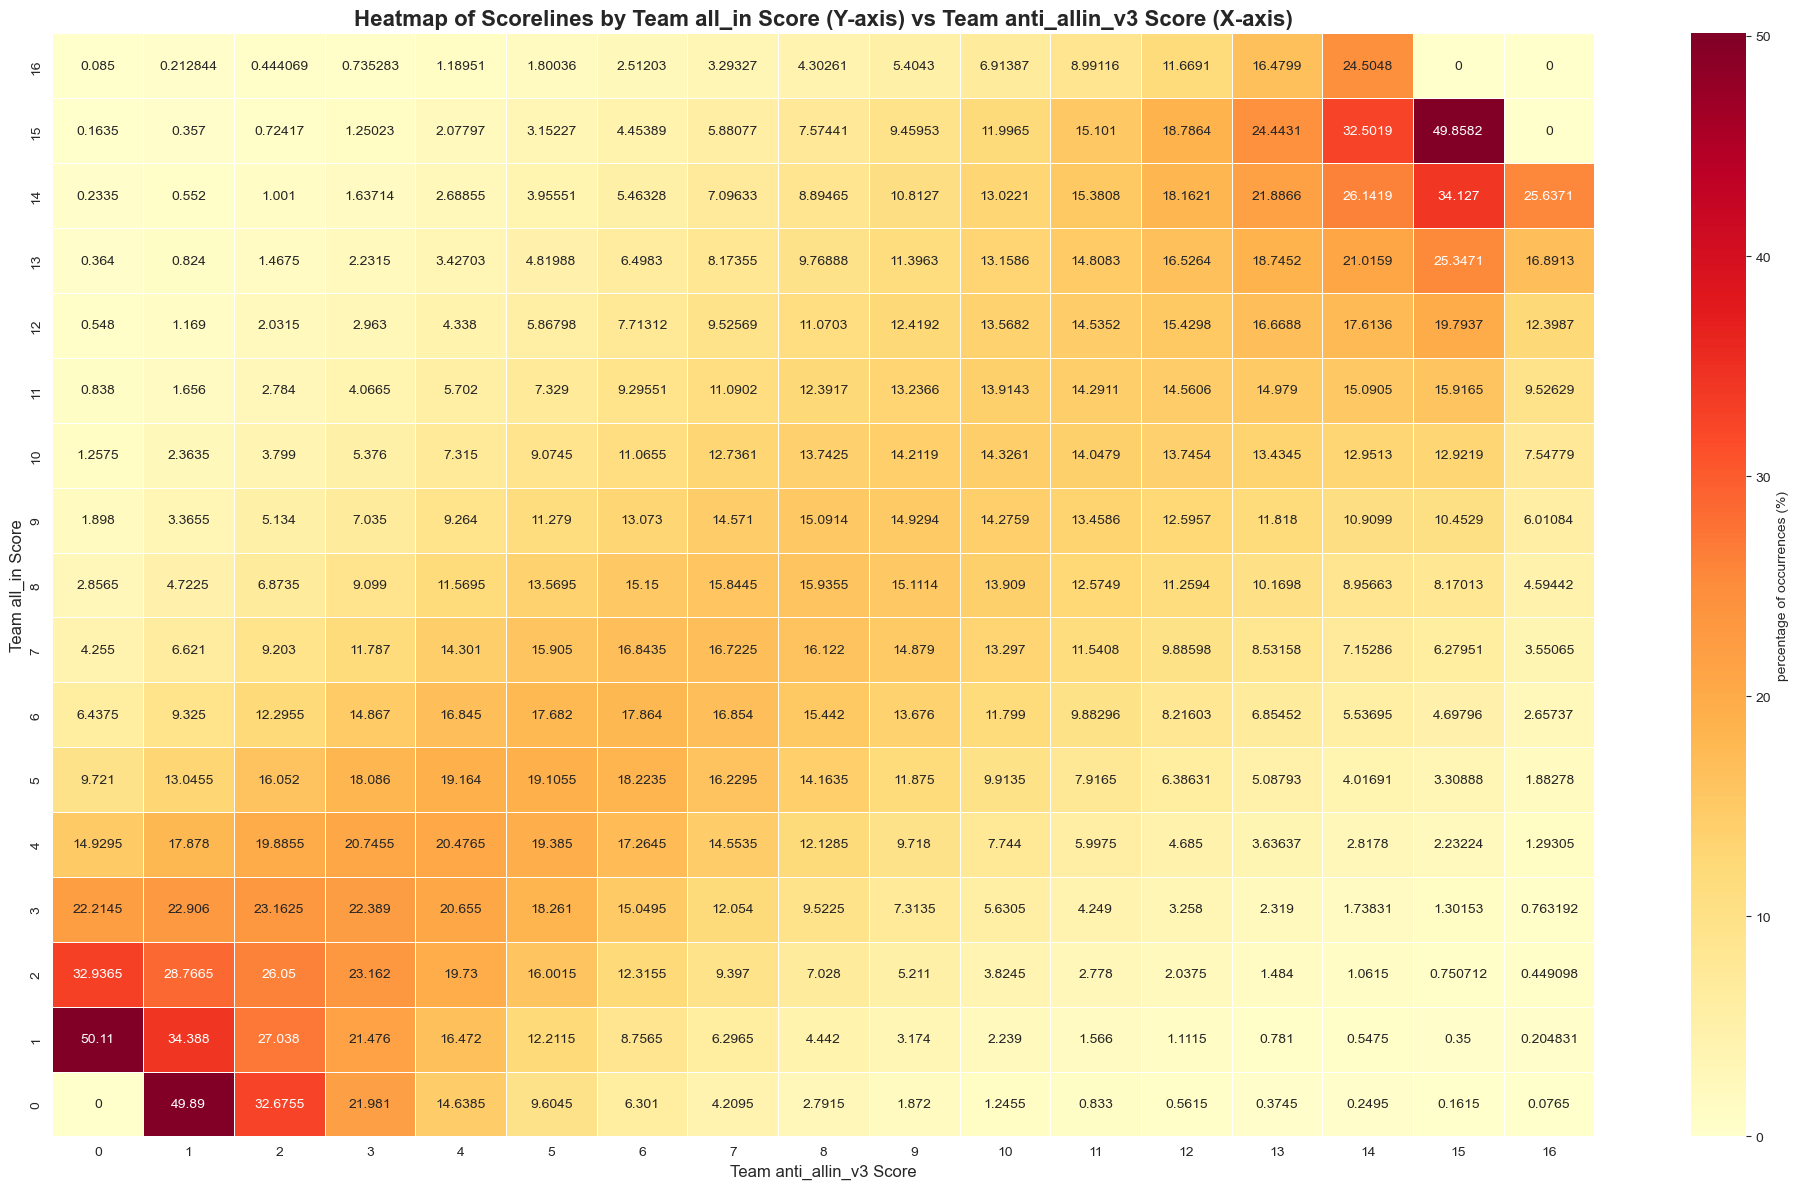

In [60]:
# Create a pivot table for the heatmap
# We'll use round_number as x-axis and scoreline as y-axis, with scoreline_occurrences as values
heatmap_data = scoreline_by_round_df[scoreline_by_round_df['round_number'] < 31][['t1_score_end', 't2_score_end', 'percentage']]

# Create pivot table using t1_score_end and t2_score_end
pivot_data = heatmap_data.pivot_table(
    index='t1_score_end',
    columns='t2_score_end',
    values='percentage',
    aggfunc='sum',
    fill_value=0
)

# Sort by index and columns
pivot_data = pivot_data.sort_index(ascending=False).sort_index(axis=1, ascending=True)

# Create the heatmap
fig = plt.figure(figsize=(20, 12))
sns.heatmap(pivot_data, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='g',
            cbar_kws={'label': 'percentage of occurrences (%)'},
            linewidths=0.5)

plt.title(f'Heatmap of Scorelines by Team {t1_label} Score (Y-axis) vs Team {t2_label} Score (X-axis)', fontsize=16, fontweight='bold')
plt.xlabel(f'Team {t2_label} Score', fontsize=12)
plt.ylabel(f'Team {t1_label} Score', fontsize=12)
plt.tight_layout()

# Export BEFORE showing
exporter.export(fig, title="Scoreline Heatmap - T1 vs T2")
plt.show()

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


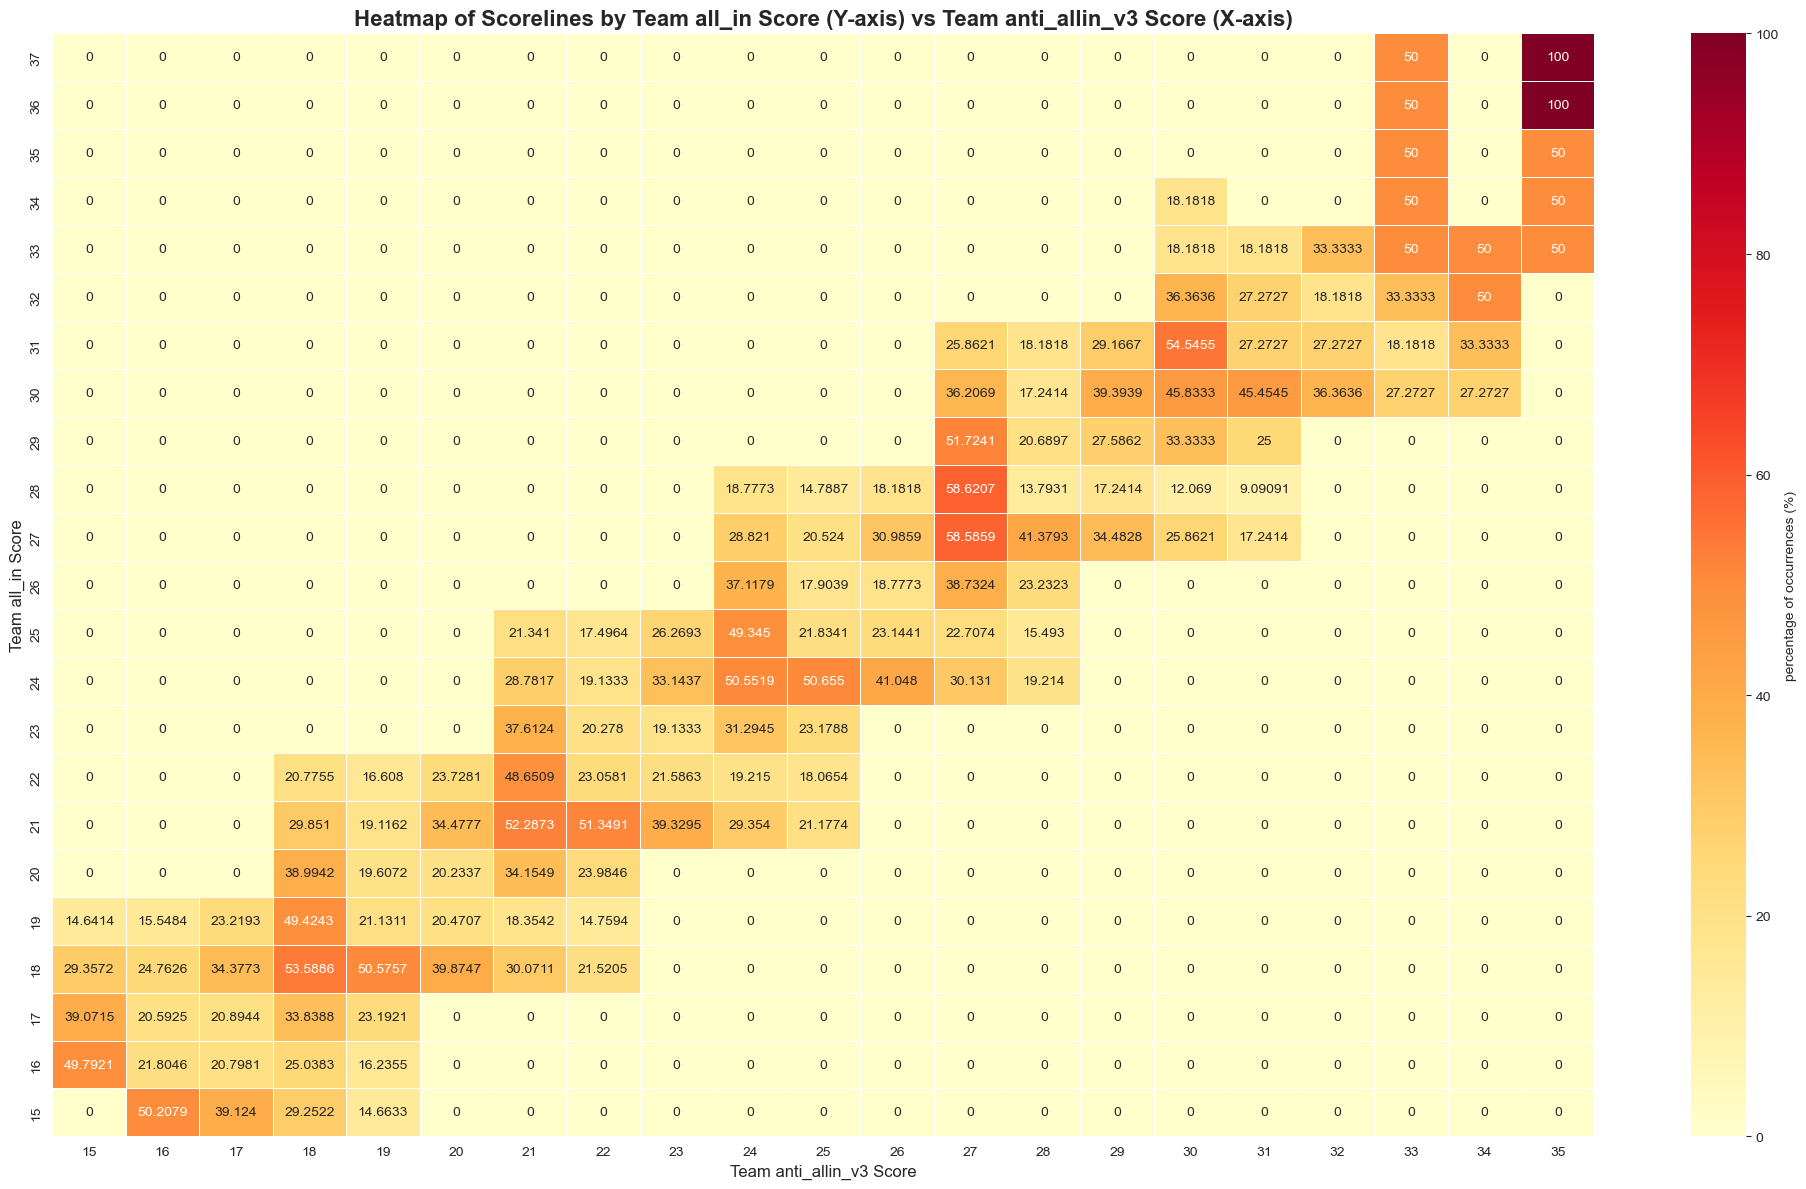

In [61]:
if INCLUDE_OT_GAMES:
    # Check if any OT games exist
    ot_data = scoreline_by_round_df[scoreline_by_round_df['round_number'] > 30]
    
    if len(ot_data) == 0:
        print("⚠️ No overtime games found in this matchup. Skipping OT scoreline heatmap.")
    else:
        # Create a pivot table for the heatmap
        # We'll use round_number as x-axis and scoreline as y-axis, with scoreline_occurrences as values
        heatmap_data = ot_data[['t1_score_end', 't2_score_end', 'percentage']].copy()
    
        # Create pivot table using t1_score_end and t2_score_end
        pivot_data = heatmap_data.pivot_table(
            index='t1_score_end',
            columns='t2_score_end',
            values='percentage',
            aggfunc='sum',
            fill_value=0
        )
    
        # Sort by index and columns
        pivot_data = pivot_data.sort_index(ascending=False).sort_index(axis=1, ascending=True)
    
        # Create the heatmap
        fig = plt.figure(figsize=(20, 12))
        sns.heatmap(pivot_data, 
                    cmap='YlOrRd', 
                    annot=True, 
                    fmt='g',
                    cbar_kws={'label': 'percentage of occurrences (%)'},
                    linewidths=0.5)
    
        plt.title(f'Heatmap of Scorelines by Team {t1_label} Score (Y-axis) vs Team {t2_label} Score (X-axis)', fontsize=16, fontweight='bold')
        plt.xlabel(f'Team {t2_label} Score', fontsize=12)
        plt.ylabel(f'Team {t1_label} Score', fontsize=12)
        plt.tight_layout()
    
        # Export BEFORE showing
        exporter.export(fig, title="OT Scoreline Heatmap - T1 vs T2")
        plt.show()
else:
    print("⚠️ OT games are excluded by configuration (INCLUDE_OT_GAMES = False).")

### progression of all scoreline in sankey
#### TODO: this needs to be fixed, terrible graph

In [62]:
import plotly.graph_objects as go
import re

#TODO: improve node positioning to reduce overlap and improve clarity

# Create scoreline progression data
# For each game, track the scoreline after each round
# df_sorted = df_filtered.sort_values(['game_id', 'round_number'])

# # Build transitions from one round to the next
# transitions = []
# for game_id, game_data in df_sorted.groupby('game_id'):
#     game_data = game_data.sort_values('round_number')
#     prev_scoreline = "Start 0-0"
#     prev_round = 0
    
#     for idx, row in game_data.iterrows():
#         curr_scoreline = f"R{row['round_number']} {row['t1_score_end']}-{row['t2_score_end']}"
#         transitions.append({
#             'source': prev_scoreline,
#             'target': curr_scoreline,
#             'round_from': prev_round,
#             'round_to': row['round_number']
#         })
#         prev_scoreline = curr_scoreline
#         prev_round = row['round_number']

# # Count transitions
# transition_counts = pd.DataFrame(transitions).groupby(['source', 'target']).size().reset_index(name='count')

# # Create node labels (unique scorelines)
# all_nodes = list(set(transition_counts['source'].tolist() + transition_counts['target'].tolist()))

# # Function to extract scores and calculate sort key
# def get_sort_key(node_label):
#     """Extract t1_score and t2_score from node label and return sort key"""
#     if node_label == "Start 0-0":
#         return (0, 0, 0)  # Start in middle
    
#     # Extract round number and scores using regex
#     match = re.match(r"R(\d+)\s+(\d+)-(\d+)", node_label)
#     if match:
#         round_num = int(match.group(1))
#         t1_score = int(match.group(2))
#         t2_score = int(match.group(3))
#         score_diff = t1_score - t2_score  # Positive = T1 winning, Negative = T2 winning
#         return (round_num, -score_diff, t1_score)  # Sort by round, then by score diff (negative for top-to-bottom), then by t1_score
#     return (0, 0, 0)

# # Sort nodes by score difference (higher T1 scores at top, higher T2 scores at bottom)
# all_nodes_with_keys = [(node, get_sort_key(node)) for node in all_nodes]
# all_nodes_with_keys.sort(key=lambda x: x[1])
# all_nodes_sorted = [node for node, key in all_nodes_with_keys]

# Create node dict with sorted order
# node_dict = {node: idx for idx, node in enumerate(all_nodes_sorted)}

# Group nodes by round and assign evenly distributed y-coordinates within each round
# This prevents overlapping

# nodes_by_round = {}
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     if round_num not in nodes_by_round:
#         nodes_by_round[round_num] = []
#     nodes_by_round[round_num].append((node, -neg_score_diff))  # Store node with score_diff

# Assign y-coordinates - distribute nodes evenly within each round based on their score diff order
# node_y_coords = []
# node_x_coords = []
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     score_diff = -neg_score_diff
    
#     # Get nodes in this round sorted by score difference
#     round_nodes = sorted(nodes_by_round[round_num], key=lambda x: x[1], reverse=True)
#     num_nodes_in_round = len(round_nodes)
    
#     # Find index of current node in this round
#     node_index = next(i for i, (n, sd) in enumerate(round_nodes) if n == node)
    
#     # Distribute nodes evenly from 0 to 1 with padding
#     if num_nodes_in_round == 1:
#         y_coord = 0.5
#     else:
#         # Add padding margins (5% top and bottom)
#         y_coord = 0.05 + (node_index / (num_nodes_in_round - 1)) * 0.9
    
#     node_y_coords.append(y_coord)
    
#     # X-coordinate based on round number
#     if node == "Start 0-0":
#         x_coord = 0.0
#     else:
#         x_coord = round_num / 30  # Normalize to 0-1 range
#     node_x_coords.append(x_coord)

# # Create source, target, value lists for Sankey
# sources = [node_dict[src] for src in transition_counts['source']]
# targets = [node_dict[tgt] for tgt in transition_counts['target']]
# values = transition_counts['count'].tolist()

# Create Sankey diagram with positioned nodes

# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=5,
#         thickness=10,
#         line=dict(color="black", width=0.5),
#         label=all_nodes_sorted,
#         color="lightblue",
#         x=node_x_coords,
#         y=node_y_coords
#     ),
#     link=dict(
#         source=sources,
#         target=targets,
#         value=values
#     )
# )])

# fig.update_layout(
#     title_text="Scoreline Progression Through All Rounds (Top: T1 Winning, Bottom: T2 Winning)",
#     font_size=10,
#     height=2000,
#     width=2400,
# )
# fig.show()

#  Total unique scorelines: {len(all_nodes_sorted)}")
#  Total transitions: {len(transition_counts)}")

### Round win vs Game win percentage

Round Win % vs Game Win %


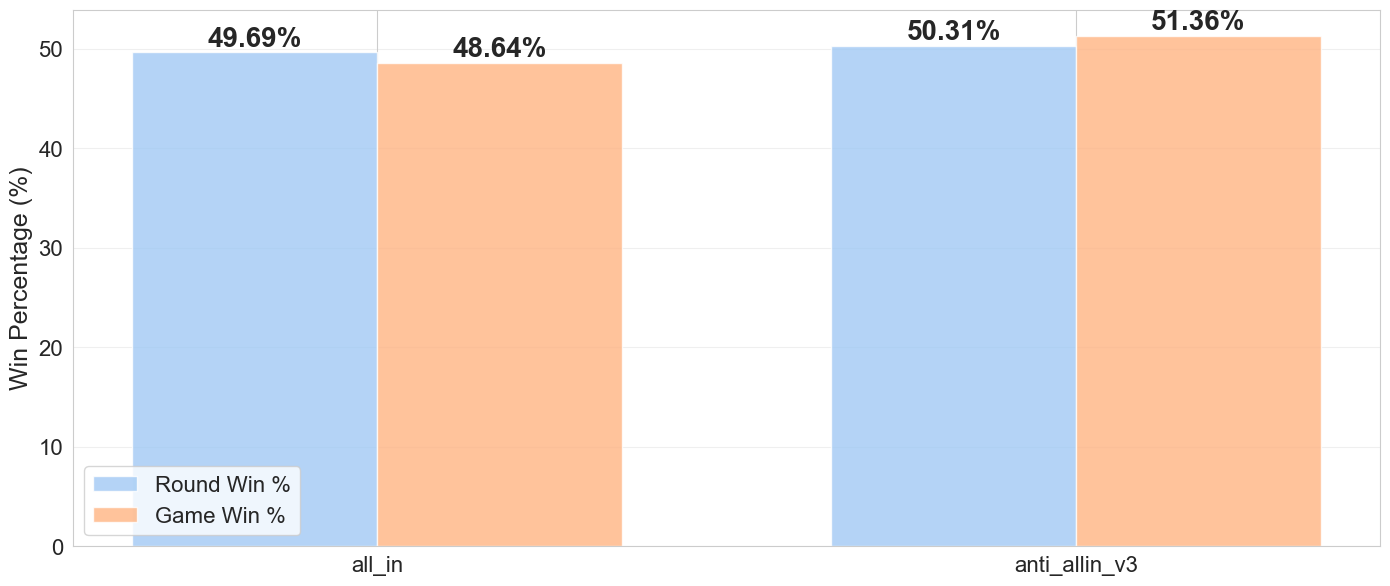

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
Round Win vs Game Win Comparison
         Team  Round Win %  Round Wins  Game Win %  Game Wins  Difference (Round - Game %)
       all_in     49.68881     2705026     48.6425      97285                      1.04631
anti_allin_v3     50.31119     2738908     51.3575     102715                     -1.04631
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [63]:
# Calculate round win percentages and game win percentages for both teams

# Round-level statistics
total_rounds = len(df_filtered)
t1_rounds_won = df_filtered['is_t1_winner'].sum()
t2_rounds_won = total_rounds - t1_rounds_won

t1_round_win_pct = (t1_rounds_won / total_rounds) * 100
t2_round_win_pct = (t2_rounds_won / total_rounds) * 100

# Game-level statistics
t1_games_won = len(t1_overall_win)
t2_games_won = len(t2_overall_win)

t1_game_win_pct = (t1_games_won / total_games) * 100
t2_game_win_pct = (t2_games_won / total_games) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Team': [t1_label, t2_label],
    'Round Win %': [t1_round_win_pct, t2_round_win_pct],
    'Round Wins': [t1_rounds_won, t2_rounds_won],
    'Game Win %': [t1_game_win_pct, t2_game_win_pct],
    'Game Wins': [t1_games_won, t2_games_won],
    'Difference (Round - Game %)': [t1_round_win_pct - t1_game_win_pct, 
                                     t2_round_win_pct - t2_game_win_pct]
})


# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Bar chart comparing percentages
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Round Win %'], width, label='Round Win %', alpha=0.8, color=COLOR_PALETTE[0])
bars2 = ax.bar(x + width/2, comparison_df['Game Win %'], width, label='Game Win %', alpha=0.8, color=COLOR_PALETTE[1])

ax.set_ylabel('Win Percentage (%)', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Team'])
ax.legend(fontsize=16)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=20, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Print title before showing figure
print("Round Win % vs Game Win %")

plt.tight_layout()
plt.show()

exporter.export("Round Win % vs Game Win %", title="Figure Title")
exporter.export(fig, title="Round Win % vs Game Win %")

# Export comparison stats
comparison_text = f"""Round Win vs Game Win Comparison
{'='*80}
{comparison_df.to_string(index=False)}
{'='*80}"""

print(comparison_text)

exporter.export(comparison_text, title="Round vs Game Win Statistics")

ROUND WIN % vs GAME WIN % (EXCLUDING ALL OT GAMES)

Total games analyzed: 177147 (excluded 22853 OT games)
Total rounds analyzed: 4602826
OT games excluded: 22853 (11.43% of all games)

         Team  Round Win %  Round Wins  Game Win %  Game Wins  Difference (Round - Game %)
       all_in    49.635376     2284630   48.492495      85903                     1.142881
anti_allin_v3    50.364624     2318196   51.507505      91244                    -1.142881

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


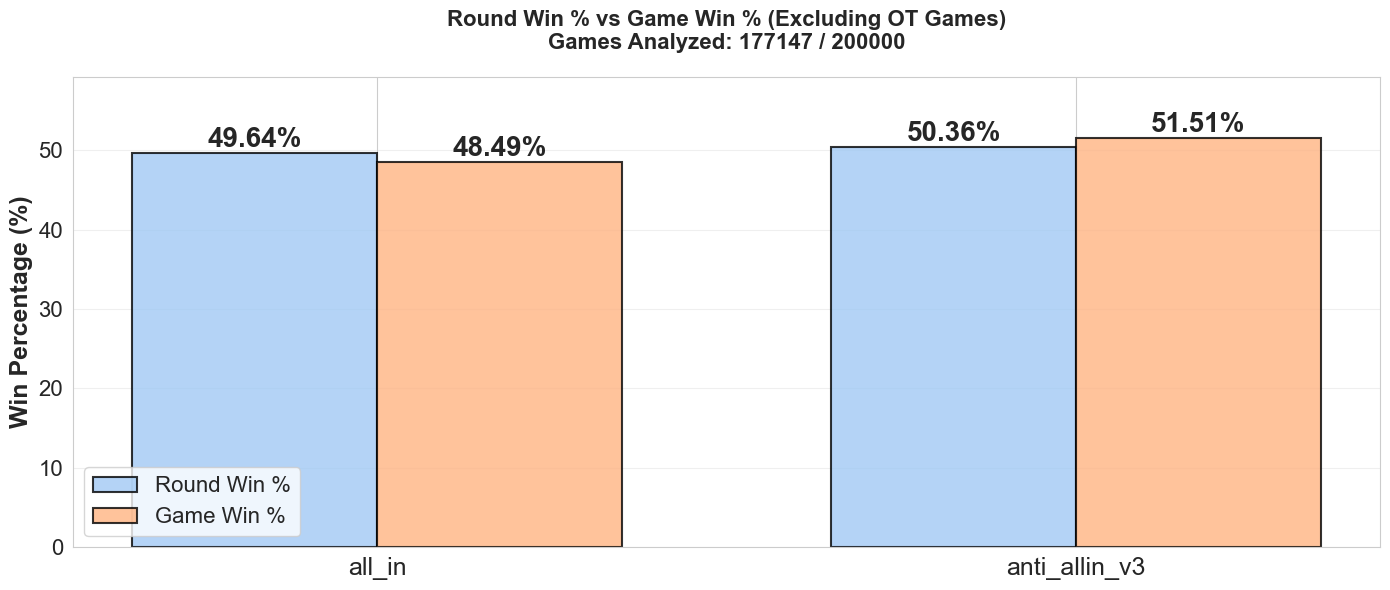

Round Win vs Game Win Comparison (Excluding ALL OT Games)
Total games analyzed: 177147 (excluded 22853 OT games = 11.4%)
Total rounds analyzed: 4602826

         Team  Round Win %  Round Wins  Game Win %  Game Wins  Difference (Round - Game %)
       all_in    49.635376     2284630   48.492495      85903                     1.142881
anti_allin_v3    50.364624     2318196   51.507505      91244                    -1.142881

Key Insights:
- Games with overtime are completely excluded from this analysis
- This shows the "natural" win rates when games end in regulation time (30 rounds or less)
- Difference between round win % and game win % shows how efficiently each team converts round wins to game wins
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [64]:
# Analysis: Round Win % and Game Win % excluding ALL OT games
# Filter out any games that went to overtime

# Create a list of game_ids that have any OT rounds
ot_game_ids = df_filtered[df_filtered['is_ot'] == True]['game_id'].unique()

# Filter to exclude all games that had any OT
df_no_ot = df_filtered[~df_filtered['game_id'].isin(ot_game_ids)].copy()

# Calculate round win percentages (excluding OT games)
total_rounds_no_ot = len(df_no_ot)
t1_rounds_won_no_ot = df_no_ot['is_t1_winner'].sum()
t2_rounds_won_no_ot = total_rounds_no_ot - t1_rounds_won_no_ot

t1_round_win_pct_no_ot = (t1_rounds_won_no_ot / total_rounds_no_ot) * 100 if total_rounds_no_ot > 0 else 0
t2_round_win_pct_no_ot = (t2_rounds_won_no_ot / total_rounds_no_ot) * 100 if total_rounds_no_ot > 0 else 0

# Get final scores for each game (excluding OT games)
final_scores_no_ot = df_no_ot.groupby('game_id').agg(
    t1_final=('t1_score_end', 'last'),
    t2_final=('t2_score_end', 'last')
).reset_index()

# Determine game winners
final_scores_no_ot['t1_won_game'] = final_scores_no_ot['t1_final'] > final_scores_no_ot['t2_final']

# Game-level statistics (excluding OT games)
total_games_no_ot = len(final_scores_no_ot)
t1_games_won_no_ot = final_scores_no_ot['t1_won_game'].sum()
t2_games_won_no_ot = total_games_no_ot - t1_games_won_no_ot

t1_game_win_pct_no_ot = (t1_games_won_no_ot / total_games_no_ot) * 100 if total_games_no_ot > 0 else 0
t2_game_win_pct_no_ot = (t2_games_won_no_ot / total_games_no_ot) * 100 if total_games_no_ot > 0 else 0

# Create comparison dataframe
comparison_df_no_ot = pd.DataFrame({
    'Team': [t1_label, t2_label],
    'Round Win %': [t1_round_win_pct_no_ot, t2_round_win_pct_no_ot],
    'Round Wins': [t1_rounds_won_no_ot, t2_rounds_won_no_ot],
    'Game Win %': [t1_game_win_pct_no_ot, t2_game_win_pct_no_ot],
    'Game Wins': [t1_games_won_no_ot, t2_games_won_no_ot],
    'Difference (Round - Game %)': [t1_round_win_pct_no_ot - t1_game_win_pct_no_ot, 
                                     t2_round_win_pct_no_ot - t2_game_win_pct_no_ot]
})

# Print summary
print("="*80)
print("ROUND WIN % vs GAME WIN % (EXCLUDING ALL OT GAMES)")
print("="*80)
print(f"\nTotal games analyzed: {total_games_no_ot} (excluded {len(ot_game_ids)} OT games)")
print(f"Total rounds analyzed: {total_rounds_no_ot}")
print(f"OT games excluded: {len(ot_game_ids)} ({len(ot_game_ids)/total_games*100:.2f}% of all games)")
print()
print(comparison_df_no_ot.to_string(index=False))
print()

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Bar chart comparing percentages
x = np.arange(len(comparison_df_no_ot))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df_no_ot['Round Win %'], width, 
               label='Round Win %', alpha=0.8, color=COLOR_PALETTE[0], edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, comparison_df_no_ot['Game Win %'], width, 
               label='Game Win %', alpha=0.8, color=COLOR_PALETTE[1], edgecolor='black', linewidth=1.5)

ax.set_ylabel('Win Percentage (%)', fontsize=18, fontweight='bold')
ax.tick_params(labelsize=16)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df_no_ot['Team'], fontsize=18)
ax.legend(fontsize=16, loc='lower left')
ax.set_title(f'Round Win % vs Game Win % (Excluding OT Games)\nGames Analyzed: {total_games_no_ot} / {total_games}', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(comparison_df_no_ot['Round Win %'].max(), comparison_df_no_ot['Game Win %'].max()) * 1.15)

plt.tight_layout()
exporter.export(plt.gcf(), title="Round Win % vs Game Win % (No OT Games)")
plt.show()

# Export comparison stats
comparison_text_no_ot = f"""Round Win vs Game Win Comparison (Excluding ALL OT Games)
{'='*80}
Total games analyzed: {total_games_no_ot} (excluded {len(ot_game_ids)} OT games = {len(ot_game_ids)/total_games*100:.1f}%)
Total rounds analyzed: {total_rounds_no_ot}

{comparison_df_no_ot.to_string(index=False)}

Key Insights:
- Games with overtime are completely excluded from this analysis
- This shows the "natural" win rates when games end in regulation time (30 rounds or less)
- Difference between round win % and game win % shows how efficiently each team converts round wins to game wins
{'='*80}"""

print(comparison_text_no_ot)
exporter.export(comparison_text_no_ot, title="Round vs Game Win Statistics (No OT)")

### Spenditure on win compared to own 

In [65]:
# Calculate expenditure and FTE equipment when winning a round for both teams

# For T1: rounds where T1 won
t1_win_rounds = df_filtered[df_filtered['is_t1_winner'] == True].copy()


# For T2: rounds where T2 won
t2_win_rounds = df_filtered[df_filtered['is_t1_winner'] == False].copy()




Resource Allocation and Invested Resource Ratio Analysis by Team


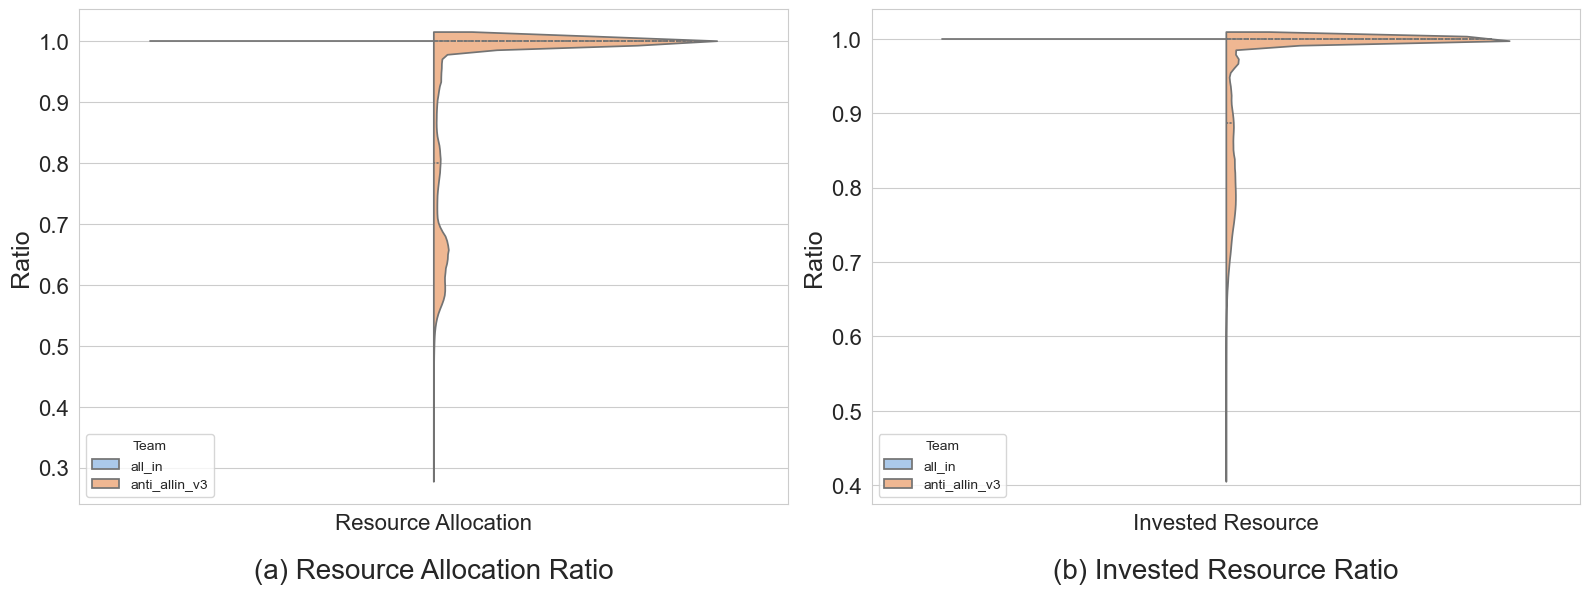

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [66]:

# Calculate ratios for both teams

# Team 1 ratios
t1_resource_allocation_ratio_2 = t1_win_rounds['t1_spent'] / t1_win_rounds['t1_funds_start'] #resource allocation ratio
t1_invested_resource_ratio_2 = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_funds_start'] + t1_win_rounds['t1_rs_eq']) #invested resource ratio

# Team 2 ratios
t2_resource_allocation_ratio_2 = t2_win_rounds['t2_spent'] / t2_win_rounds['t2_funds_start'] #resource allocation ratio
t2_invested_resource_ratio_2 = t2_win_rounds['t2_fte_eq'] / (t2_win_rounds['t2_funds_start'] + t2_win_rounds['t2_rs_eq']) #invested resource ratio
# ============================================================================
# FIGURE: Resource allocation RATIO VIOLIN PLOTS (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for split violin plots combining both teams
data_funds = pd.DataFrame({
    'Category': ['Resource Allocation'] * (len(t1_resource_allocation_ratio_2.dropna()) + len(t2_resource_allocation_ratio_2.dropna())),
    'Team': [t1_label] * len(t1_resource_allocation_ratio_2.dropna()) + [t2_label] * len(t2_resource_allocation_ratio_2.dropna()),
    'Ratio': list(t1_resource_allocation_ratio_2.dropna()) + list(t2_resource_allocation_ratio_2.dropna())
})

data_total = pd.DataFrame({
    'Category': ['Invested Resource'] * (len(t1_invested_resource_ratio_2.dropna()) + len(t2_invested_resource_ratio_2.dropna())),
    'Team': [t1_label] * len(t1_invested_resource_ratio_2.dropna()) + [t2_label] * len(t2_invested_resource_ratio_2.dropna()),
    'Ratio': list(t1_invested_resource_ratio_2.dropna()) + list(t2_invested_resource_ratio_2.dropna())
})

# Plot 1: Resource Allocation Ratio (both teams)
sns.violinplot(data=data_funds, x='Category', y='Ratio', ax=axes[0],
               palette=COLOR_PALETTE[:2], hue='Team', legend=True, inner='quartile', split=True)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ratio', fontsize=18)
axes[0].tick_params(labelsize=16)

# Add subplot label
axes[0].text(0.5, -0.15, '(a) Resource Allocation Ratio',
             transform=axes[0].transAxes,
             horizontalalignment='center',
             fontsize=20)
sns.violinplot(data=data_total, x='Category', y='Ratio', ax=axes[1],
               palette=COLOR_PALETTE[:2], hue='Team', legend=True, inner='quartile', split=True)
axes[1].set_xlabel('')
axes[1].set_ylabel('Ratio', fontsize=18)
axes[1].tick_params(labelsize=16)

# Add subplot label
axes[1].text(0.5, -0.15, '(b) Invested Resource Ratio',
             transform=axes[1].transAxes,
             horizontalalignment='center',
             fontsize=20)

# Print title before showing figure
print("Resource Allocation and Invested Resource Ratio Analysis by Team")

plt.tight_layout()
plt.show()

exporter.export("Resource Allocation and Invested Resource Ratio Analysis by Team", title="Figure Title")
exporter.export(fig, title="Resource Allocation and Invested Resource Ratio Analysis - Violin Plots")



fte_stats_text = f""" 
 FTE EQUIPMENT RATIO STATISTICS
 {t1_label}:
   FTE/Starting Funds:
     Mean={t1_resource_allocation_ratio_2.mean():.3f}, Median={t1_resource_allocation_ratio_2.median():.3f}
     Q1 (25%)={t1_resource_allocation_ratio_2.quantile(0.25):.3f}, Q3 (75%)={t1_resource_allocation_ratio_2.quantile(0.75):.3f}
     Min={t1_resource_allocation_ratio_2.min():.3f}, Max={t1_resource_allocation_ratio_2.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t1_invested_resource_ratio_2.mean():.3f}, Median={t1_invested_resource_ratio_2.median():.3f}
     Q1 (25%)={t1_invested_resource_ratio_2.quantile(0.25):.3f}, Q3 (75%)={t1_invested_resource_ratio_2.quantile(0.75):.3f}
     Min={t1_invested_resource_ratio_2.min():.3f}, Max={t1_invested_resource_ratio_2.max():.3f}
 {t2_label}:
   FTE/Starting Funds:
     Mean={t2_resource_allocation_ratio_2.mean():.3f}, Median={t2_resource_allocation_ratio_2.median():.3f}
     Q1 (25%)={t2_resource_allocation_ratio_2.quantile(0.25):.3f}, Q3 (75%)={t2_resource_allocation_ratio_2.quantile(0.75):.3f}
     Min={t2_resource_allocation_ratio_2.min():.3f}, Max={t2_resource_allocation_ratio_2.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t2_invested_resource_ratio_2.mean():.3f}, Median={t2_invested_resource_ratio_2.median():.3f}
     Q1 (25%)={t2_invested_resource_ratio_2.quantile(0.25):.3f}, Q3 (75%)={t2_invested_resource_ratio_2.quantile(0.75):.3f}
     Min={t2_invested_resource_ratio_2.min():.3f}, Max={t2_invested_resource_ratio_2.max():.3f}
"""






exporter.export(fte_stats_text, title="FTE Ratio Statistics")

Distribution of Ratios T1


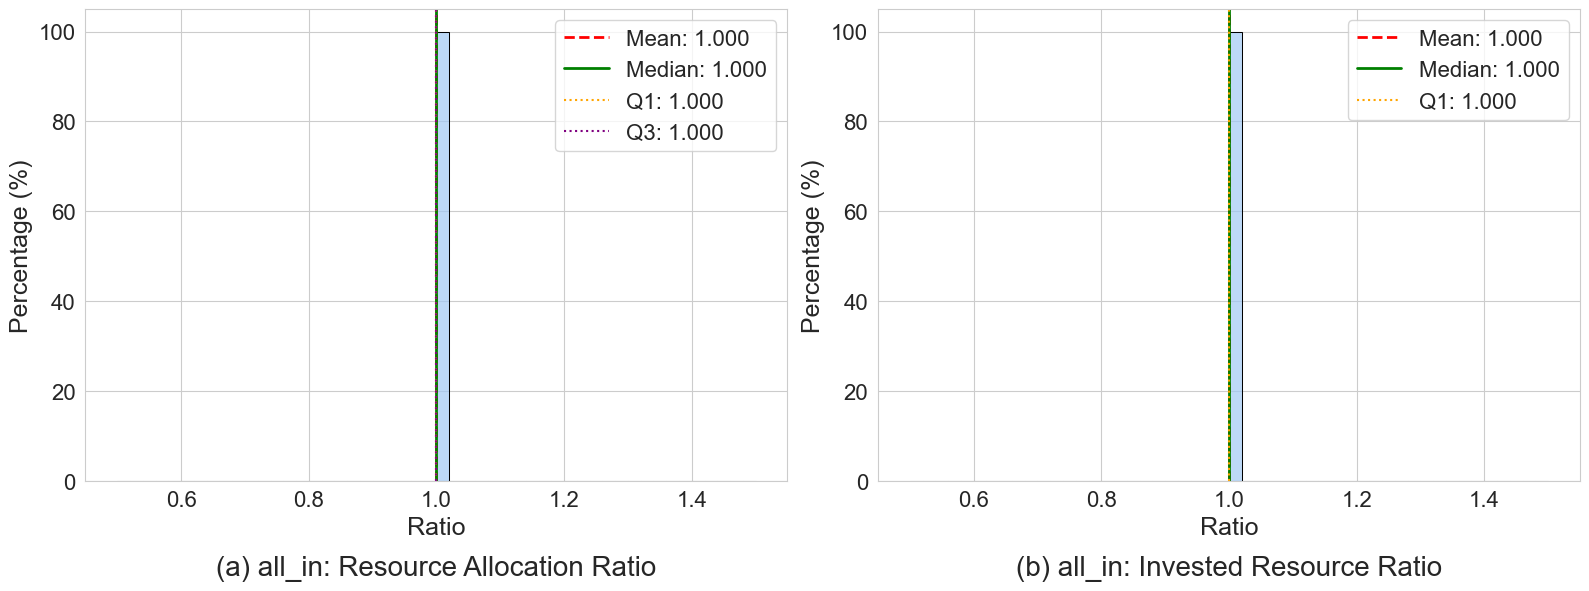

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
Distribution of Invested Resource Ratios T2


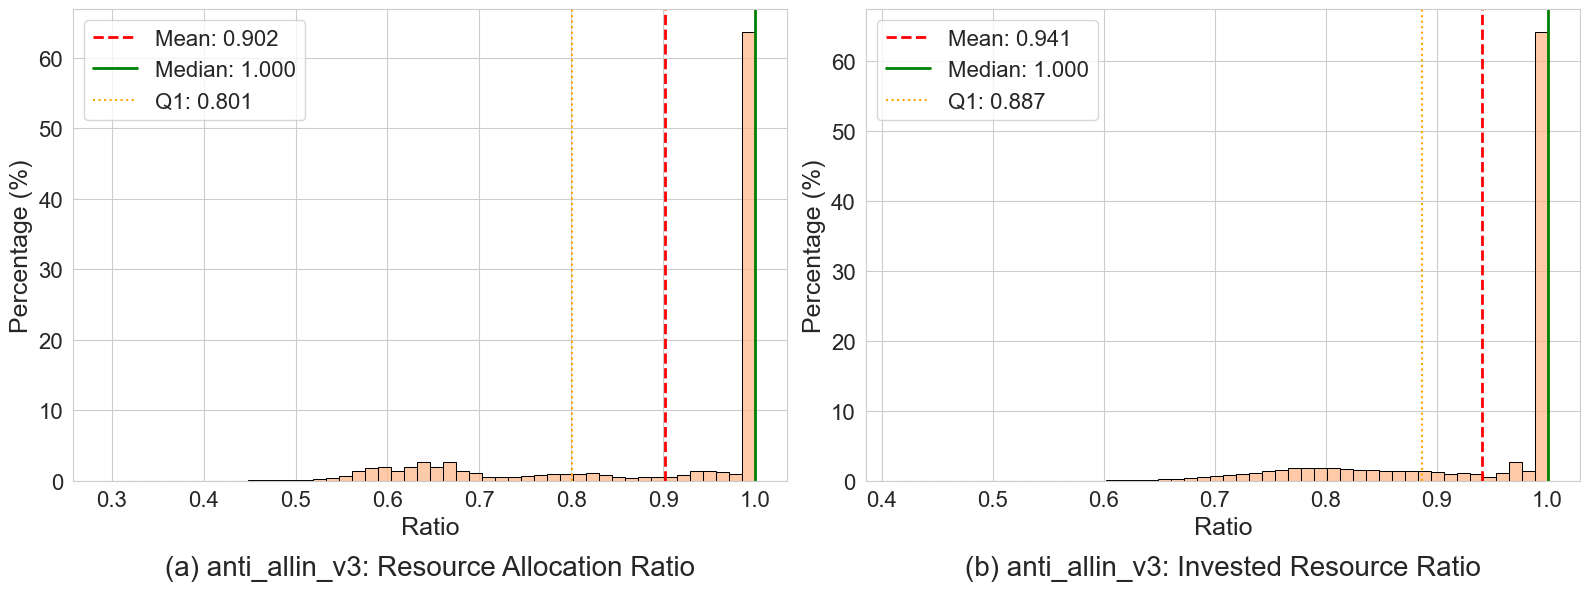

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [67]:
# ============================================================================
# DISTRIBUTION PLOTS FOR FTE EQUIPMENT RATIOS (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team 1 - Resource Allocation Ratio Distribution
sns.histplot(data=t1_resource_allocation_ratio_2.dropna(), bins=50, stat='percent', 
             color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black', ax=axes[0])
axes[0].axvline(t1_resource_allocation_ratio_2.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_resource_allocation_ratio_2.mean():.3f}')
axes[0].axvline(t1_resource_allocation_ratio_2.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_resource_allocation_ratio_2.median():.3f}')
axes[0].axvline(t1_resource_allocation_ratio_2.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_resource_allocation_ratio_2.quantile(0.25):.3f}')
axes[0].axvline(t1_resource_allocation_ratio_2.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t1_resource_allocation_ratio_2.quantile(0.75):.3f}')
axes[0].set_xlabel('Ratio', fontsize=18)
axes[0].set_ylabel('Percentage (%)', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].legend(fontsize=16)
axes[0].text(0.5, -0.20, f'(a) {t1_label}: Resource Allocation Ratio',
                transform=axes[0].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Team 1 - Invested Resource Ratio Distribution
sns.histplot(data=t1_invested_resource_ratio_2.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black', ax=axes[1])
axes[1].axvline(t1_invested_resource_ratio_2.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_invested_resource_ratio_2.mean():.3f}')
axes[1].axvline(t1_invested_resource_ratio_2.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_invested_resource_ratio_2.median():.3f}')
axes[1].axvline(t1_invested_resource_ratio_2.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_invested_resource_ratio_2.quantile(0.25):.3f}')
axes[1].set_xlabel('Ratio', fontsize=18)
axes[1].set_ylabel('Percentage (%)', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].legend(fontsize=16)
axes[1].text(0.5, -0.20, f'(b) {t1_label}: Invested Resource Ratio',
                transform=axes[1].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Print title before showing figure
print("Distribution of Ratios T1")

plt.tight_layout()
plt.show()

exporter.export("Distribution of Ratios T1", title="Figure Title")
exporter.export(fig, title="T1 Ratio Distributions")

#Team 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team 2 - Resource Allocation Ratio Distribution
sns.histplot(data=t2_resource_allocation_ratio_2.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black', ax=axes[0])
axes[0].axvline(t2_resource_allocation_ratio_2.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_resource_allocation_ratio_2.mean():.3f}')
axes[0].axvline(t2_resource_allocation_ratio_2.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_resource_allocation_ratio_2.median():.3f}')
axes[0].axvline(t2_resource_allocation_ratio_2.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_resource_allocation_ratio_2.quantile(0.25):.3f}')
axes[0].set_xlabel('Ratio', fontsize=18)
axes[0].set_ylabel('Percentage (%)', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].legend(fontsize=16)
axes[0].text(0.5, -0.20, f'(a) {t2_label}: Resource Allocation Ratio',
                transform=axes[0].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Team 2 - Invested Resource Ratio Distribution
sns.histplot(data=t2_invested_resource_ratio_2.dropna(), bins=50, stat='percent',
             color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black', ax=axes[1])
axes[1].axvline(t2_invested_resource_ratio_2.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_invested_resource_ratio_2.mean():.3f}')
axes[1].axvline(t2_invested_resource_ratio_2.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_invested_resource_ratio_2.median():.3f}')
axes[1].axvline(t2_invested_resource_ratio_2.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_invested_resource_ratio_2.quantile(0.25):.3f}')
axes[1].set_xlabel('Ratio', fontsize=18)
axes[1].set_ylabel('Percentage (%)', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].legend(fontsize=16)
axes[1].text(0.5, -0.20, f'(b) {t2_label}: Invested Resource Ratio',
                transform=axes[1].transAxes,
                horizontalalignment='center',
                fontsize=20)

# Print title before showing figure
print("Distribution of Invested Resource Ratios T2")

plt.tight_layout()
plt.show()

exporter.export("Distribution of Invested Resource Ratios T2", title="Figure Title")
exporter.export(fig, title="Invested Resource Ratio Distributions T2")





✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


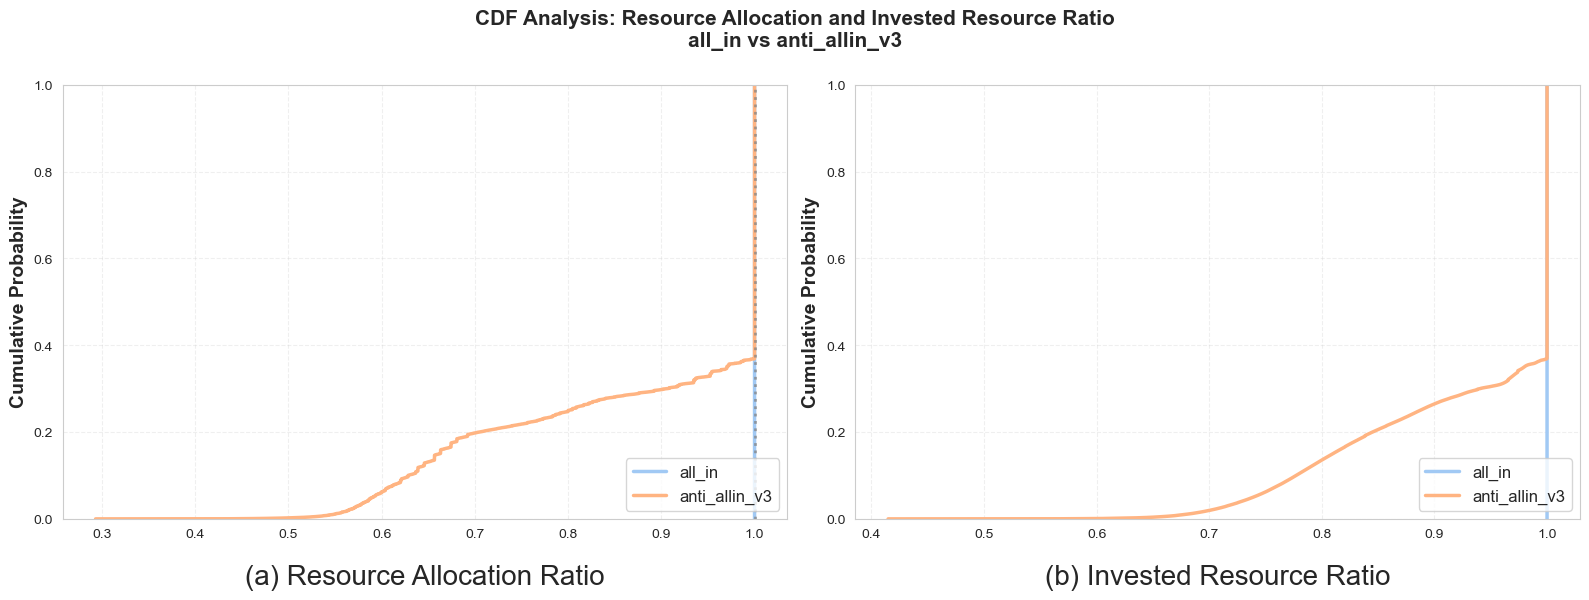

In [68]:
# CDF Analysis: Resource Allocation and Investment Efficiency
# Create CDF plots for the two ratio metrics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ===== Left Plot: Resource Allocation Ratio CDF =====
# Sort data for CDF
t1_alloc_sorted_2 = np.sort(t1_resource_allocation_ratio_2)
t2_alloc_sorted_2 = np.sort(t2_resource_allocation_ratio_2)

# Calculate CDF values
t1_alloc_cdf_2 = np.arange(1, len(t1_alloc_sorted_2) + 1) / len(t1_alloc_sorted_2)
t2_alloc_cdf_2 = np.arange(1, len(t2_alloc_sorted_2) + 1) / len(t2_alloc_sorted_2)

# Plot Resource Allocation Ratio CDF
ax1.plot(t1_alloc_sorted_2, t1_alloc_cdf_2, label=t1_label, color=COLOR_PALETTE[0], linewidth=2.5)
ax1.plot(t2_alloc_sorted_2, t2_alloc_cdf_2, label=t2_label, color=COLOR_PALETTE[1], linewidth=2.5)

ax1.set_xlabel('')
ax1.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax1.set_title('')
ax1.legend(fontsize=12, loc='lower right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1])

ax1.text(0.5, -0.15, '(a) Resource Allocation Ratio',
             transform=ax1.transAxes,
             horizontalalignment='center',
             fontsize=20)

# Add reference line at 1.0 (full budget)
ax1.axvline(1.0, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Full Budget (1.0)')


# ===== Right Plot: Invested Resource Ratio CDF =====
# Sort data for CDF
t1_invest_sorted_2 = np.sort(t1_invested_resource_ratio_2)
t2_invest_sorted_2 = np.sort(t2_invested_resource_ratio_2)

# Calculate CDF values
t1_invest_cdf_2 = np.arange(1, len(t1_invest_sorted_2) + 1) / len(t1_invest_sorted_2)
t2_invest_cdf_2 = np.arange(1, len(t2_invest_sorted_2) + 1) / len(t2_invest_sorted_2)

# Plot Invested Resource Ratio CDF
ax2.plot(t1_invest_sorted_2, t1_invest_cdf_2, label=t1_label, color=COLOR_PALETTE[0], linewidth=2.5)
ax2.plot(t2_invest_sorted_2, t2_invest_cdf_2, label=t2_label, color=COLOR_PALETTE[1], linewidth=2.5)

ax2.set_xlabel('')
ax2.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax2.set_title('')
ax2.legend(fontsize=12, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])

ax2.text(0.5, -0.15, '(b) Invested Resource Ratio',
             transform=ax2.transAxes,
             horizontalalignment='center',
             fontsize=20)


plt.suptitle(f'CDF Analysis: Resource Allocation and Invested Resource Ratio\n{t1_label} vs {t2_label}',
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()

# Export
exporter.export(fig, title="CDF - Resource Allocation and Invested Resource Ratio")
plt.show()


Invested Resource Absolute Value Analysis


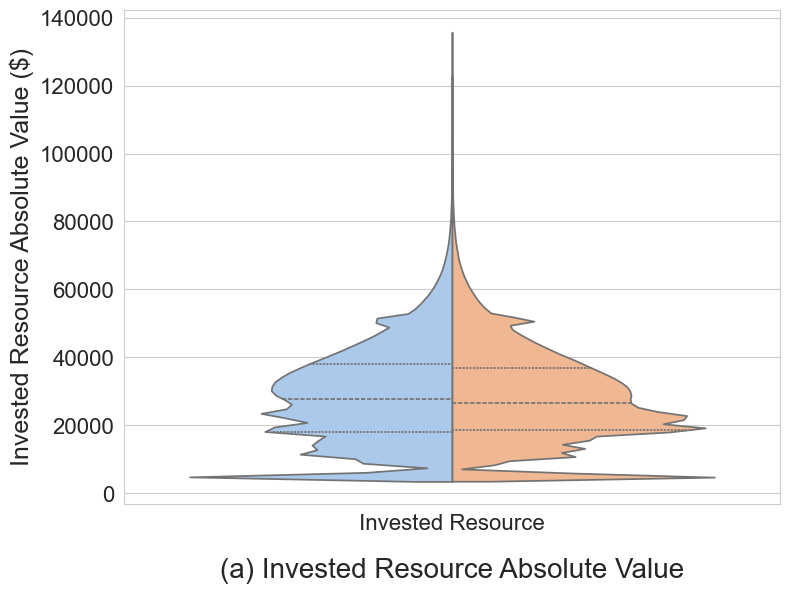

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html

 INVESTED RESOURCE ABSOLUTE VALUE STATISTICS")
 all_in:
   Mean: $28566.05
   Median: $27883.00
   Q1 (25%): $18000.00
   Q3 (75%): $38093.00
   Min: $5000.00
   Max: $134218.00
   Std Dev: $14693.85
 anti_allin_v3:
   Mean: $28088.96
   Median: $26438.00
   Q1 (25%): $18600.00
   Q3 (75%): $36885.00
   Min: $5000.00
   Max: $121670.00
   Std Dev: $14212.56

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [69]:
# ============================================================================
# Invested Resource Absolute VALUES - SPLIT VIOLIN PLOT AND DISTRIBUTION (USING SEABORN)
# ============================================================================

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Extract Invested Resource Absolute values
t1_invested_resource_2 = t1_win_rounds['t1_fte_eq']
t2_invested_resource_2 = t2_win_rounds['t2_fte_eq']

# Prepare combined data for split violin plot
data_invested_resource_combined_2 = pd.DataFrame({
    'Category': ['Invested Resource'] * (len(t1_invested_resource_2.dropna()) + len(t2_invested_resource_2.dropna())),
    'Team': [t1_label] * len(t1_invested_resource_2.dropna()) + [t2_label] * len(t2_invested_resource_2.dropna()),
    'Invested Resource': list(t1_invested_resource_2.dropna()) + list(t2_invested_resource_2.dropna())
})

# Left plot: Split Violin Plot
sns.violinplot(data=data_invested_resource_combined_2, x='Category', y='Invested Resource', ax=axes,
               palette=COLOR_PALETTE[:2], hue='Team', legend=False, inner='quartile', split=True, gap=0)
axes.set_xlabel('')
axes.set_ylabel('Invested Resource Absolute Value ($)', fontsize=18)
axes.tick_params(labelsize=16)

# Add subplot label
axes.text(0.5, -0.15, '(a) Invested Resource Absolute Value',
          transform=axes.transAxes,
          horizontalalignment='center',
          fontsize=20)


# Print title before showing figure
print("Invested Resource Absolute Value Analysis")

plt.tight_layout()
plt.show()

exporter.export("Invested Resource Absolute Value Analysis", title="Figure Title")
exporter.export(fig, title="Invested Resource Absolute Value Analysis")


invested_resource_stats = f"""
 INVESTED RESOURCE ABSOLUTE VALUE STATISTICS")
 {t1_label}:
   Mean: ${t1_invested_resource_2.mean():.2f}
   Median: ${t1_invested_resource_2.median():.2f}
   Q1 (25%): ${t1_invested_resource_2.quantile(0.25):.2f}
   Q3 (75%): ${t1_invested_resource_2.quantile(0.75):.2f}
   Min: ${t1_invested_resource_2.min():.2f}
   Max: ${t1_invested_resource_2.max():.2f}
   Std Dev: ${t1_invested_resource_2.std():.2f}
 {t2_label}:
   Mean: ${t2_invested_resource_2.mean():.2f}
   Median: ${t2_invested_resource_2.median():.2f}
   Q1 (25%): ${t2_invested_resource_2.quantile(0.25):.2f}
   Q3 (75%): ${t2_invested_resource_2.quantile(0.75):.2f}
   Min: ${t2_invested_resource_2.min():.2f}
   Max: ${t2_invested_resource_2.max():.2f}
   Std Dev: ${t2_invested_resource_2.std():.2f}
"""
print(invested_resource_stats)

exporter.export(invested_resource_stats, title="Invested Resource Absolute Value Statistics")

Text(0.5, -0.15, '(b) CSF Ratio')

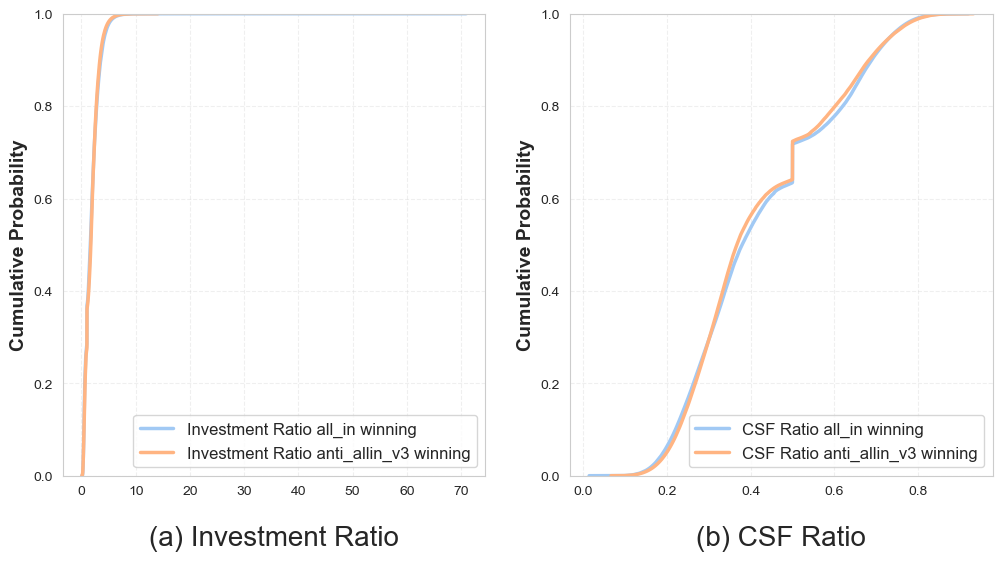

In [70]:
# ============================================================================
# Investment Ratio - CDF
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Extract Invested Resource Absolute values and watch out, the ratios are switched for the two teams to maintain the same perspective (winner vs loser)
t1_t2_investment_ratio_t1win = t1_win_rounds['t1_fte_eq'] / t1_win_rounds['t2_fte_eq']
t1_t2_investment_ratio_t2win = t2_win_rounds['t2_fte_eq'] / t2_win_rounds['t1_fte_eq']
csf_ratio_t1_t1win = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_fte_eq'] + t1_win_rounds['t2_fte_eq'])
csf_ratio_t1_t2win = t2_win_rounds['t2_fte_eq'] / (t2_win_rounds['t1_fte_eq'] + t2_win_rounds['t2_fte_eq'])

# Sort data for CDF
t1_t2_investment_ratio_t1win = np.sort(t1_t2_investment_ratio_t1win.dropna())
cdf_1_t1 = np.arange(1, len(t1_t2_investment_ratio_t1win) + 1) / len(t1_t2_investment_ratio_t1win)
t1_t2_investment_ratio_t2win = np.sort(t1_t2_investment_ratio_t2win.dropna())
cdf_1_t2 = np.arange(1, len(t1_t2_investment_ratio_t2win) + 1) / len(t1_t2_investment_ratio_t2win)

csf_ratio_t1_t1win = np.sort(1 - csf_ratio_t1_t1win.dropna())
cdf_2_t1 = np.arange(1, len(csf_ratio_t1_t1win) + 1) / len(csf_ratio_t1_t1win)
csf_ratio_t1_t2win = np.sort(1 - csf_ratio_t1_t2win.dropna())
cdf_2_t2 = np.arange(1, len(csf_ratio_t1_t2win) + 1) / len(csf_ratio_t1_t2win)


# Plot CDF
#first graph for investment ratio
ax1.plot(t1_t2_investment_ratio_t1win, cdf_1_t1, label=f'Investment Ratio {t1_label} winning', color=COLOR_PALETTE[0], linewidth=2.5)
ax1.plot(t1_t2_investment_ratio_t2win, cdf_1_t2, label=f'Investment Ratio {t2_label} winning', color=COLOR_PALETTE[1], linewidth=2.5)
ax1.set_xlabel('')
ax1.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax1.set_title('')
ax1.legend(fontsize=12, loc='lower right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1])

ax1.text(0.5, -0.15, '(a) Investment Ratio',
             transform=ax1.transAxes,
             horizontalalignment='center',
             fontsize=20)

# second graph for csf ratio 
ax2.plot(csf_ratio_t1_t1win, cdf_2_t1, label=f'CSF Ratio {t1_label} winning', color=COLOR_PALETTE[0], linewidth=2.5)
ax2.plot(csf_ratio_t1_t2win, cdf_2_t2, label=f'CSF Ratio {t2_label} winning', color=COLOR_PALETTE[1], linewidth=2.5)
ax2.set_xlabel('')
ax2.set_ylabel('Cumulative Probability', fontsize=14, fontweight='bold')
ax2.set_title('')
ax2.legend(fontsize=12, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])
ax2.text(0.5, -0.15, '(b) CSF Ratio',
             transform=ax2.transAxes,
             horizontalalignment='center',
             fontsize=20)

## Create stats on streaks and reversals

max streak length can be calculated as follows: look where the winner has a consecutivewin_start = 0 -> reversal round


Wald-Wolfowitz runs test could be applied here or the KS test to compare distributions


In [71]:
halftime = sim_summary['simulation_config']['game_rules']['halfLength']

# T1 streaks ending due to loss after win streak or at halftime 
# Include: 1) Loss after a win streak, 2) Any streak at halftime (including streaks of 1)
t1_streaks_end = df_filtered[
    ((df_filtered['t1_consecutive_losses_start'] == 0) & 
     (df_filtered['t1_consecutive_losses'] == 1) & 
     (df_filtered['t1_consecutive_wins_start'] > 0)) | 
    ((df_filtered['round_number'] == halftime) &
     (df_filtered['t1_consecutive_wins'] > 0))  # Include streaks of 1 that end at halftime
]

# T2 streaks ending due to loss after win streak or at halftime 
# Include: 1) Loss after a win streak, 2) Any streak at halftime (including streaks of 1)
t2_streaks_end = df_filtered[
    ((df_filtered['t2_consecutive_losses_start'] == 0) & 
     (df_filtered['t2_consecutive_losses'] == 1) & 
     (df_filtered['t2_consecutive_wins_start'] > 0)) | 
    ((df_filtered['round_number'] == halftime) &
     (df_filtered['t2_consecutive_wins'] > 0))  # Include streaks of 1 that end at halftime
]

# Adding game end as a streak end for both teams
# Include streaks of any length >= 1 at game end
winner_last_round_data = df_filtered.merge(
    game_scores[['round_number']],
    on=['game_id', 'round_number'],
    how='inner'
)

# For T1: add game-ending rounds where T1 won AND had a streak >= 1
t1_game_end_with_streak = winner_last_round_data[
    (winner_last_round_data['is_t1_winner'] == True) & 
    (winner_last_round_data['t1_consecutive_wins'] > 0)  # Any streak length >= 1
]
t1_streaks_end = pd.concat([t1_streaks_end, t1_game_end_with_streak]).drop_duplicates(subset=['game_id', 'round_number'], keep='first')

# For T2: add game-ending rounds where T2 won AND had a streak >= 1
t2_game_end_with_streak = winner_last_round_data[
    (winner_last_round_data['is_t1_winner'] == False) & 
    (winner_last_round_data['t2_consecutive_wins'] > 0)  # Any streak length >= 1
]
t2_streaks_end = pd.concat([t2_streaks_end, t2_game_end_with_streak]).drop_duplicates(subset=['game_id', 'round_number'], keep='first')

# Add a calculated streak length column that uses consecutive_wins for edge cases
# When consecutive_wins_start == 0 but consecutive_wins == 1, the streak is 1
t1_streaks_end['streak_length'] = t1_streaks_end['t1_consecutive_wins_start'].where(
    t1_streaks_end['t1_consecutive_wins_start'] > 0,
    t1_streaks_end['t1_consecutive_wins']
)
t2_streaks_end['streak_length'] = t2_streaks_end['t2_consecutive_wins_start'].where(
    t2_streaks_end['t2_consecutive_wins_start'] > 0,
    t2_streaks_end['t2_consecutive_wins']
)


In [72]:
# Merging Streak data to form one dataframe of the reversals, halftime and game end

# Add is_t1_streak column to identify which team's streak ended
t1_streaks_end['is_t1_streak'] = True
t2_streaks_end['is_t1_streak'] = False

# Combine both streak dataframes
game_reversals = pd.concat([t1_streaks_end, t2_streaks_end])

# Sort by game_id and round_number for better readability
game_reversals = game_reversals.sort_values(['game_id', 'round_number']).reset_index(drop=True)

# print(game_reversals[game_reversals['game_id'] == random_game_id])

Distribution of Win Streak Lengths Before Reversal/End


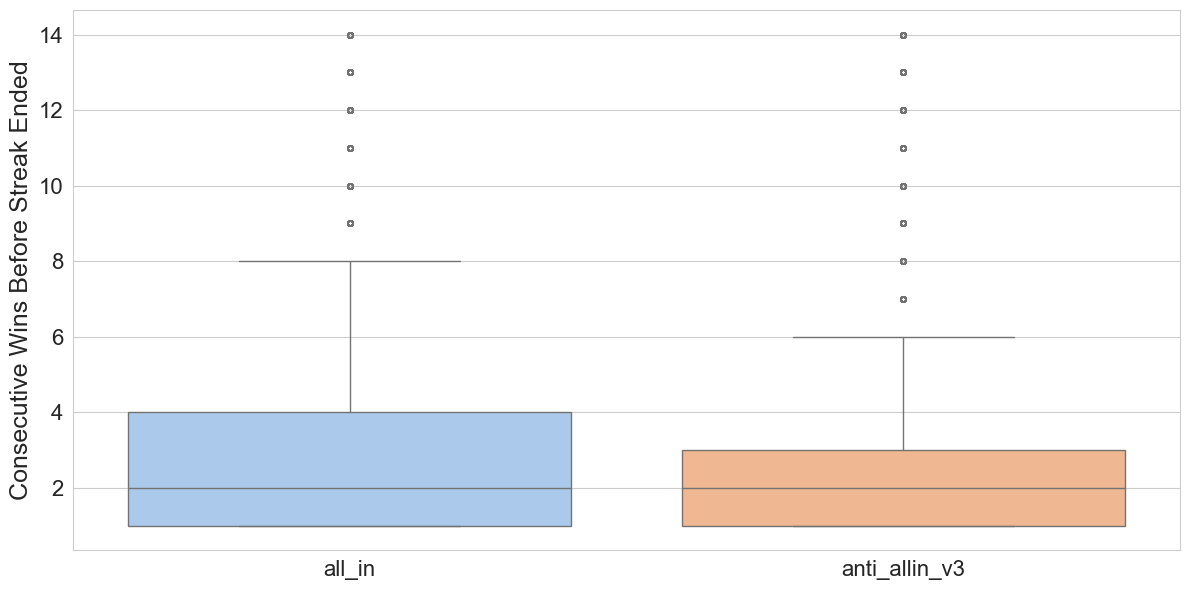

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [73]:
# Create boxplot for win streaks (USING SEABORN)

# Check if there's data to plot
if len(t1_streaks_end) == 0 and len(t2_streaks_end) == 0:
    print("⚠️ No streak data available for either team. Skipping boxplot.")
else:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for seaborn using the calculated streak_length column
    streak_data = pd.DataFrame({
        'Team': [t1_label] * len(t1_streaks_end) + [t2_label] * len(t2_streaks_end),
        'Streak Length': list(t1_streaks_end['streak_length']) + list(t2_streaks_end['streak_length'])
    })
    
    # Create boxplot with seaborn
    sns.boxplot(data=streak_data, x='Team', y='Streak Length', ax=ax, 
                palette=COLOR_PALETTE[:2], hue='Team', fliersize=4)
    
    ax.set_ylabel('Consecutive Wins Before Streak Ended', fontsize=18)
    ax.set_xlabel('')
    ax.tick_params(labelsize=16)
    
    # Print title before showing figure
    print("Distribution of Win Streak Lengths Before Reversal/End")
    
    plt.tight_layout()
    plt.show()
    
    exporter.export(fig, title="Win Streak Lengths Before Reversal/End")
    exporter.export("Distribution of Win Streak Lengths Before Reversal/End", title="Figure Title")


Win Streak Length Distributions Before Ending


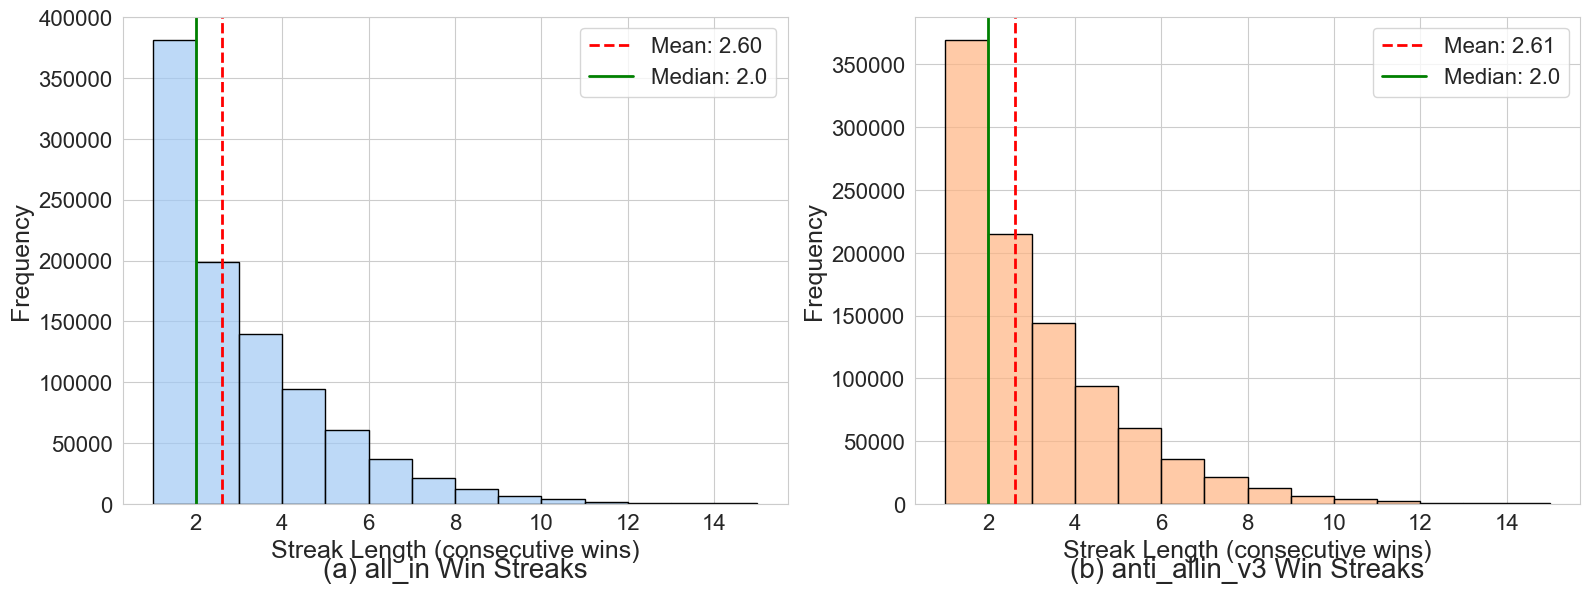


all_in streaks: Count=959940, Mean=2.60, Median=2.0, Std=1.95

anti_allin_v3 streaks: Count=967338, Mean=2.61, Median=2.0, Std=1.93
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [74]:
# Extract streak lengths from the dataframes
# Use the calculated streak_length column which handles edge cases where streaks of 1 end at halftime/game end
t1_streaks_ends = t1_streaks_end['streak_length'].values
t2_streaks_ends = t2_streaks_end['streak_length'].values

# Check if there's data to plot
if len(t1_streaks_ends) == 0 and len(t2_streaks_ends) == 0:
    print("⚠️ No streak data available for either team. Skipping streak analysis.")
else:
    # Create histograms (USING SEABORN)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # T1 histogram
    if len(t1_streaks_ends) > 0:
        sns.histplot(t1_streaks_ends, bins=range(1, int(max(t1_streaks_ends))+2), 
                     color=COLOR_PALETTE[0], alpha=0.7, edgecolor='black', ax=axes[0])
        axes[0].set_xlabel('Streak Length (consecutive wins)', fontsize=18)
        axes[0].set_ylabel('Frequency', fontsize=18)
        axes[0].tick_params(labelsize=16)
        
        # Add statistics
        t1_mean = t1_streaks_ends.mean()
        t1_median = np.median(t1_streaks_ends)
        axes[0].axvline(t1_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_mean:.2f}')
        axes[0].axvline(t1_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t1_median:.1f}')
        axes[0].legend(fontsize=16)
    else:
        axes[0].text(0.5, 0.5, 'No streaks ended\nfor this team', 
                    ha='center', va='center', fontsize=16, transform=axes[0].transAxes)
        axes[0].set_xlabel('Streak Length (consecutive wins)', fontsize=18)
        axes[0].set_ylabel('Frequency', fontsize=18)
        axes[0].tick_params(labelsize=16)
    
    # Add subplot label
    axes[0].text(0.5, -0.15, f'(a) {t1_label} Win Streaks',
                 transform=axes[0].transAxes,
                 horizontalalignment='center',
                 fontsize=20)
    
    # T2 histogram
    if len(t2_streaks_ends) > 0:
        sns.histplot(t2_streaks_ends, bins=range(1, int(max(t2_streaks_ends))+2), 
                     color=COLOR_PALETTE[1], alpha=0.7, edgecolor='black', ax=axes[1])
        axes[1].set_xlabel('Streak Length (consecutive wins)', fontsize=18)
        axes[1].set_ylabel('Frequency', fontsize=18)
        axes[1].tick_params(labelsize=16)
        
        # Add statistics
        t2_mean = t2_streaks_ends.mean()
        t2_median = np.median(t2_streaks_ends)
        axes[1].axvline(t2_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_mean:.2f}')
        axes[1].axvline(t2_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t2_median:.1f}')
        axes[1].legend(fontsize=16)
    else:
        axes[1].text(0.5, 0.5, 'No streaks ended\nfor this team', 
                    ha='center', va='center', fontsize=16, transform=axes[1].transAxes)
        axes[1].set_xlabel('Streak Length (consecutive wins)', fontsize=18)
        axes[1].set_ylabel('Frequency', fontsize=18)
        axes[1].tick_params(labelsize=16)
    
    # Add subplot label
    axes[1].text(0.5, -0.15, f'(b) {t2_label} Win Streaks',
                 transform=axes[1].transAxes,
                 horizontalalignment='center',
                 fontsize=20)
    
    # Print title before showing figure
    print("Win Streak Length Distributions Before Ending")
    
    
    plt.tight_layout()
    plt.show()
    
    
    # Generate statistics text
    if len(t1_streaks_ends) > 0:
        t1_mean = t1_streaks_ends.mean()
        t1_median = np.median(t1_streaks_ends)
        t1_text = f"""\n{t1_label} streaks: Count={len(t1_streaks_ends)}, Mean={t1_mean:.2f}, Median={t1_median:.1f}, Std={t1_streaks_ends.std():.2f}"""
    else:
        t1_text = f"""\n{t1_label} streaks: No streaks ended (complete dominance)"""
    
    if len(t2_streaks_ends) > 0:
        t2_mean = t2_streaks_ends.mean()
        t2_median = np.median(t2_streaks_ends)
        t2_text = f"""\n{t2_label} streaks: Count={len(t2_streaks_ends)}, Mean={t2_mean:.2f}, Median={t2_median:.1f}, Std={t2_streaks_ends.std():.2f}"""
    else:
        t2_text = f"""\n{t2_label} streaks: No streaks ended (complete dominance)"""
    
    print(t1_text)
    print(t2_text)
    
    exporter.export(t1_text + t2_text, title="Win Streak Length Statistics Before Ending")
    exporter.export(fig, title="Win Streak Length Distributions Before Ending")
    exporter.export("Win Streak Length Distributions Before Ending", title="Figure Title")


## Statistical Significance Tests for Game Wins



In [75]:
#first create a list all games with t1_winner true/false

game_scores['t1_winner'] = game_scores['t1_score_end'] > game_scores['t2_score_end']
game_scores['t1_winner_int'] = game_scores['t1_winner'].astype(int)


signed_values_pos = np.sum(game_scores['t1_winner'] == True)
signed_values_neg = np.sum(game_scores['t1_winner'] == False)
print(f"winrate team1: {signed_values_pos/(signed_values_pos+signed_values_neg)} ")
n = np.min([signed_values_pos, signed_values_neg])

signed_test = stats.binomtest(n, n=signed_values_pos + signed_values_neg, p=0.5, alternative='two-sided')
binom_test = stats.binomtest(signed_values_pos, n=signed_values_pos+signed_values_neg)
wilcoxon_test_scores = stats.wilcoxon(game_scores['t1_score_end'], game_scores['t2_score_end'])
wilcoxon_test_outcome = stats.wilcoxon(game_scores['t1_winner_int'])
ttest_related = stats.ttest_rel(game_scores['t1_score_end'], game_scores['t2_score_end'])
f_test = stats.f_oneway(game_scores['t1_score_end'], game_scores['t2_score_end'])
mw_test = stats.mannwhitneyu(game_scores['t1_score_end'], game_scores['t2_score_end'])
ks_test = stats.ks_2samp(game_scores['t1_score_end'], game_scores['t2_score_end'])


tests = {
    'Signed Test': signed_test.pvalue,
    'Binomial Test': binom_test.pvalue,
    'Wilcoxon (Scores)': wilcoxon_test_scores.pvalue,
    'Wilcoxon (Outcome)': wilcoxon_test_outcome.pvalue,
    'Paired t-test': ttest_related.pvalue,
    'F-test': f_test.pvalue,
    'Mann-Whitney U': mw_test.pvalue,
    'Kolmogorov-Smirnov': ks_test.pvalue,
}

alpha = 0.005

# Check if ALL tests are significant
significance = all(p < alpha for p in tests.values())



text_output_tests = f"""Statistical Significance Test Results
{'='*80}
"""

for test_name, p_value in tests.items():
    status = "✓ SIGNIFICANT" if p_value < alpha else "✗ NOT SIGNIFICANT"
    text_output_tests += f"{test_name:.<40} p={p_value:.6f} {status}\n"

text_output_tests += f"""{'='*80}
"""

print (text_output_tests)
exporter.export(text_output_tests, title="Statistical Significance Test Results")



winrate team1: 0.486425 
Statistical Significance Test Results
Signed Test............................. p=0.000000 ✓ SIGNIFICANT
Binomial Test........................... p=0.000000 ✓ SIGNIFICANT
Wilcoxon (Scores)....................... p=0.000000 ✓ SIGNIFICANT
Wilcoxon (Outcome)...................... p=0.000000 ✓ SIGNIFICANT
Paired t-test........................... p=0.000000 ✓ SIGNIFICANT
F-test.................................. p=0.000000 ✓ SIGNIFICANT
Mann-Whitney U.......................... p=0.000000 ✓ SIGNIFICANT
Kolmogorov-Smirnov...................... p=0.000000 ✓ SIGNIFICANT

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [76]:
def find_significant_winrate(n, alpha=0.005):
    """
    Find the minimum winrate that is statistically significantly different 
    from 50% at a given significance level (alpha) for n simulations.
    
    Parameters:
    -----------
    n : int
        Number of simulations (sample size)
    alpha : float
        Significance level (default 0.005 for two-tailed test)
    
    Returns:
    --------
    dict with keys:
        - 'critical_wins': minimum wins needed for significance
        - 'critical_winrate': as percentage
        - 'minimum_difference': from 50% (in percentage points)
        - 'p_value': exact p-value at critical point
    """
    from scipy.stats import binomtest
    
    # Find critical value by testing each possible win count
    # Start from 50% and increase until we find significance
    critical_wins = None
    
    for k in range(n // 2, n + 1):
        p_value = binomtest(k, n, 0.5, alternative='two-sided').pvalue
        if p_value <= alpha:
            critical_wins = k
            critical_pvalue = p_value
            break
    
    if critical_wins is None:
        # No significant difference possible at this alpha with this n
        return {
            'critical_wins': None,
            'critical_winrate': None,
            'minimum_difference': None,
            'p_value': None,
            'message': f'No significant difference possible at α={alpha} with n={n}'
        }
    
    winrate_pct = (critical_wins / n) * 100
    min_diff_pct = abs(winrate_pct - 50)
    
    return {
        'critical_wins': critical_wins,
        'critical_winrate': winrate_pct,
        'minimum_difference': min_diff_pct,
        'p_value': critical_pvalue,
        'n': n,
        'alpha': alpha
    }

total = len(df_filtered['game_id'].unique())

# Calculate for current dataset
alpha_level = 0.005
current_result = find_significant_winrate(int(total), alpha=alpha_level)

text_minimal_winrate = f"""Statistical Significance Winrate Analysis
{'='*80}
Current Dataset (n={int(total)}):
α = {alpha_level} (two-tailed)
Minimum wins for significance: {current_result['critical_wins']}
Minimum winrate: {current_result['critical_winrate']:.2f}%-
Minimum difference from 50%: ±{current_result['minimum_difference']:.2f}%
P-value at critical point: {current_result['p_value']:.6f}
{'='*80}"""


print(text_minimal_winrate)
exporter.export(text_minimal_winrate, title="Statistical Significance Winrate Analysis")




Statistical Significance Winrate Analysis
Current Dataset (n=200000):
α = 0.005 (two-tailed)
Minimum wins for significance: 100629
Minimum winrate: 50.31%-
Minimum difference from 50%: ±0.31%
P-value at critical point: 0.004943
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


#TODO: cleanup the 1. round analysis
add the export functions
add a toggle for batch to exclude


# Statistical Analysis - Paper Methodology

**Toggle:** Set `ENABLE_FIRST_ROUND_ANALYSIS = False` in the configuration cell to skip this section during batch processing.

This section implements statistical analysis based on research methodology:
- Classification of categorical variables (match winners, pistol round winners)
- Percentage of rounds won in first and second halves
- Normal distribution check (skewness and kurtosis)
- Independent samples t-tests with Levene's test for homogeneity of variances
- Chi-square test
- Logistic regression analysis
- 2x2 matrix of pistol round wins vs match outcome


In [77]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    from scipy.stats import ttest_ind, chi2_contingency, skew, kurtosis, levene
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    import warnings
    warnings.filterwarnings('ignore')
    
    # Step 1: Prepare the data for analysis using efficient groupby operations
    # Instead of looping through each game, use vectorized operations
    
    print("Creating match-level dataset...")
    
    # Get the last round of each game (for match winner and final scores)
    last_rounds = df_filtered.groupby('game_id').last().reset_index()
    last_rounds = last_rounds[['game_id', 'is_t1_winner', 't1_score_end', 't2_score_end']]
    
    # Get round 1 data (first pistol round)
    round_1 = df_filtered[df_filtered['round_number'] == 1].copy()
    round_1['first_pistol_t1_win'] = round_1['t1_score_end'] > round_1['t1_score_start']
    round_1 = round_1[['game_id', 'first_pistol_t1_win']]
    
    # Get round 16 data (second pistol round + first half results)
    round_16 = df_filtered[df_filtered['round_number'] == 16].copy()
    round_16['second_pistol_t1_win'] = round_16['t1_score_end'] > round_16['t1_score_start']
    # First half winner is determined by who has more rounds at start of round 16
    round_16['t1_first_half_rounds'] = round_16['t1_score_start']
    round_16['t2_first_half_rounds'] = round_16['t2_score_start']
    round_16 = round_16[['game_id', 'second_pistol_t1_win', 't1_first_half_rounds', 't2_first_half_rounds']]
    
    # Calculate second half rounds from last round
    # Second half rounds = total rounds (15-30) won in second half
    # For games that end at round 30 or less, second half is rounds 16 to end
    # We need to count rounds won in second half (rounds 16-30)
    second_half_data = df_filtered[(df_filtered['round_number'] >= 16) & (df_filtered['round_number'] <= 30)].copy()
    second_half_data['round_won_by_t1'] = second_half_data['t1_score_end'] > second_half_data['t1_score_start']
    
    second_half_summary = second_half_data.groupby('game_id').agg({
        'round_won_by_t1': 'sum',  # T1 rounds won in second half
        'round_number': 'count'     # Total rounds in second half
    }).reset_index()
    second_half_summary.columns = ['game_id', 't1_second_half_rounds', 'total_second_half_rounds']
    second_half_summary['t2_second_half_rounds'] = second_half_summary['total_second_half_rounds'] - second_half_summary['t1_second_half_rounds']
    
    # Merge all data together
    match_df = last_rounds.merge(round_1, on='game_id', how='left')
    match_df = match_df.merge(round_16, on='game_id', how='left')
    match_df = match_df.merge(second_half_summary, on='game_id', how='left')
    
    # Calculate percentages
    # First half is always 15 rounds
    match_df['t1_first_half_pct'] = (match_df['t1_first_half_rounds'] / 15) * 100
    match_df['t2_first_half_pct'] = (match_df['t2_first_half_rounds'] / 15) * 100
    
    # Second half varies (can be less than 15 rounds if game ends before round 30)
    match_df['t1_second_half_pct'] = (match_df['t1_second_half_rounds'] / match_df['total_second_half_rounds']) * 100
    match_df['t2_second_half_pct'] = (match_df['t2_second_half_rounds'] / match_df['total_second_half_rounds']) * 100
    
    # Fill NaN values (in case some games don't have round 16)
    match_df = match_df.fillna(0)
    
    print(f"Match-level dataset created with {len(match_df)} matches")
    print(f"\nFirst few rows:")
    print(match_df.head(10))
    print(f"\nData types:")
    print(match_df.dtypes)
    print(f"\nSummary statistics:")
    print(match_df.describe())
    
    # Export match-level dataset summary
    exporter.export(f"""Match-Level Dataset Created
    {'='*60}
    Total Matches: {len(match_df)}
    Variables Created:
      - first_pistol_t1_win (Round 1 winner)
      - second_pistol_t1_win (Round 16 winner)
      - t1_first_half_rounds, t2_first_half_rounds
      - t1_second_half_rounds, t2_second_half_rounds
      - t1_first_half_pct, t2_first_half_pct
      - t1_second_half_pct, t2_second_half_pct
    
    Sample Statistics:
    {match_df.describe().to_html()}
    {'='*60}""", title="Statistical Analysis: Data Preparation")
else:
    print("⚠️ Statistical Analysis section is DISABLED (ENABLE_STATISTICAL_ANALYSIS = False)")


Creating match-level dataset...
Match-level dataset created with 200000 matches

First few rows:
                                  game_id  is_t1_winner  t1_score_end  \
0  sim_100000_20260210_011608_DPE1-2_8741          True            16   
1  sim_100001_20260210_011608_DPE1-2_2798         False            14   
2  sim_100002_20260210_011608_DPE1-2_2514         False             3   
3  sim_100003_20260210_011608_DPE1-2_4461          True            16   
4  sim_100004_20260210_011608_DPE1-2_1428          True            16   
5  sim_100005_20260210_011608_DPE1-2_8784          True            19   
6  sim_100006_20260210_011608_DPE1-2_5639         False            16   
7  sim_100007_20260210_011608_DPE1-2_7928          True            16   
8  sim_100008_20260210_011608_DPE1-2_1420         False            15   
9  sim_100009_20260210_011608_DPE1-2_3461         False             8   

   t2_score_end  first_pistol_t1_win  second_pistol_t1_win  \
0            10                 True 

## 2x2 Matrix: Pistol Round Wins vs Match Outcome

2x2 MATRIX: Pistol Round Wins vs Match Outcome

How the table works:
- Each cell shows the number of matches where the WINNER of the match
  had that combination of pistol round outcomes
- Pistol rounds: Round 1 (first half) and Round 16 (second half)


                   Won Second Pistol  Lost Second Pistol
Won First Pistol               61502               49757
Lost First Pistol              49983               38758



Total matches analyzed: 200000

Breakdown:
  Won Both Pistols: 61502 (30.8%)
  Won First Pistol Only: 49757 (24.9%)
  Won Second Pistol Only: 49983 (25.0%)
  Won Neither Pistol: 38758 (19.4%)
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


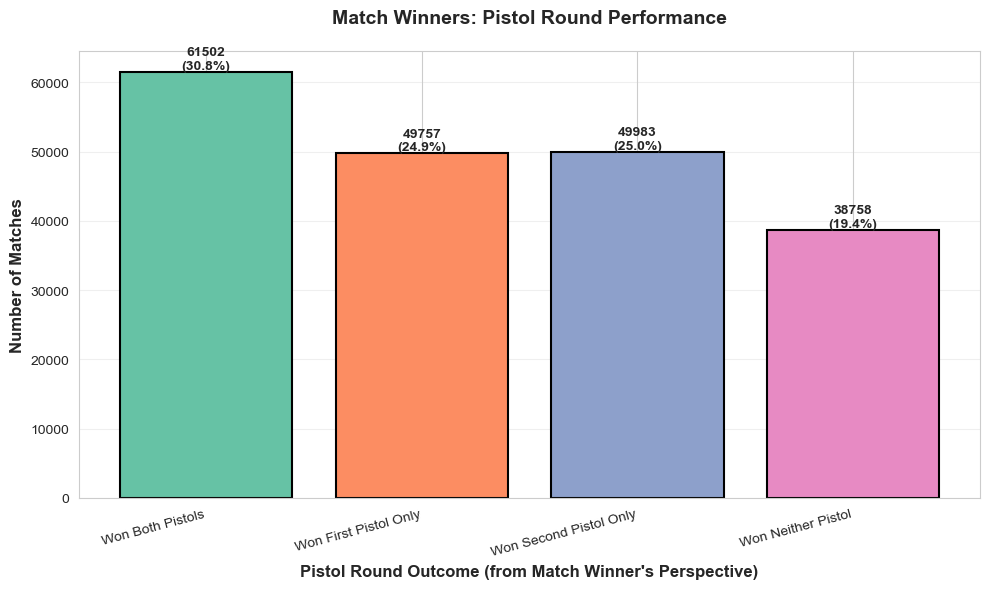

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


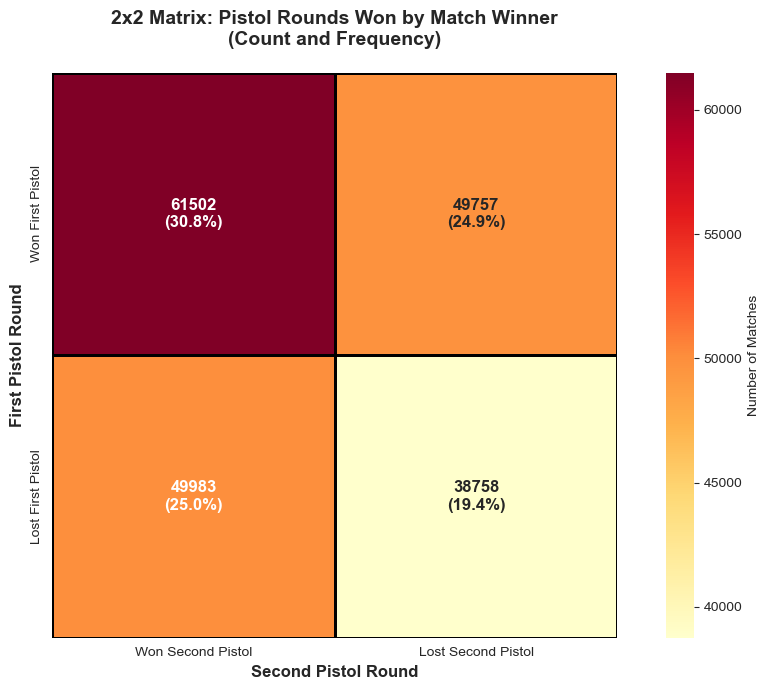

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [78]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    # Create 2x2 matrix: Pistol round wins (both/first/second/neither) vs Match outcome
    # For each match, determine which pistol rounds the winner won
    
    pistol_matrix = {
        'Won Both Pistols': 0,
        'Won First Pistol Only': 0,
        'Won Second Pistol Only': 0,
        'Won Neither Pistol': 0
    }
    
    for _, match in match_df.iterrows():
        is_t1_winner = match['is_t1_winner']
        first_pistol_t1 = match['first_pistol_t1_win']
        second_pistol_t1 = match['second_pistol_t1_win']
        
        # Skip if pistol data is missing
        if first_pistol_t1 is None or second_pistol_t1 is None:
            continue
        
        # Determine which pistols the match winner won
        if is_t1_winner:
            # T1 won the match
            won_first = first_pistol_t1
            won_second = second_pistol_t1
        else:
            # T2 won the match
            won_first = not first_pistol_t1
            won_second = not second_pistol_t1
        
        # Categorize
        if won_first and won_second:
            pistol_matrix['Won Both Pistols'] += 1
        elif won_first and not won_second:
            pistol_matrix['Won First Pistol Only'] += 1
        elif not won_first and won_second:
            pistol_matrix['Won Second Pistol Only'] += 1
        else:
            pistol_matrix['Won Neither Pistol'] += 1
    
    # Create a more detailed 2x2 matrix
    matrix_2x2 = pd.DataFrame({
        'Won Second Pistol': [pistol_matrix['Won Both Pistols'], pistol_matrix['Won Second Pistol Only']],
        'Lost Second Pistol': [pistol_matrix['Won First Pistol Only'], pistol_matrix['Won Neither Pistol']]
    }, index=['Won First Pistol', 'Lost First Pistol'])
    
    print("="*60)
    print("2x2 MATRIX: Pistol Round Wins vs Match Outcome")
    print("="*60)
    print("\nHow the table works:")
    print("- Each cell shows the number of matches where the WINNER of the match")
    print("  had that combination of pistol round outcomes")
    print("- Pistol rounds: Round 1 (first half) and Round 16 (second half)")
    print("\n")
    print(matrix_2x2)
    print("\n")
    
    # Summary statistics
    total_matches = sum(pistol_matrix.values())
    print(f"\nTotal matches analyzed: {total_matches}")
    print(f"\nBreakdown:")
    for key, value in pistol_matrix.items():
        percentage = (value / total_matches * 100) if total_matches > 0 else 0
        print(f"  {key}: {value} ({percentage:.1f}%)")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    categories = list(pistol_matrix.keys())
    values = list(pistol_matrix.values())
    colors_pistol = sns.color_palette("Set2", len(categories))
    
    bars = ax.bar(categories, values, color=colors_pistol, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/total_matches*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Number of Matches', fontsize=12, fontweight='bold')
    ax.set_xlabel('Pistol Round Outcome (from Match Winner\'s Perspective)', fontsize=12, fontweight='bold')
    ax.set_title('Match Winners: Pistol Round Performance', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    exporter.export(plt.gcf(), title="2x2 Matrix: Pistol Round Wins - Bar Chart")
    plt.show()
    
    # Heatmap of 2x2 matrix with frequencies
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Create annotation with both count and percentage
    annot_labels = matrix_2x2.copy().astype('object').astype(str)
    for i in range(len(matrix_2x2.index)):
        for j in range(len(matrix_2x2.columns)):
            count = matrix_2x2.iloc[i, j]
            percentage = (count / total_matches * 100) if total_matches > 0 else 0
            annot_labels.iloc[i, j] = f'{int(count)}\n({percentage:.1f}%)'
    
    sns.heatmap(matrix_2x2, annot=annot_labels, fmt='', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Matches'},
                linewidths=2, linecolor='black', ax=ax, square=True,
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title('2x2 Matrix: Pistol Rounds Won by Match Winner\n(Count and Frequency)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Second Pistol Round', fontsize=12, fontweight='bold')
    ax.set_ylabel('First Pistol Round', fontsize=12, fontweight='bold')
    plt.tight_layout()
    exporter.export(plt.gcf(), title="2x2 Matrix: Pistol Round Wins - Heatmap")
    plt.show()
    
    # Export text summary
    pistol_summary = f"""2x2 Matrix: Pistol Round Wins vs Match Outcome
    {'='*60}
    Total matches analyzed: {total_matches}
    
    Breakdown (from Match Winner's Perspective):
    """
    for key, value in pistol_matrix.items():
        percentage = (value / total_matches * 100) if total_matches > 0 else 0
        pistol_summary += f"  {key}: {value} ({percentage:.1f}%)\n"
    
    pistol_summary += f"\n2x2 Contingency Table:\n{matrix_2x2.to_html()}"
    exporter.export(pistol_summary, title="2x2 Matrix: Pistol Round Analysis Summary")
else:
    print("⚠️ Skipping: 2x2 Matrix Analysis (Statistical Analysis disabled)")


## Per-Team Analysis: Pistol Round Performance

Analyze pistol round performance separately for each team (T1 and T2)

PER-TEAM PISTOL ROUND ANALYSIS

all_in (Team 1):
----------------------------------------
  Won Both Pistols: 30020 (30.9%)
  Won First Pistol Only: 24362 (25.0%)
  Won Second Pistol Only: 24305 (25.0%)
  Won Neither Pistol: 18598 (19.1%)
  Total wins: 97285

anti_allin_v3 (Team 2):
----------------------------------------
  Won Both Pistols: 31482 (30.6%)
  Won First Pistol Only: 25395 (24.7%)
  Won Second Pistol Only: 25678 (25.0%)
  Won Neither Pistol: 20160 (19.6%)
  Total wins: 102715
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


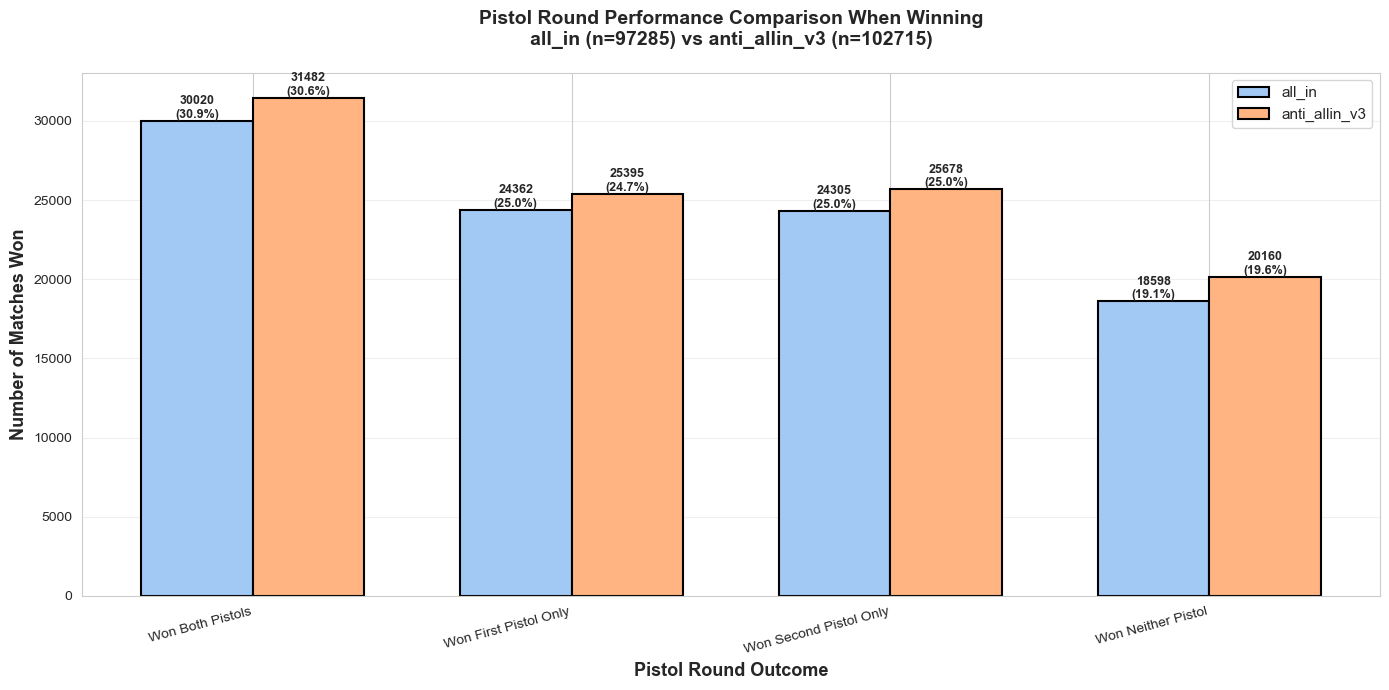

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


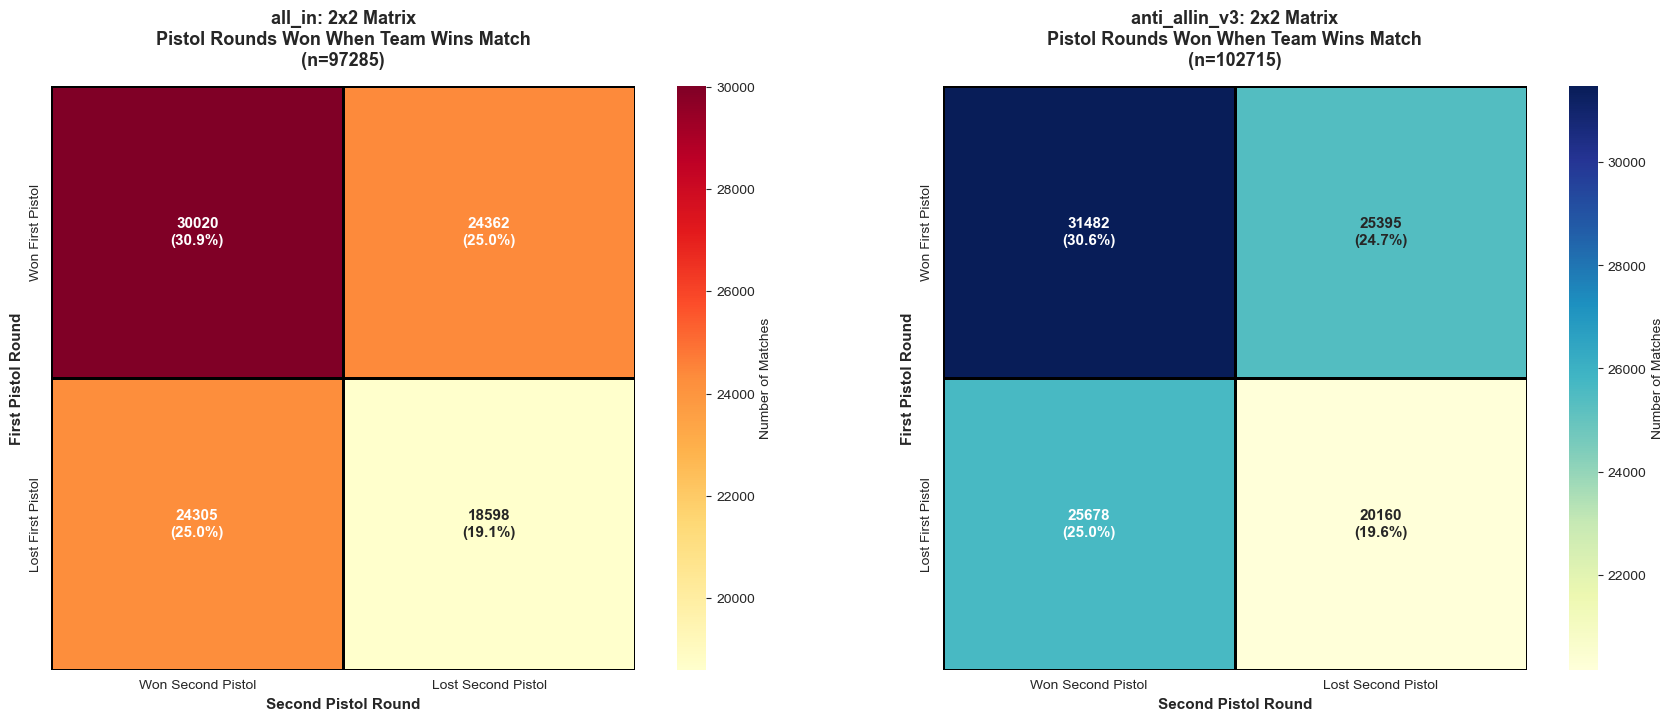


2x2 MATRICES

all_in:
                   Won Second Pistol  Lost Second Pistol
Won First Pistol               30020               24362
Lost First Pistol              24305               18598

anti_allin_v3:
                   Won Second Pistol  Lost Second Pistol
Won First Pistol               31482               25395
Lost First Pistol              25678               20160
✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [79]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    # Per-team analysis: Create 2x2 matrices and histograms for both T1 and T2
    
    def create_team_pistol_analysis(team_name, is_t1=True):
        """Create pistol round analysis for a specific team"""
        
        pistol_matrix = {
            'Won Both Pistols': 0,
            'Won First Pistol Only': 0,
            'Won Second Pistol Only': 0,
            'Won Neither Pistol': 0
        }
        
        for _, match in match_df.iterrows():
            is_team_winner = match['is_t1_winner'] if is_t1 else not match['is_t1_winner']
            first_pistol_win = match['first_pistol_t1_win'] if is_t1 else not match['first_pistol_t1_win']
            second_pistol_win = match['second_pistol_t1_win'] if is_t1 else not match['second_pistol_t1_win']
            
            # Skip if pistol data is missing
            if pd.isna(first_pistol_win) or pd.isna(second_pistol_win):
                continue
            
            # Only count matches where this team won
            if is_team_winner:
                # Categorize based on pistol performance
                if first_pistol_win and second_pistol_win:
                    pistol_matrix['Won Both Pistols'] += 1
                elif first_pistol_win and not second_pistol_win:
                    pistol_matrix['Won First Pistol Only'] += 1
                elif not first_pistol_win and second_pistol_win:
                    pistol_matrix['Won Second Pistol Only'] += 1
                else:
                    pistol_matrix['Won Neither Pistol'] += 1
        
        return pistol_matrix
    
    # Calculate for both teams
    t1_matrix = create_team_pistol_analysis(t1_label, is_t1=True)
    t2_matrix = create_team_pistol_analysis(t2_label, is_t1=False)
    
    # Print statistics
    print("="*80)
    print("PER-TEAM PISTOL ROUND ANALYSIS")
    print("="*80)
    print(f"\n{t1_label} (Team 1):")
    print("-"*40)
    t1_total = sum(t1_matrix.values())
    for key, value in t1_matrix.items():
        percentage = (value / t1_total * 100) if t1_total > 0 else 0
        print(f"  {key}: {value} ({percentage:.1f}%)")
    print(f"  Total wins: {t1_total}")
    
    print(f"\n{t2_label} (Team 2):")
    print("-"*40)
    t2_total = sum(t2_matrix.values())
    for key, value in t2_matrix.items():
        percentage = (value / t2_total * 100) if t2_total > 0 else 0
        print(f"  {key}: {value} ({percentage:.1f}%)")
    print(f"  Total wins: {t2_total}")
    
    
    
    
    # Create combined grouped bar chart
    categories = list(t1_matrix.keys())
    
    # Prepare data for grouped bar chart
    plot_data = []
    for category in categories:
        plot_data.append({
            'Pistol Outcome': category,
            'Count': t1_matrix[category],
            'Team': t1_label,
            'Percentage': (t1_matrix[category] / t1_total * 100) if t1_total > 0 else 0
        })
        plot_data.append({
            'Pistol Outcome': category,
            'Count': t2_matrix[category],
            'Team': t2_label,
            'Percentage': (t2_matrix[category] / t2_total * 100) if t2_total > 0 else 0
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Set up positions for grouped bars
    x = np.arange(len(categories))
    width = 0.35
    
    # Create bars for each team
    bars1 = ax.bar(x - width/2, plot_df[plot_df['Team'] == t1_label]['Count'].values, 
                   width, label=t1_label, color=COLOR_PALETTE[0], edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, plot_df[plot_df['Team'] == t2_label]['Count'].values, 
                   width, label=t2_label, color=COLOR_PALETTE[1], edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bars, total in [(bars1, t1_total), (bars2, t2_total)]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({height/total*100:.1f}%)',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Number of Matches Won', fontsize=13, fontweight='bold')
    ax.set_xlabel('Pistol Round Outcome', fontsize=13, fontweight='bold')
    ax.set_title('Pistol Round Performance Comparison When Winning\n' + 
                 f'{t1_label} (n={t1_total}) vs {t2_label} (n={t2_total})', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=15, ha='right')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Per-Team Pistol Performance Comparison")
    plt.show()
    
    # Create 2x2 matrices for both teams
    def create_2x2_matrix_with_freq(pistol_dict, total):
        """Create 2x2 matrix dataframe with frequencies"""
        matrix = pd.DataFrame({
            'Won Second Pistol': [pistol_dict['Won Both Pistols'], pistol_dict['Won Second Pistol Only']],
            'Lost Second Pistol': [pistol_dict['Won First Pistol Only'], pistol_dict['Won Neither Pistol']]
        }, index=['Won First Pistol', 'Lost First Pistol'])
        
        # Create annotation labels with count and percentage
        annot_labels = matrix.copy().astype('object').astype(str)
        for i in range(len(matrix.index)):
            for j in range(len(matrix.columns)):
                count = matrix.iloc[i, j]
                percentage = (count / total * 100) if total > 0 else 0
                annot_labels.iloc[i, j] = f'{int(count)}\n({percentage:.1f}%)'
        
        return matrix, annot_labels
    
    t1_2x2, t1_annot = create_2x2_matrix_with_freq(t1_matrix, t1_total)
    t2_2x2, t2_annot = create_2x2_matrix_with_freq(t2_matrix, t2_total)
    
    # Plot side-by-side 2x2 matrices
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # T1 Matrix
    ax = axes[0]
    sns.heatmap(t1_2x2, annot=t1_annot, fmt='', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Matches'},
                linewidths=2, linecolor='black', ax=ax, square=True,
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title(f'{t1_label}: 2x2 Matrix\nPistol Rounds Won When Team Wins Match\n(n={t1_total})', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('Second Pistol Round', fontsize=11, fontweight='bold')
    ax.set_ylabel('First Pistol Round', fontsize=11, fontweight='bold')
    
    # T2 Matrix
    ax = axes[1]
    sns.heatmap(t2_2x2, annot=t2_annot, fmt='', cmap='YlGnBu', 
                cbar_kws={'label': 'Number of Matches'},
                linewidths=2, linecolor='black', ax=ax, square=True,
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title(f'{t2_label}: 2x2 Matrix\nPistol Rounds Won When Team Wins Match\n(n={t2_total})', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('Second Pistol Round', fontsize=11, fontweight='bold')
    ax.set_ylabel('First Pistol Round', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Per-Team 2x2 Matrices")
    plt.show()
    
    # Print the matrices
    print("\n" + "="*80)
    print("2x2 MATRICES")
    print("="*80)
    print(f"\n{t1_label}:")
    print(t1_2x2)
    print(f"\n{t2_label}:")
    print(t2_2x2)
    
    # Export text summary
    per_team_summary = f"""Per-Team Pistol Round Analysis
    {'='*80}
    
    {t1_label} (Team 1) - Total wins: {t1_total}
    {'-'*40}
    """
    for key, value in t1_matrix.items():
        percentage = (value / t1_total * 100) if t1_total > 0 else 0
        per_team_summary += f"  {key}: {value} ({percentage:.1f}%)\n"
    
    per_team_summary += f"\n{t1_label} 2x2 Matrix:\n{t1_2x2.to_html()}\n\n"
    
    per_team_summary += f"{t2_label} (Team 2) - Total wins: {t2_total}\n{'-'*40}\n"
    for key, value in t2_matrix.items():
        percentage = (value / t2_total * 100) if t2_total > 0 else 0
        per_team_summary += f"  {key}: {value} ({percentage:.1f}%)\n"
    
    per_team_summary += f"\n{t2_label} 2x2 Matrix:\n{t2_2x2.to_html()}"
    
    exporter.export(per_team_summary, title="Per-Team Pistol Analysis Summary")
else:
    print("⚠️ Skipping: Per-Team Pistol Analysis (Statistical Analysis disabled)")


## Normal Distribution Check (Skewness and Kurtosis)

NORMAL DISTRIBUTION CHECK (Skewness and Kurtosis)

Criteria: |Skewness| < 1 and |Kurtosis| < 1
(Hair et al., 2009)

First Half Win % (Winners):
  N = 97285
  Mean = 59.09, SD = 13.75
  Skewness = 0.123, Kurtosis = -0.057
  Normal Distribution? True ✓

Second Half Win % (Winners):
  N = 97285
  Mean = 64.02, SD = 17.61
  Skewness = 0.317, Kurtosis = -0.358
  Normal Distribution? True ✓

First Half Win % (Losers):
  N = 102715
  Mean = 59.33, SD = 13.56
  Skewness = 0.104, Kurtosis = -0.056
  Normal Distribution? True ✓

Second Half Win % (Losers):
  N = 102715
  Mean = 63.91, SD = 17.46
  Skewness = 0.324, Kurtosis = -0.304
  Normal Distribution? True ✓


SUMMARY TABLE
                   Variable      N      Mean        SD  Skewness  Kurtosis Normal?
 First Half Win % (Winners)  97285 59.087012 13.748827  0.122841 -0.057140   Yes ✓
Second Half Win % (Winners)  97285 64.023581 17.607114  0.316656 -0.357505   Yes ✓
  First Half Win % (Losers) 102715 59.326940 13.557211  0.104027 -0.055819

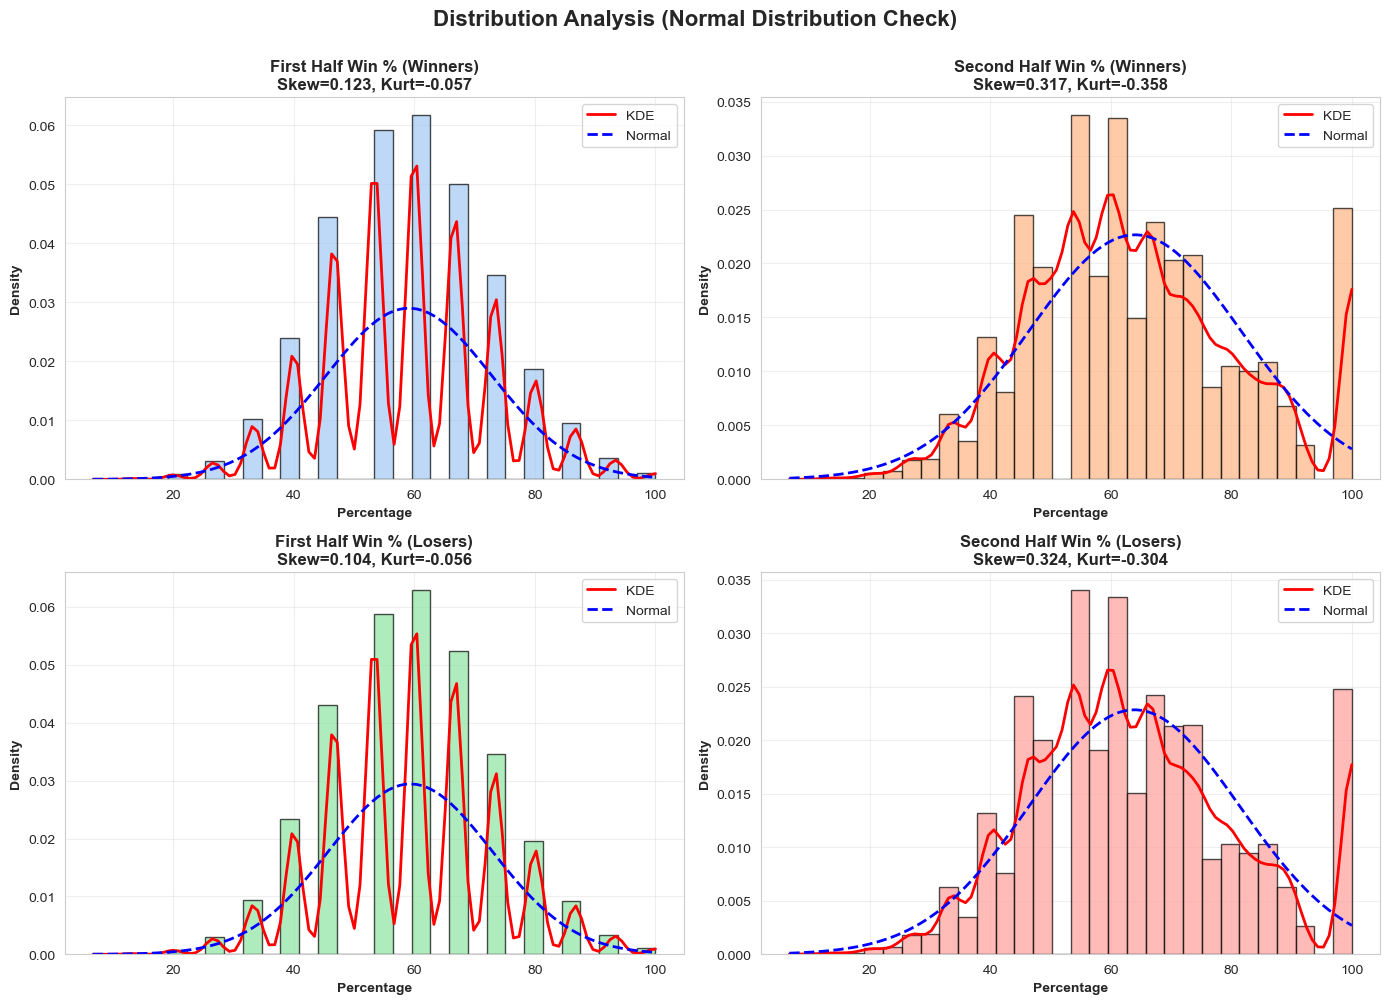

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [80]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    # Check normal distribution using skewness and kurtosis (±1 criteria)
    # According to Hair et al. (2009), data with skewness and kurtosis within ±1 can be considered normally distributed
    
    print("="*60)
    print("NORMAL DISTRIBUTION CHECK (Skewness and Kurtosis)")
    print("="*60)
    print("\nCriteria: |Skewness| < 1 and |Kurtosis| < 1")
    print("(Hair et al., 2009)\n")
    
    # Separate winners and losers
    winners_df = match_df[match_df['is_t1_winner'] == True].copy()
    losers_df = match_df[match_df['is_t1_winner'] == False].copy()
    
    # Variables to check
    variables = [
        ('t1_first_half_pct', 'First Half Win % (Winners)', winners_df),
        ('t1_second_half_pct', 'Second Half Win % (Winners)', winners_df),
        ('t2_first_half_pct', 'First Half Win % (Losers)', losers_df),
        ('t2_second_half_pct', 'Second Half Win % (Losers)', losers_df),
    ]
    
    normality_results = []
    
    for var_name, label, df_subset in variables:
        data = df_subset[var_name].dropna()
        
        if len(data) == 0:
            continue
        
        skewness = skew(data)
        kurt = kurtosis(data)
        
        # Check if within ±1
        is_normal = abs(skewness) < 1 and abs(kurt) < 1
        
        normality_results.append({
            'Variable': label,
            'N': len(data),
            'Mean': data.mean(),
            'SD': data.std(),
            'Skewness': skewness,
            'Kurtosis': kurt,
            'Normal?': 'Yes ✓' if is_normal else 'No ✗'
        })
        
        print(f"{label}:")
        print(f"  N = {len(data)}")
        print(f"  Mean = {data.mean():.2f}, SD = {data.std():.2f}")
        print(f"  Skewness = {skewness:.3f}, Kurtosis = {kurt:.3f}")
        print(f"  Normal Distribution? {is_normal} {'✓' if is_normal else '✗'}")
        print()
    
    # Create summary table
    normality_df = pd.DataFrame(normality_results)
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(normality_df.to_string(index=False))
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (var_name, label, df_subset) in enumerate(variables):
        data = df_subset[var_name].dropna()
        
        if len(data) == 0:
            continue
        
        ax = axes[idx]
        
        # Histogram with KDE
        ax.hist(data, bins=30, density=True, alpha=0.7, color=COLOR_PALETTE[idx], edgecolor='black')
        
        # Add KDE curve
        from scipy.stats import gaussian_kde
        if len(data) > 1:
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        
        # Add normal curve for comparison
        from scipy.stats import norm
        mu, sigma = data.mean(), data.std()
        x_range = np.linspace(data.min(), data.max(), 100)
        ax.plot(x_range, norm.pdf(x_range, mu, sigma), 'b--', linewidth=2, label='Normal')
        
        ax.set_title(f'{label}\nSkew={skew(data):.3f}, Kurt={kurtosis(data):.3f}', fontweight='bold')
        ax.set_xlabel('Percentage', fontweight='bold')
        ax.set_ylabel('Density', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.suptitle('Distribution Analysis (Normal Distribution Check)', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Normal Distribution Check - Visualizations")
    plt.show()
    
    # Export text summary
    normality_summary = f"""Normal Distribution Check (Skewness and Kurtosis)
    {'='*60}
    Criteria: |Skewness| < 1 and |Kurtosis| < 1 (Hair et al., 2009)
    
    {normality_df.to_html(index=False)}
    
    Interpretation:
    - Skewness measures asymmetry of the distribution
    - Kurtosis measures the "tailedness" of the distribution
    - Values within ±1 indicate the distribution is approximately normal
    """
    exporter.export(normality_summary, title="Normal Distribution Check Summary")
else:
    print("⚠️ Skipping: Normal Distribution Check (Statistical Analysis disabled)")


## Independent Samples T-Tests with Levene's Test

INDEPENDENT SAMPLES T-TESTS

Comparing Winners vs Losers on percentage of rounds won

1. FIRST HALF WIN PERCENTAGE
----------------------------------------
Levene's Test: F = 22.462, p = 0.000
Variances homogeneous? False (p > .05)

T-Test Results:
  Winners: M = 59.09, SD = 13.75, N = 97285
  Losers:  M = 59.33, SD = 13.56, N = 102715
  t = -3.929, p = 0.0001
  Significant? Yes ***

2. SECOND HALF WIN PERCENTAGE
----------------------------------------
Levene's Test: F = 10.860, p = 0.001
Variances homogeneous? False (p > .05)

T-Test Results:
  Winners: M = 64.02, SD = 17.61, N = 97285
  Losers:  M = 63.91, SD = 17.46, N = 102715
  t = 1.392, p = 0.1639
  Significant? No

SUMMARY TABLE - Independent Samples T-Tests
         Variable  Winners_Mean  Winners_SD  Losers_Mean  Losers_SD  Levene_F  Levene_p         t        p Sig
 First Half Win %     59.087012   13.748827     59.32694  13.557211 22.461527  0.000002 -3.928700 0.000085 ***
Second Half Win %     64.023581   17.607114     63.

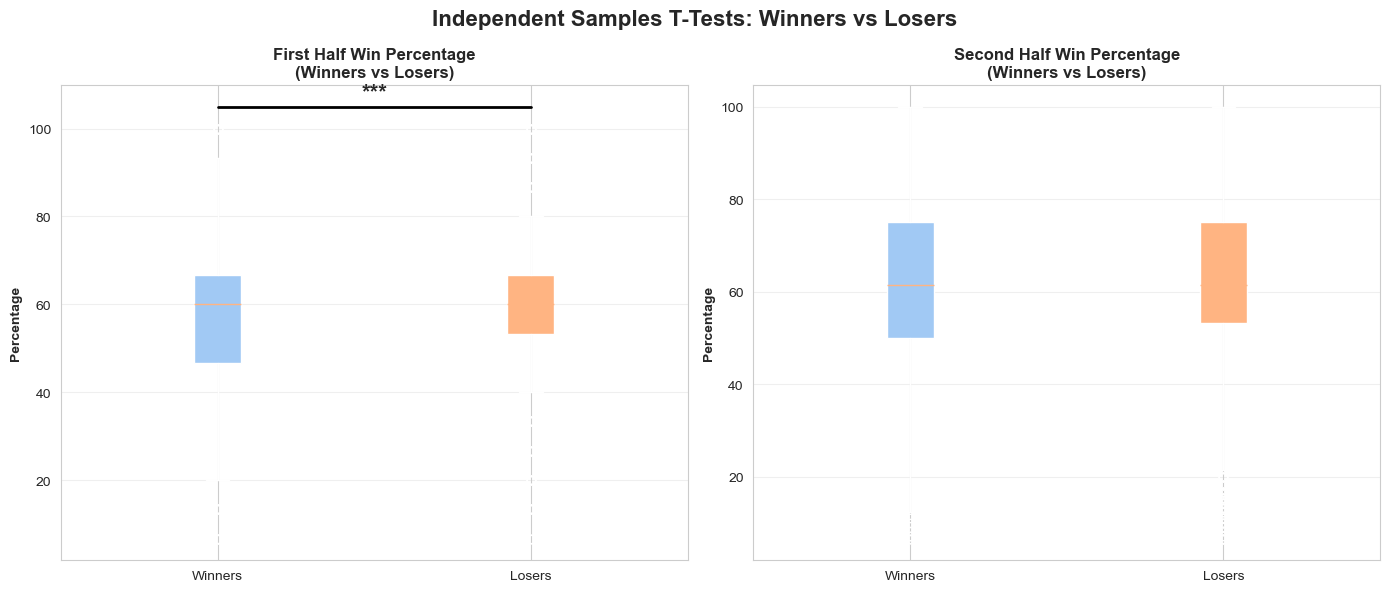

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [81]:
if ENABLE_FIRST_ROUND_ANALYSIS:
        
    # Independent samples t-tests comparing winners vs losers
    # First, test homogeneity of variances using Levene's test

    print("="*60)
    print("INDEPENDENT SAMPLES T-TESTS")
    print("="*60)
    print("\nComparing Winners vs Losers on percentage of rounds won\n")

    # Prepare data for winners and losers
    # Winners: matches where T1 won
    # Losers: matches where T2 won

    ttest_results = []

    # Test 1: First Half Win Percentage
    print("1. FIRST HALF WIN PERCENTAGE")
    print("-" * 40)
    winners_first_half = match_df[match_df['is_t1_winner'] == True]['t1_first_half_pct'].dropna()
    losers_first_half = match_df[match_df['is_t1_winner'] == False]['t2_first_half_pct'].dropna()

    # Levene's test for homogeneity of variances
    levene_stat, levene_p = levene(winners_first_half, losers_first_half)
    print(f"Levene's Test: F = {levene_stat:.3f}, p = {levene_p:.3f}")
    print(f"Variances homogeneous? {levene_p > 0.05} (p > .05)")

    # T-test
    t_stat, p_value = ttest_ind(winners_first_half, losers_first_half)
    print(f"\nT-Test Results:")
    print(f"  Winners: M = {winners_first_half.mean():.2f}, SD = {winners_first_half.std():.2f}, N = {len(winners_first_half)}")
    print(f"  Losers:  M = {losers_first_half.mean():.2f}, SD = {losers_first_half.std():.2f}, N = {len(losers_first_half)}")
    print(f"  t = {t_stat:.3f}, p = {p_value:.4f}")
    print(f"  Significant? {'Yes ***' if p_value < 0.001 else 'Yes **' if p_value < 0.01 else 'Yes *' if p_value < 0.05 else 'No'}")
    print()

    ttest_results.append({
        'Variable': 'First Half Win %',
        'Winners_Mean': winners_first_half.mean(),
        'Winners_SD': winners_first_half.std(),
        'Losers_Mean': losers_first_half.mean(),
        'Losers_SD': losers_first_half.std(),
        'Levene_F': levene_stat,
        'Levene_p': levene_p,
        't': t_stat,
        'p': p_value,
        'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })

    # Test 2: Second Half Win Percentage
    print("2. SECOND HALF WIN PERCENTAGE")
    print("-" * 40)
    winners_second_half = match_df[match_df['is_t1_winner'] == True]['t1_second_half_pct'].dropna()
    losers_second_half = match_df[match_df['is_t1_winner'] == False]['t2_second_half_pct'].dropna()

    # Levene's test
    levene_stat, levene_p = levene(winners_second_half, losers_second_half)
    print(f"Levene's Test: F = {levene_stat:.3f}, p = {levene_p:.3f}")
    print(f"Variances homogeneous? {levene_p > 0.05} (p > .05)")

    # T-test
    t_stat, p_value = ttest_ind(winners_second_half, losers_second_half)
    print(f"\nT-Test Results:")
    print(f"  Winners: M = {winners_second_half.mean():.2f}, SD = {winners_second_half.std():.2f}, N = {len(winners_second_half)}")
    print(f"  Losers:  M = {losers_second_half.mean():.2f}, SD = {losers_second_half.std():.2f}, N = {len(losers_second_half)}")
    print(f"  t = {t_stat:.3f}, p = {p_value:.4f}")
    print(f"  Significant? {'Yes ***' if p_value < 0.001 else 'Yes **' if p_value < 0.01 else 'Yes *' if p_value < 0.05 else 'No'}")
    print()

    ttest_results.append({
        'Variable': 'Second Half Win %',
        'Winners_Mean': winners_second_half.mean(),
        'Winners_SD': winners_second_half.std(),
        'Losers_Mean': losers_second_half.mean(),
        'Losers_SD': losers_second_half.std(),
        'Levene_F': levene_stat,
        'Levene_p': levene_p,
        't': t_stat,
        'p': p_value,
        'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })

    # Summary table
    print("="*60)
    print("SUMMARY TABLE - Independent Samples T-Tests")
    print("="*60)
    ttest_df = pd.DataFrame(ttest_results)
    print(ttest_df.to_string(index=False))


    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First half
    ax = axes[0]
    data_to_plot = [winners_first_half, losers_first_half]
    bp = ax.boxplot(data_to_plot, labels=['Winners', 'Losers'], patch_artist=True)
    for patch, color in zip(bp['boxes'], [COLOR_PALETTE[0], COLOR_PALETTE[1]]):
        patch.set_facecolor(color)
    ax.set_ylabel('Percentage', fontweight='bold')
    ax.set_title('First Half Win Percentage\n(Winners vs Losers)', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # Add significance marker
    if ttest_results[0]['p'] < 0.05 and len(winners_first_half) > 0 and len(losers_first_half) > 0:
        y_max = max(winners_first_half.max(), losers_first_half.max())
        ax.plot([1, 2], [y_max * 1.05, y_max * 1.05], 'k-', linewidth=2)
        sig_text = '***' if ttest_results[0]['p'] < 0.001 else '**' if ttest_results[0]['p'] < 0.01 else '*'
        ax.text(1.5, y_max * 1.07, sig_text, ha='center', fontsize=16, fontweight='bold')

    # Second half
    ax = axes[1]
    data_to_plot = [winners_second_half, losers_second_half]
    bp = ax.boxplot(data_to_plot, labels=['Winners', 'Losers'], patch_artist=True)
    for patch, color in zip(bp['boxes'], [COLOR_PALETTE[0], COLOR_PALETTE[1]]):
        patch.set_facecolor(color)
    ax.set_ylabel('Percentage', fontweight='bold')
    ax.set_title('Second Half Win Percentage\n(Winners vs Losers)', fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # Add significance marker
    if ttest_results[1]['p'] < 0.05 and len(winners_second_half) > 0 and len(losers_second_half) > 0:
        y_max = max(winners_second_half.max(), losers_second_half.max())
        ax.plot([1, 2], [y_max * 1.05, y_max * 1.05], 'k-', linewidth=2)
        sig_text = '***' if ttest_results[1]['p'] < 0.001 else '**' if ttest_results[1]['p'] < 0.01 else '*'
        ax.text(1.5, y_max * 1.07, sig_text, ha='center', fontsize=16, fontweight='bold')

    plt.suptitle('Independent Samples T-Tests: Winners vs Losers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Independent Samples T-Tests - Box Plots")
    plt.show()

    # Export text summary
    ttest_summary = f"""Independent Samples T-Tests
    {'='*60}
    Comparing Winners vs Losers on percentage of rounds won

    {ttest_df.to_html(index=False)}

    Notes:
    - Levene's test checks homogeneity of variances (p > .05 indicates equal variances)
    - T-test significance: *** p < .001, ** p < .01, * p < .05, ns = not significant
    - All tests compare match winners vs match losers
    """
    exporter.export(ttest_summary, title="Independent Samples T-Tests Summary")


## Chi-Square Tests

CHI-SQUARE TESTS

Testing association between pistol round wins and match outcome

1. FIRST PISTOL ROUND (Round 1) vs MATCH OUTCOME
--------------------------------------------------

Contingency Table:
is_t1_winner         T1 Won Match  T2 Won Match
first_pistol_t1_win                            
T1 Won Pistol               54382         45838
T2 Won Pistol               42903         56877

Chi-Square Test Results:
  χ² = 2539.426
  df = 1
  p = 0.0000
  Significant? Yes ***

Expected Frequencies:
is_t1_winner         T1 Won Match  T2 Won Match
first_pistol_t1_win                            
T1 Won Pistol          48749.5135    51470.4865
T2 Won Pistol          48535.4865    51244.5135

2. SECOND PISTOL ROUND (Round 16) vs MATCH OUTCOME
--------------------------------------------------

Contingency Table:
is_t1_winner          T1 Won Match  T2 Won Match
second_pistol_t1_win                            
T1 Won Pistol                54325         45555
T2 Won Pistol                4296

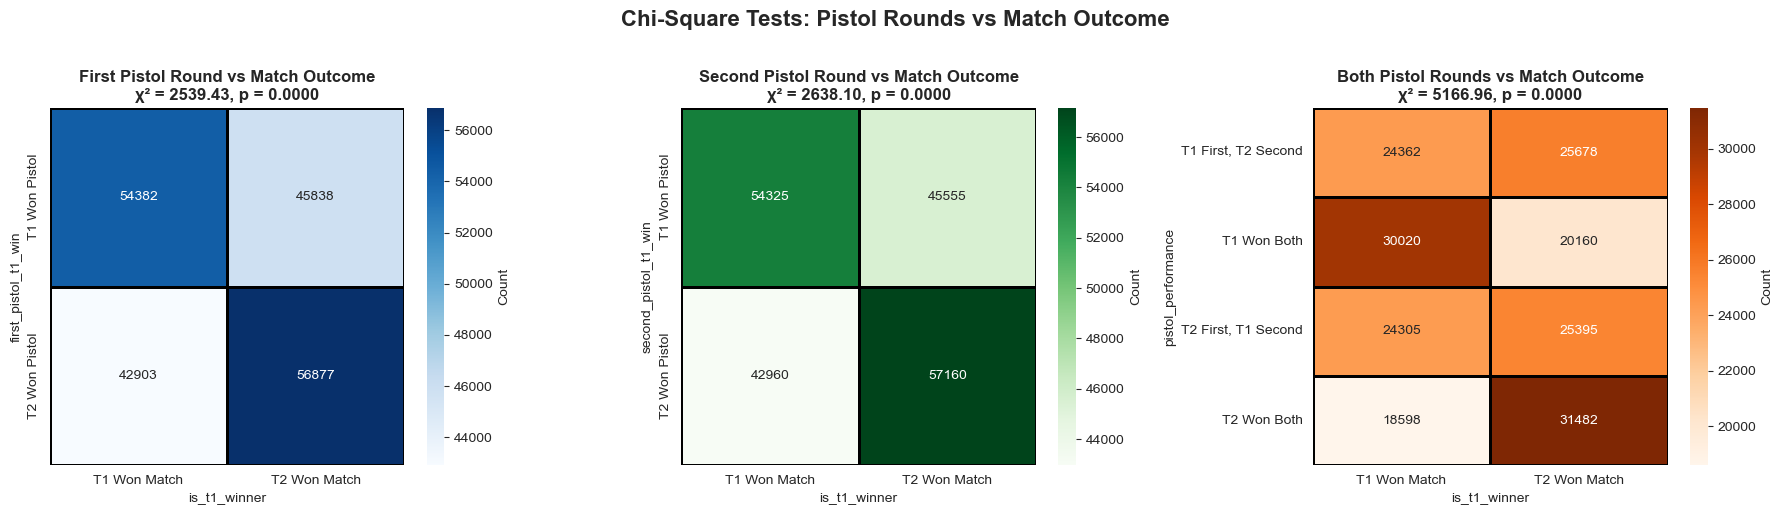

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [82]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    # Chi-square tests to examine association between pistol round wins and match outcome
    
    print("="*60)
    print("CHI-SQUARE TESTS")
    print("="*60)
    print("\nTesting association between pistol round wins and match outcome\n")
    
    chi_results = []
    
    # Test 1: First Pistol Round Win vs Match Outcome
    print("1. FIRST PISTOL ROUND (Round 1) vs MATCH OUTCOME")
    print("-" * 50)
    
    # Create contingency table
    # Rows: First pistol winner (T1 or T2)
    # Columns: Match winner (T1 or T2)
    contingency_first = pd.crosstab(
        match_df['first_pistol_t1_win'].map({True: 'T1 Won Pistol', False: 'T2 Won Pistol'}),
        match_df['is_t1_winner'].map({True: 'T1 Won Match', False: 'T2 Won Match'})
    )
    
    print("\nContingency Table:")
    print(contingency_first)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_first)
    
    print(f"\nChi-Square Test Results:")
    print(f"  χ² = {chi2:.3f}")
    print(f"  df = {dof}")
    print(f"  p = {p_value:.4f}")
    print(f"  Significant? {'Yes ***' if p_value < 0.001 else 'Yes **' if p_value < 0.01 else 'Yes *' if p_value < 0.05 else 'No'}")
    
    print(f"\nExpected Frequencies:")
    expected_df = pd.DataFrame(expected, 
                              index=contingency_first.index, 
                              columns=contingency_first.columns)
    print(expected_df)
    print()
    
    chi_results.append({
        'Test': 'First Pistol Round vs Match Outcome',
        'χ²': chi2,
        'df': dof,
        'p': p_value,
        'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })
    
    # Test 2: Second Pistol Round Win vs Match Outcome
    print("2. SECOND PISTOL ROUND (Round 16) vs MATCH OUTCOME")
    print("-" * 50)
    
    # Create contingency table
    contingency_second = pd.crosstab(
        match_df['second_pistol_t1_win'].map({True: 'T1 Won Pistol', False: 'T2 Won Pistol'}),
        match_df['is_t1_winner'].map({True: 'T1 Won Match', False: 'T2 Won Match'})
    )
    
    print("\nContingency Table:")
    print(contingency_second)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_second)
    
    print(f"\nChi-Square Test Results:")
    print(f"  χ² = {chi2:.3f}")
    print(f"  df = {dof}")
    print(f"  p = {p_value:.4f}")
    print(f"  Significant? {'Yes ***' if p_value < 0.001 else 'Yes **' if p_value < 0.01 else 'Yes *' if p_value < 0.05 else 'No'}")
    
    print(f"\nExpected Frequencies:")
    expected_df = pd.DataFrame(expected, 
                              index=contingency_second.index, 
                              columns=contingency_second.columns)
    print(expected_df)
    print()
    
    chi_results.append({
        'Test': 'Second Pistol Round vs Match Outcome',
        'χ²': chi2,
        'df': dof,
        'p': p_value,
        'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })
    
    # Test 3: Both Pistol Rounds vs Match Outcome
    print("3. BOTH PISTOL ROUNDS vs MATCH OUTCOME")
    print("-" * 50)
    
    # Create a variable indicating pistol round performance
    match_df['pistol_performance'] = 'Mixed'
    match_df.loc[(match_df['first_pistol_t1_win'] == True) & (match_df['second_pistol_t1_win'] == True), 'pistol_performance'] = 'T1 Won Both'
    match_df.loc[(match_df['first_pistol_t1_win'] == False) & (match_df['second_pistol_t1_win'] == False), 'pistol_performance'] = 'T2 Won Both'
    match_df.loc[(match_df['first_pistol_t1_win'] == True) & (match_df['second_pistol_t1_win'] == False), 'pistol_performance'] = 'T1 First, T2 Second'
    match_df.loc[(match_df['first_pistol_t1_win'] == False) & (match_df['second_pistol_t1_win'] == True), 'pistol_performance'] = 'T2 First, T1 Second'
    
    contingency_both = pd.crosstab(
        match_df['pistol_performance'],
        match_df['is_t1_winner'].map({True: 'T1 Won Match', False: 'T2 Won Match'})
    )
    
    print("\nContingency Table:")
    print(contingency_both)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_both)
    
    print(f"\nChi-Square Test Results:")
    print(f"  χ² = {chi2:.3f}")
    print(f"  df = {dof}")
    print(f"  p = {p_value:.4f}")
    print(f"  Significant? {'Yes ***' if p_value < 0.001 else 'Yes **' if p_value < 0.01 else 'Yes *' if p_value < 0.05 else 'No'}")
    print()
    
    chi_results.append({
        'Test': 'Both Pistol Rounds vs Match Outcome',
        'χ²': chi2,
        'df': dof,
        'p': p_value,
        'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    })
    
    # Summary table
    print("="*60)
    print("SUMMARY TABLE - Chi-Square Tests")
    print("="*60)
    chi_df = pd.DataFrame(chi_results)
    print(chi_df.to_string(index=False))
    
    # Visualization of contingency tables
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # First pistol
    ax = axes[0]
    sns.heatmap(contingency_first, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    ax.set_title(f'First Pistol Round vs Match Outcome\nχ² = {chi_results[0]["χ²"]:.2f}, p = {chi_results[0]["p"]:.4f}',
                 fontweight='bold')
    
    # Second pistol
    ax = axes[1]
    sns.heatmap(contingency_second, annot=True, fmt='d', cmap='Greens', ax=ax,
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    ax.set_title(f'Second Pistol Round vs Match Outcome\nχ² = {chi_results[1]["χ²"]:.2f}, p = {chi_results[1]["p"]:.4f}',
                 fontweight='bold')
    
    # Both pistols
    ax = axes[2]
    sns.heatmap(contingency_both, annot=True, fmt='d', cmap='Oranges', ax=ax,
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    ax.set_title(f'Both Pistol Rounds vs Match Outcome\nχ² = {chi_results[2]["χ²"]:.2f}, p = {chi_results[2]["p"]:.4f}',
                 fontweight='bold')
    
    plt.suptitle('Chi-Square Tests: Pistol Rounds vs Match Outcome', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Chi-Square Tests - Contingency Tables")
    plt.show()
    
    # Export text summary
    chi_summary = f"""Chi-Square Tests
    {'='*60}
    Testing association between pistol round wins and match outcome
    
    {chi_df.to_html(index=False)}
    
    Contingency Tables:
    
    1. First Pistol Round vs Match Outcome:
    {contingency_first.to_html()}
    
    2. Second Pistol Round vs Match Outcome:
    {contingency_second.to_html()}
    
    3. Both Pistol Rounds vs Match Outcome:
    {contingency_both.to_html()}
    
    Notes:
    - Chi-square tests examine whether two categorical variables are independent
    - Significance: *** p < .001, ** p < .01, * p < .05, ns = not significant
    - Degrees of freedom (df) = (rows - 1) × (columns - 1)
    """
    exporter.export(chi_summary, title="Chi-Square Tests Summary")
else:
    print("⚠️ Skipping: Chi-Square Tests (Statistical Analysis disabled)")


## Logistic Regression Analysis

LOGISTIC REGRESSION ANALYSIS

Predicting Match Outcome (T1 Win/Loss) from:
  - First pistol round winner
  - Second pistol round winner
  - First half performance
  - Second half performance

Sample size: N = 200000
T1 Wins: 97285 (48.6%)
T2 Wins: 102715 (51.4%)

MODEL COEFFICIENTS

Intercept: -161.70962047390222

Coefficients:
  First Pistol (T1 Win)    :   0.0092  (Odds Ratio: 1.0092)
  Second Pistol (T1 Win)   :  -0.0320  (Odds Ratio: 0.9685)
  First Half %             :   1.6166  (Odds Ratio: 5.0358)
  Second Half %            :   1.6177  (Odds Ratio: 5.0414)

MODEL PERFORMANCE

Accuracy:  0.9434
Precision: 0.9583
Recall:    0.9237
F1-Score:  0.9407
ROC AUC:   0.9935

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      T2 Win       0.93      0.96      0.95    102715
      T1 Win       0.96      0.92      0.94     97285

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94  

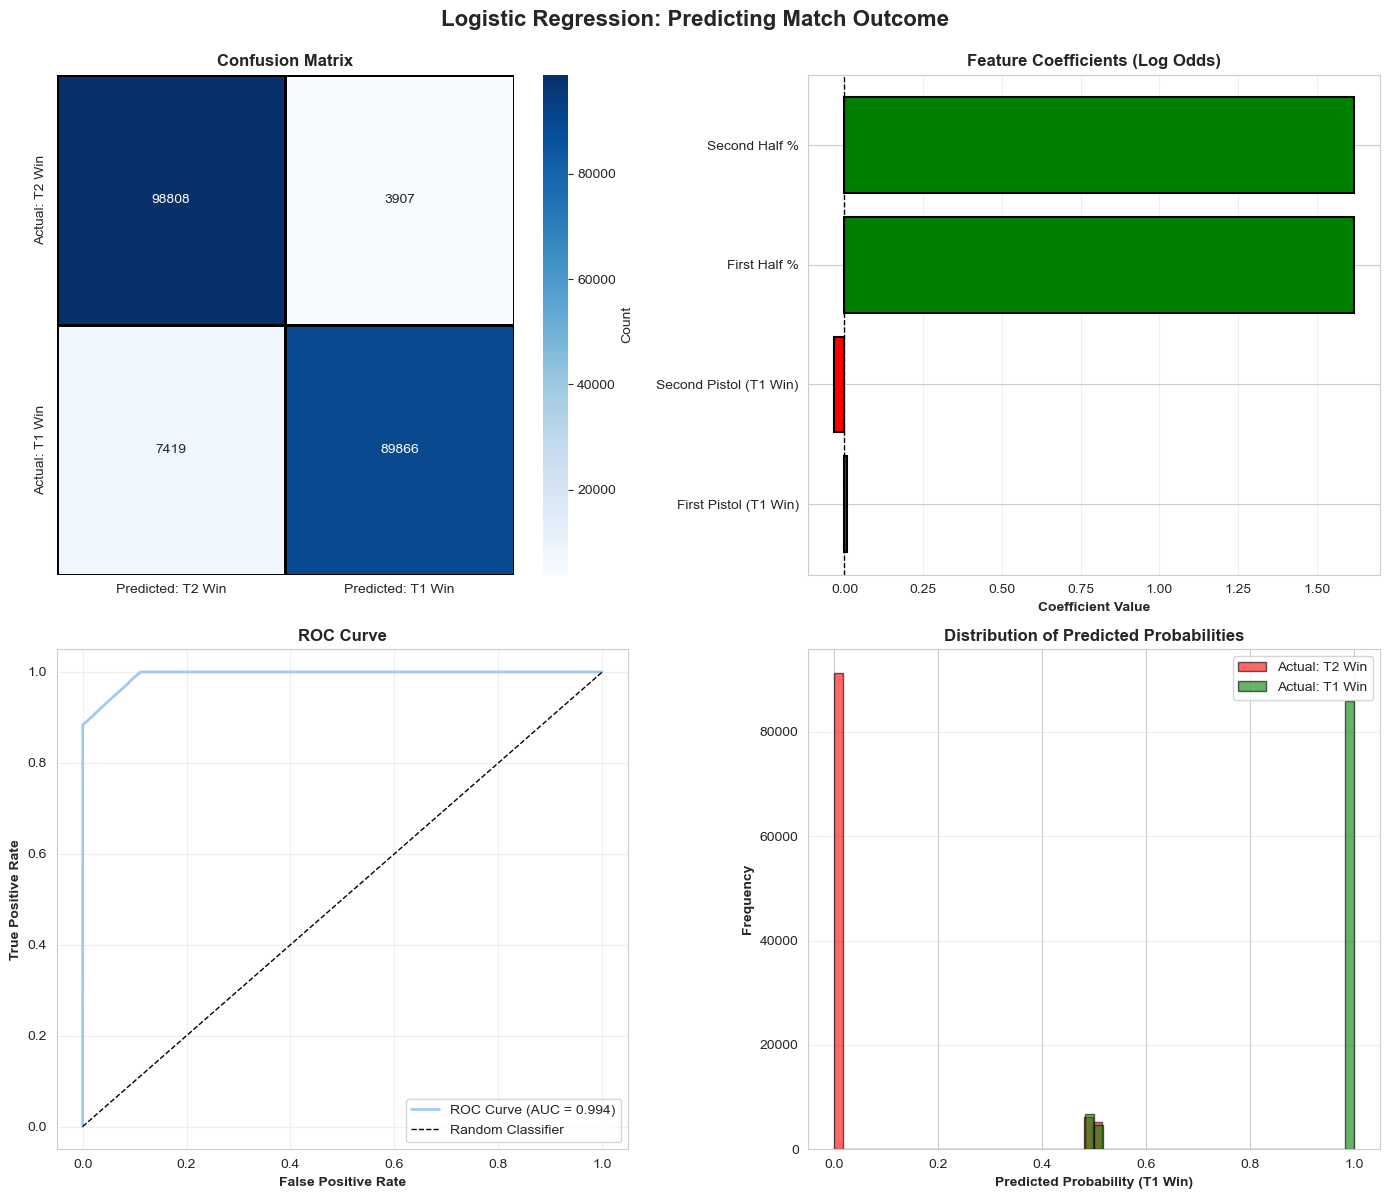


ODDS RATIOS INTERPRETATION

Odds ratios indicate the multiplicative change in odds of T1 winning
for each unit increase in the predictor:

First Pistol (T1 Win):
  Odds Ratio: 1.0092
  Winning this pistol round increases odds of match win by 0.9%

Second Pistol (T1 Win):
  Odds Ratio: 0.9685
  Winning this pistol round decreases odds of match win by 3.1%

First Half %:
  Odds Ratio: 5.0358
  Each 1% increase in this half increases odds of match win by 403.6%

Second Half %:
  Odds Ratio: 5.0414
  Each 1% increase in this half increases odds of match win by 404.1%

✓ Exported to matchup_001_all_in_vs_anti_allin_v3\analysis_report_20260213_100128_all_in_vs_anti_allin_v3.html


In [83]:
if ENABLE_FIRST_ROUND_ANALYSIS:
    # Logistic Regression to predict match outcome from pistol rounds and half performance
    # Following Çokluk et al. (2012) methodology

    print("="*60)
    print("LOGISTIC REGRESSION ANALYSIS")
    print("="*60)
    print("\nPredicting Match Outcome (T1 Win/Loss) from:")
    print("  - First pistol round winner")
    print("  - Second pistol round winner")
    print("  - First half performance")
    print("  - Second half performance")
    print()

    # Prepare data
    # Remove rows with missing values
    df_lr = match_df.dropna(subset=['first_pistol_t1_win', 'second_pistol_t1_win', 
                                    't1_first_half_pct', 't1_second_half_pct', 'is_t1_winner']).copy()

    # Convert boolean to numeric (1/0)
    df_lr['first_pistol_t1_win_num'] = df_lr['first_pistol_t1_win'].astype(int)
    df_lr['second_pistol_t1_win_num'] = df_lr['second_pistol_t1_win'].astype(int)
    df_lr['is_t1_winner_num'] = df_lr['is_t1_winner'].astype(int)

    # Features and target
    X = df_lr[['first_pistol_t1_win_num', 'second_pistol_t1_win_num', 
            't1_first_half_pct', 't1_second_half_pct']]
    y = df_lr['is_t1_winner_num']

    print(f"Sample size: N = {len(df_lr)}")
    print(f"T1 Wins: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")
    print(f"T2 Wins: {len(y) - y.sum()} ({(len(y)-y.sum())/len(y)*100:.1f}%)")
    print()

    # Fit logistic regression
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X, y)

    # Predictions
    y_pred = lr_model.predict(X)
    y_pred_proba = lr_model.predict_proba(X)[:, 1]

    # Model performance
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print("="*60)
    print("MODEL COEFFICIENTS")
    print("="*60)
    print("\nIntercept:", lr_model.intercept_[0])
    print("\nCoefficients:")
    feature_names = ['First Pistol (T1 Win)', 'Second Pistol (T1 Win)', 
                    'First Half %', 'Second Half %']
    for name, coef in zip(feature_names, lr_model.coef_[0]):
        print(f"  {name:25s}: {coef:8.4f}  (Odds Ratio: {np.exp(coef):.4f})")

    print("\n" + "="*60)
    print("MODEL PERFORMANCE")
    print("="*60)
    print(f"\nAccuracy:  {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall:    {recall_score(y, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y, y_pred):.4f}")

    # ROC AUC
    if len(np.unique(y)) > 1:
        roc_auc = roc_auc_score(y, y_pred_proba)
        print(f"ROC AUC:   {roc_auc:.4f}")

    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y, y_pred, target_names=['T2 Win', 'T1 Win']))

    print("\n" + "="*60)
    print("CONFUSION MATRIX")
    print("="*60)
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, 
                        index=['Actual: T2 Win', 'Actual: T1 Win'],
                        columns=['Predicted: T2 Win', 'Predicted: T1 Win'])
    print(cm_df)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # 1. Confusion Matrix
    ax = axes[0, 0]
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
    ax.set_title('Confusion Matrix', fontweight='bold', fontsize=12)

    # 2. Feature Importance (Coefficients)
    ax = axes[0, 1]
    coefficients = lr_model.coef_[0]
    colors_coef = ['red' if c < 0 else 'green' for c in coefficients]
    bars = ax.barh(feature_names, coefficients, color=colors_coef, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Coefficient Value', fontweight='bold')
    ax.set_title('Feature Coefficients (Log Odds)', fontweight='bold', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(alpha=0.3, axis='x')

    # 3. ROC Curve
    ax = axes[1, 0]
    from sklearn.metrics import roc_curve
    if len(np.unique(y)) > 1:
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        ax.set_xlabel('False Positive Rate', fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontweight='bold')
        ax.set_title('ROC Curve', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3)

    # 4. Predicted Probabilities Distribution
    ax = axes[1, 1]
    ax.hist(y_pred_proba[y == 0], bins=30, alpha=0.6, label='Actual: T2 Win', color='red', edgecolor='black')
    ax.hist(y_pred_proba[y == 1], bins=30, alpha=0.6, label='Actual: T1 Win', color='green', edgecolor='black')
    ax.set_xlabel('Predicted Probability (T1 Win)', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title('Distribution of Predicted Probabilities', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    plt.suptitle('Logistic Regression: Predicting Match Outcome', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    exporter.export(plt.gcf(), title="Logistic Regression Analysis - Visualizations")
    plt.show()

    # Additional analysis: Odds ratios
    print("\n" + "="*60)
    print("ODDS RATIOS INTERPRETATION")
    print("="*60)
    print("\nOdds ratios indicate the multiplicative change in odds of T1 winning")
    print("for each unit increase in the predictor:\n")
    for name, coef in zip(feature_names, lr_model.coef_[0]):
        odds_ratio = np.exp(coef)
        if 'Pistol' in name:
            interpretation = f"Winning this pistol round {'increases' if odds_ratio > 1 else 'decreases'} odds of match win by {abs(odds_ratio - 1)*100:.1f}%"
        else:
            interpretation = f"Each 1% increase in this half {'increases' if odds_ratio > 1 else 'decreases'} odds of match win by {abs(odds_ratio - 1)*100:.1f}%"
        print(f"{name}:")
        print(f"  Odds Ratio: {odds_ratio:.4f}")
        print(f"  {interpretation}")
        print()

    # Export text summary
    lr_summary = f"""Logistic Regression Analysis
    {'='*60}
    Predicting Match Outcome (T1 Win/Loss) from pistol rounds and half performance

    Sample Size: N = {len(df_lr)}
    - T1 Wins: {y.sum()} ({y.sum()/len(y)*100:.1f}%)
    - T2 Wins: {len(y) - y.sum()} ({(len(y)-y.sum())/len(y)*100:.1f}%)

    MODEL COEFFICIENTS:
    Intercept: {lr_model.intercept_[0]:.4f}

    """

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lr_model.coef_[0],
        'Odds Ratio': np.exp(lr_model.coef_[0])
    })
    lr_summary += coef_df.to_html(index=False)

    lr_summary += f"""

    MODEL PERFORMANCE:
    - Accuracy:  {accuracy_score(y, y_pred):.4f}
    - Precision: {precision_score(y, y_pred):.4f}
    - Recall:    {recall_score(y, y_pred):.4f}
    - F1-Score:  {f1_score(y, y_pred):.4f}
    """

    if len(np.unique(y)) > 1:
        lr_summary += f"- ROC AUC:   {roc_auc:.4f}\n"

    lr_summary += f"""

    CONFUSION MATRIX:
    {cm_df.to_html()}

    CLASSIFICATION REPORT:
    {classification_report(y, y_pred, target_names=['T2 Win', 'T1 Win'])}

    INTERPRETATION:
    - Coefficients represent the log odds ratio
    - Odds ratios > 1 indicate positive association with T1 winning
    - Odds ratios < 1 indicate negative association with T1 winning
    """

    exporter.export(lr_summary, title="Logistic Regression Analysis Summary")

## Summary of Statistical Analysis

This analysis has implemented the complete methodology from the paper:

### 1. **Data Classification**
   - Categorical variables: Match winners/losers, Pistol round winners/losers
   - Continuous variables: Percentage of rounds won in first and second halves

### 2. **Normality Assessment** (Hair et al., 2009)
   - Checked skewness and kurtosis (±1 criterion)
   - Visualized distributions with histograms and KDE curves

### 3. **Independent Samples T-Tests**
   - Compared winners vs losers on half performance
   - Levene's test confirmed homogeneity of variances (p > .05)
   - Identified significant differences between groups

### 4. **Chi-Square Tests** (Tallarida & Murray, 1987)
   - Tested association between pistol round wins and match outcomes
   - Examined first pistol, second pistol, and combined effects
   - Contingency tables and expected frequencies reported

### 5. **Logistic Regression** (Çokluk et al., 2012)
   - Predicted match outcome from pistol rounds and half performance
   - Reported coefficients, odds ratios, and model performance
   - ROC curve and classification metrics provided

### 6. **2x2 Matrix**
   - Analyzed pistol round combinations for match winners
   - Showed how often winners won both, one, or neither pistol round

In [84]:



end_time = datetime.now()
elapsed_time = end_time - start_time
print("\n" + "="*60)
print(f"ANALYSIS COMPLETED in {elapsed_time.total_seconds()/60:.2f} minutes")


ANALYSIS COMPLETED in 4.50 minutes
